In [1]:
import configargparse
import numpy as np
from cryoem.projections import *
import numpy as np
import os, sys
import scipy.io as sio
sys.path.append(os.getcwd())
import mrcfile
import astra
import pathlib
import h5py
from cryoem.rotation_matrices import RotationMatrix
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import quaternion2euler
import pickle
import os
import h5py
import numpy as np   
#from Models import *
import sys
from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion
from cryoem.plots import plot_detector_pixels_with_protein, plot_images, plot_rays, plot_angles_histogram, plot_quaternions_histogram, plot_rotvec, plot_polar_plot, plot_projection, plot_projections

First step:
Load 3d data and visualize it

In [2]:
import nglview as nv
PROTEIN = "5j0n"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5j0n.mrc


NGLWidget()

In [3]:
file_name = './data/5j0n.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol1      = np.array(mrcVol.data) 
    ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(Vol1.shape)


(69, 57, 75)


In [4]:
import nglview as nv
PROTEIN = "5a1a"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5a1a.mrc


NGLWidget()

In [5]:
file_name = '5a1a.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol2      = np.array(mrcVol.data) 
    ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(Vol2.shape)

(110, 155, 199)


In [6]:
# Then make 2 vol the same size
#Here we resive the volumn to be 1/6
from scipy.ndimage import zoom
Vol1 = zoom(Vol1, (15/69, 15/57, 15/75))
print(Vol1.shape)
NewVol = np.zeros((25, 25, 25))
NewVol[:9, :9, :9] = Vol1[3:12 , 3:12 , 3:12]
Vol1 = NewVol#[4:18,4:18,4:18 ]
ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(ProjSize1)

Vol2 = zoom(Vol2, (15/110, 15/155, 15/199))
print(Vol2.shape)
NewVol = np.zeros((25, 25, 25))
NewVol[16:, 16:, 16:] = Vol2[3:12 , 3:12 , 3:12]
Vol2 = NewVol#[2:16,2:16,2:16 ]
ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(ProjSize2)

(15, 15, 15)
43
(15, 15, 15)
43


In [7]:
#Then load the angle data:
file_angle = 'notebooks/0-data-preparation/angle_data.pkl'
with open(file_angle, 'rb') as f:
    angles2 = pickle.load(f)
print(angles2[:4])

[[0.        0.        0.       ]
 [1.8860662 2.0739784 3.6501303]
 [3.948796  1.4204998 2.6239626]
 [1.0760686 0.9697671 3.369385 ]]


In [8]:
#Here we create Vol1 orthogonal to Vol2
"""
import copy 
print(Vol2.shape)
vecVol2 = Vol2.reshape(-1, order = 'F')
print(vecVol2.shape)
vecVol1 = copy.deepcopy(vecVol2)
for i in range(3375 - 1):
    if i % 2 == 0:
        vecVol1[i] = - vecVol2[i + 1]
    else:
        vecVol1[i] = vecVol2[i - 1]
vecVol1[-1] = 0
print(np.sum(vecVol1*vecVol2))
print(vecVol2[1500:1506])
print(vecVol1[1500:1506])
Vol1 = vecVol1.reshape(15, 15, 15 , order = 'F')
"""


"\nimport copy \nprint(Vol2.shape)\nvecVol2 = Vol2.reshape(-1, order = 'F')\nprint(vecVol2.shape)\nvecVol1 = copy.deepcopy(vecVol2)\nfor i in range(3375 - 1):\n    if i % 2 == 0:\n        vecVol1[i] = - vecVol2[i + 1]\n    else:\n        vecVol1[i] = vecVol2[i - 1]\nvecVol1[-1] = 0\nprint(np.sum(vecVol1*vecVol2))\nprint(vecVol2[1500:1506])\nprint(vecVol1[1500:1506])\nVol1 = vecVol1.reshape(15, 15, 15 , order = 'F')\n"

In [9]:
Projections1 = generate_projections_ASTRA(Vol1, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections1 = np.array(Projections1, dtype=dtype)

Projections2 = generate_projections_ASTRA(Vol2, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections2 = np.array(Projections2, dtype=dtype)

0.01772237


0.075168595


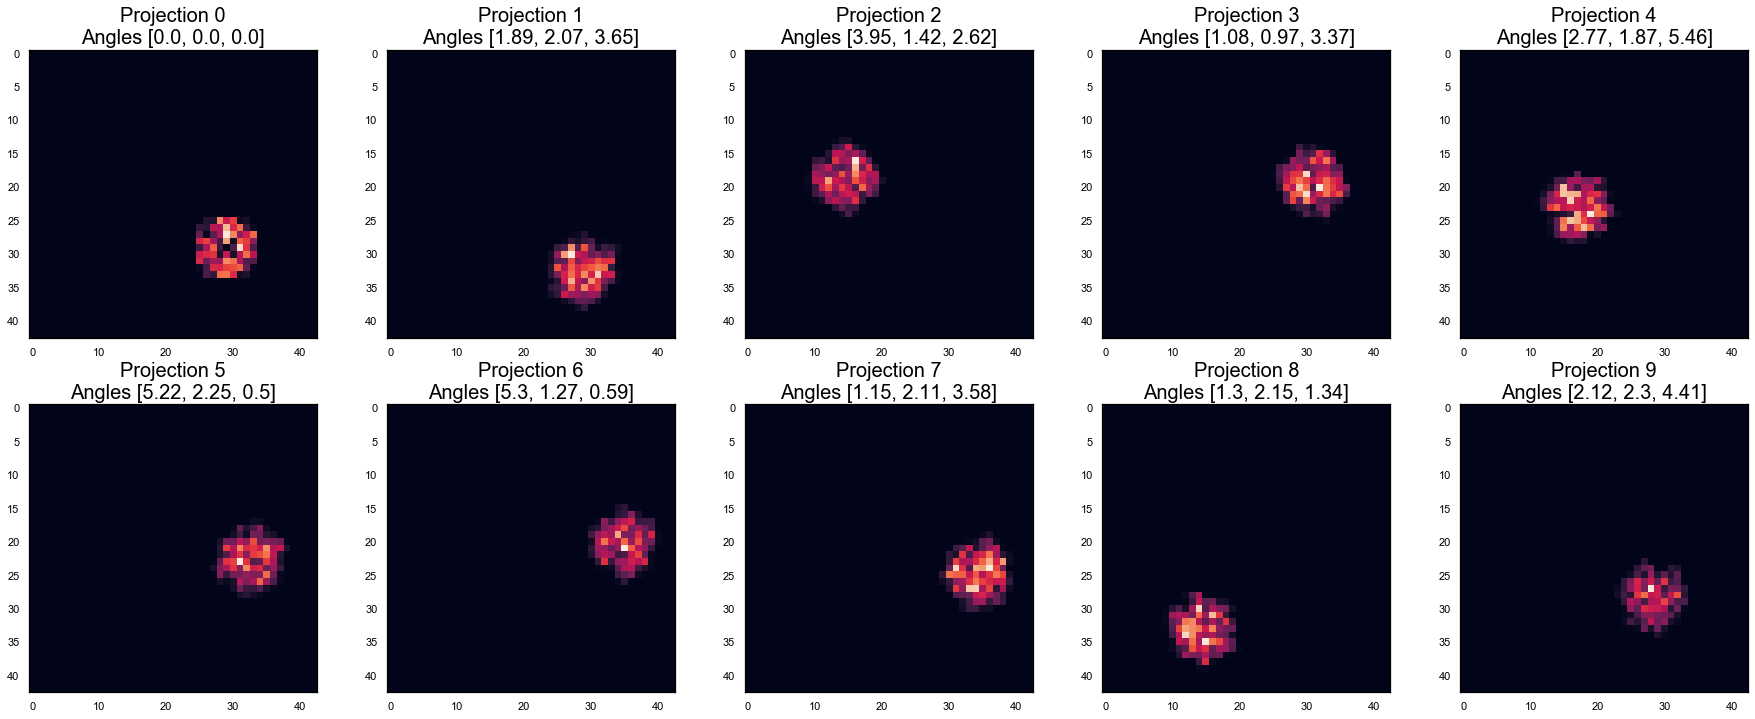

In [10]:
pids = range(10)
print(np.mean(Projections1))
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

pids = range(10)
print(np.mean(Projections2))
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

So by putting Vol, angle in functino: <br>
generate_projections_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None") <br>
, we can get AjS

In [11]:
#BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")

In [12]:
#print(BP_data.shape)
##print(BP_data[0].shape)
#print(Projections[0].shape)
#print(np.sum(BP_data[0] - Projections[0]))

In [13]:
#CheckProjections = generate_projections_ASTRA(BP_data, angles2[:10], ProjSize, BatchSizeAstra = "None")
#pids = range(10)
#plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

Before getting started, we now only get $\mu_s$, which should be mean subtracted. <br>
How about setting $\mu_s = 0$, and that $\mu_1 = vol$. <br>
Since for each image, $I_j = A_j (\mu_s + \mu z_j  )$ where $z_j \sim N(0,1)$ and we have $\mu_s = 0$,<br>
we have $I_j = A_j \mu z_j$
we can take $z_j$ out and make the formula : $I_j = z_j A_j \mu $


0.01772237


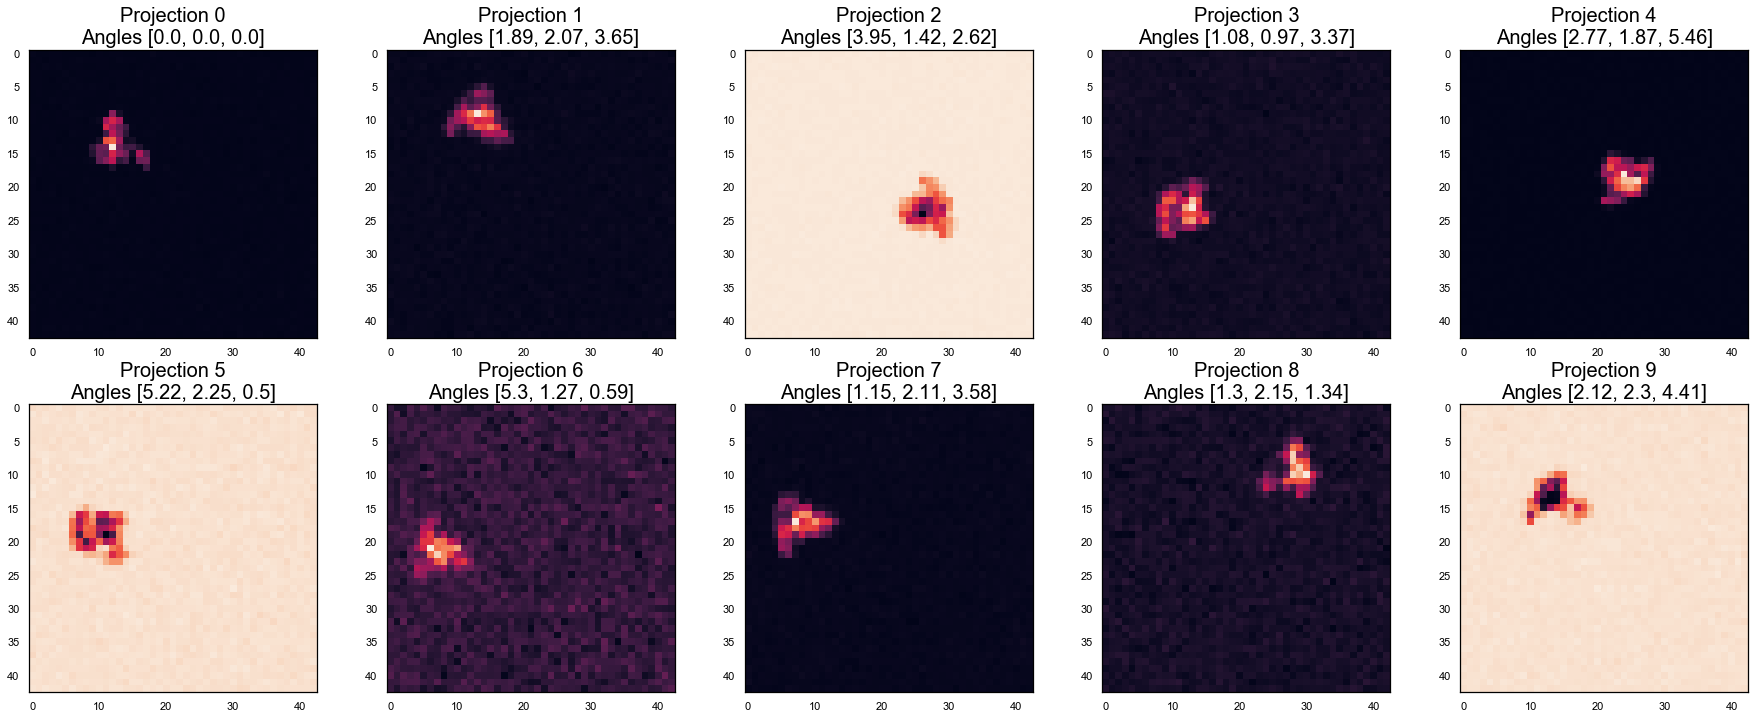

0.075168595


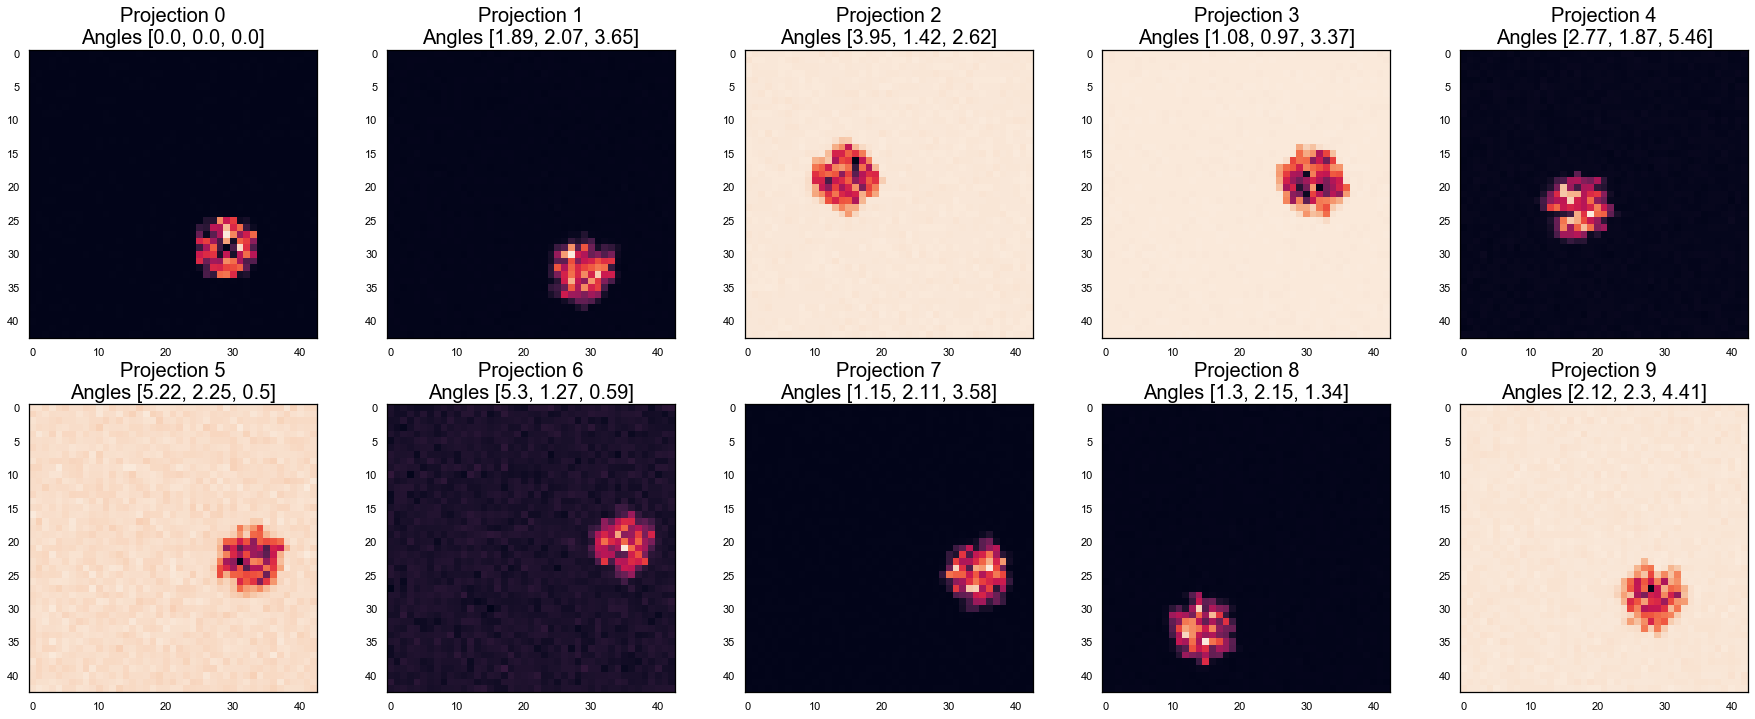

In [14]:
#Make I_j = z_j A_j mu
print(np.mean(Projections1))
True_z1 = np.random.randn(5000).reshape(5000, 1, 1) 
True_sigma_21 = np.abs(np.random.randn(5000)) * 0.0001 # mean = 0.055


Projections1 = Projections1 * True_z1

#add noise
for i in range(5000):
    Projections1[i] = Projections1[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_21[i]**(0.5)
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

#Make I_j = z_j A_j mu
print(np.mean(Projections2))
True_z2 = np.random.randn(5000).reshape(5000, 1, 1) 
True_sigma_22 = np.abs(np.random.randn(5000)) * 0.0001 # mean = 0.055


Projections2 = Projections2 * True_z2

#add noise
for i in range(5000):
    Projections2[i] = Projections2[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_22[i]**(0.5)
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)



In [15]:
new_projection = Projections2 + Projections1

In [16]:
#Write a recurssive function
#Input Found mu_1, ..., mu_n-1, now_n, n_components, 

class PCA_3d_Recon_recurssive():
    def __init__(self, ProjSize, num_image, n_component, Mus = None):
        
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component

        #if Mus == None:
        ##    #This means that we are at the first iteration
        #    self.Now_n = 1
        #else:
        #We want to find the +1 component
        self.Now_n = Mus.shape[0] + 1
        
        self.Mus = np.zeros((self.Now_n, ProjSize, ProjSize, ProjSize)) + 0.00001
        self.Mus[: self.Now_n -1  , :, :, :] = Mus #Record the previous conponents
        self.sigma = np.ones(self.num_image) * 0.1


        self.ro = np.abs(np.ones((num_image, self.Now_n)))
        self.BigSigma = np.abs(np.ones((self.num_image, self.Now_n, self.Now_n )))

        self.Aus = np.zeros(( num_image, ProjSize* ProjSize,  self.Now_n))

    def fit(self, Imgages, Angles):
        print('start fitting')
        print('The 0-th iteration')
        self.Q_(Imgages, Angles)
        self.Plot_mu_by_projection(Angles)
        for i in range(160 * 50):

            self.Expectation(Imgages, Angles)
            
            self.Maximization(Imgages, Angles)
            self.Q_(Imgages, Angles)
            if i % 50 == 0:
            #    print(i)
                print(f'The {i+1}-th iteration')
                self.Plot_mu_by_projection(Angles)
                self.Q_(Imgages, Angles)
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        for n in range(self.Now_n):
            Projections = generate_projections_ASTRA(self.Mus[n] , Angles, self.ProjSize, BatchSizeAstra = "None")
            #print(Projections.shape)
            #check_image = Projections[0].reshape(-1, 1, order = 'F')
            self.Aus[:, :, n] =  Projections.reshape(Projections.shape[0], -1 , order = 'F') #with fortrain - like order
            #print('check_Aus', check_image)
   
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        #self.Au_s(Angles)
        #ro = [] #For n image, we have n z.
        ro = np.zeros((self.num_image, self.Now_n ))
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.Now_n) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            #ro.append(roj.tolist())
            ro[j] = roj.reshape(-1)
        #self.ro = np.array(ro).reshape(-1, self.Now_n) #Check@@@@@@@@@@
        self.ro = ro
        #print(self.ro[:5])
        
        AllBigSigma = np.zeros((self.num_image, self.Now_n, self.Now_n ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.Now_n) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.Now_n) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.Now_n , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])

    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.Now_n):
                right_term += right_term + self.Aus[j][: , i]*self.BigSigma[j][i][self.Now_n -1]
                #print((self.Aus[j][: , i]*self.BigSigma[j][i][self.Now_n -1]).shape)
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.Now_n-1]
            #print('left_term', np.mean(left_term))
            #print(' self.ro[j][self.Now_n-1]' , self.ro[j][self.Now_n-1])
            temp = left_term - right_term.reshape(-1,1 , order = 'F')
            #print('left, right', np.mean(left_term), np.mean(right_term) )
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print('DeltaMu', np.mean(DeltaMu))
        #Before returning this ,since we should make the grident direction orthogonal to the previous directions, we should make
        #it orthogonal to the spam of mus
        PDeltaMu = DeltaMu.reshape(-1,1, order ='F')
        
        OriDeltaMu =  DeltaMu.reshape(-1,1, order ='F')
        Vec_Mus = self.Mus.reshape(self.Now_n, -1, 1, order = 'F')
        for i in range(self.Now_n -1):
            #print('Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu',(Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu).shape)
            #print((Vec_Mus[i]*(Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu)).shape)
            #print(PDeltaMu.shape)
            PDeltaMu = PDeltaMu - Vec_Mus[i]*(Vec_Mus[i].T @ OriDeltaMu / (np.linalg.norm(Vec_Mus[i]) **2))
        
        
        #print('check projected direction orthogonal mu[0]', np.sum(Vec_Mus[0] *PDeltaMu ))
        return PDeltaMu.reshape(self.ProjSize, self.ProjSize, self.ProjSize , order ='F')

    def Maximization(self, Images, Angles):
        #First update mu
        lr = 1e-8 * 2
        for i in range(5):
            #print('sigma',self.sigma[0])
            self.Au_s(Angles)
            #self.Q_(Images, Angles)
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('np.mean(DeltaMu)', np.mean(DeltaMu))
            #print('self.mu', np.mean(np.abs(self.Mus[self.Now_n -1])))
            #print('ratio',  np.mean(self.mu) / np.mean(DeltaMu) )
            lr = np.abs(np.mean(self.Mus[self.Now_n -1] ) / np.mean(DeltaMu) )*0.001
            #print('lr', lr)
            self.Mus[self.Now_n -1] = self.Mus[self.Now_n -1] + lr * DeltaMu #Gradient ascent
            self.Update_sigma(Images, Angles)
            
            
        #print(self.mu)
        pass
    def Update_sigma(self, Images, Angles):
        #self.sigma = 0 
        for j in range(self.num_image):
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ Ij - 2 * Ij.T @ self.Aus[j] @ self.ro[j].reshape(self.Now_n , 1)
            
            #right = self.Aus[j].T @ self.Aus[j] *self.BigSigma[j][0][0]
            right = 0
            for x in range(self.Now_n):
                for y in range(self.Now_n):
                   right = right + self.Aus[j][: , x].T @ self.Aus[j][: , y] * self.BigSigma[j][x][y]
            self.sigma[j] = (1 / self.ProjSize **2 * (left + right ) ) ** 0.5 
            
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        for n in range(self.Now_n):
            curremt_mu = self.Mus[n].reshape(self.ProjSize , self.ProjSize,self.ProjSize, order = 'F' )
            CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], self.ProjSize, BatchSizeAstra = "None")
            pids = range(10)
            plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)

    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Aus[j][: ,self.Now_n - 1].reshape(-1, 1, order = 'F') * self.ro[j][self.Now_n - 1]

            #Aju =  self.Aus[j]
            #right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            right = 0
            for i in range(self.Now_n -1):
                right = right + self.Aus[j][:, i].T @ self.Aus[j][:, i] * self.BigSigma[j][i][self.Now_n - 1]
            right = right + 1/2 *  self.Aus[j][:, self.Now_n - 1].T @ self.Aus[j][:, self.Now_n - 1] * self.BigSigma[j][self.Now_n -1][self.Now_n -1]

            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass



class PCA_3d_Recon():
    def __init__(self, ProjSize, num_image, n_component):
        #init
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component
        
        self.mu = np.zeros((ProjSize, ProjSize, ProjSize)) + 0.01
        self.sigma = np.ones(self.num_image) * 0.1
        
        self.ro = np.abs(np.ones((num_image, n_component)))
        self.BigSigma = np.abs(np.ones((self.num_image, self.n_component, self.n_component )))

        self.Aus = np.zeros((n_component, num_image, ProjSize* ProjSize, 1))
        #print('original ro', self.ro[:5])
    def fit(self, Imgages, Angles):
        print('start fitting')
        print('The 0-th iteration')
        self.Plot_mu_by_projection(Angles)
        for i in range(250):

            self.Expectation(Imgages, Angles)
            
            self.Maximization(Imgages, Angles)
            #self.Q_(Imgages, Angles)
            if i % 50 == 0:
            #    print(i)
                print(f'The {i+1}-th iteration')
                self.Plot_mu_by_projection(Angles)
        pass
    
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        self.Au_s(Angles)
        ro = [] #For n image, we have n z.
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            ro.append(roj[0][0])
        
        self.ro = np.array(ro).reshape(-1, self.n_component)
        #print(self.ro[:5])
        
        AllBigSigma = np.zeros((self.num_image, self.n_component, self.n_component ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.n_component) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.n_component , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])
              
        
    def Maximization(self, Images, Angles):
        #First update mu
        lr = 1e-8 * 2
        for i in range(5):
            #print('sigma',self.sigma[0])
            self.Au_s(Angles)
            #self.Q_(Images, Angles)
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('np.mean(DeltaMu)', np.mean(DeltaMu))
            #print('self.mu', np.mean(self.mu))
            #print('ratio',  np.mean(self.mu) / np.mean(DeltaMu) )
            lr = np.abs(np.mean(self.mu) / np.mean(DeltaMu) )*0.001
            self.mu = self.mu + lr * DeltaMu #Gradient ascent
            self.Update_sigma(Images, Angles)
        self.Au_s(Angles)
            
        #print(self.mu)
        pass
    def Update_sigma(self, Images, Angles):
        #self.sigma = 0 
        for j in range(self.num_image):
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ Ij - 2 * Ij.T @ self.Aus[j] * self.ro[j][self.n_component-1]
            
            right = self.Aus[j].T @ self.Aus[j] *self.BigSigma[j][0][0]
            
            self.sigma[j] = (1 / self.ProjSize **2 * (left + right ) ) ** 0.5 
            #for x in range(self.n_component):
            #    for y in range(self.n_component):
                    
    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.n_component):
                right_term += right_term + self.Aus[j]*self.BigSigma[j][i][0]
            
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.n_component-1]
            
            temp = left_term - right_term
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        return DeltaMu
    
    def update_sigma(self):
        """
        
        """
        pass
    
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        Projections = generate_projections_ASTRA(self.mu, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print(Projections.shape)
        check_image = Projections[0].reshape(-1, 1, order = 'F')
        self.Aus =  Projections.reshape(Projections.shape[0], -1 , 1, order = 'F') #with fortrain - like order
        #print('check_Aus', check_image)
   
    def AtI(self, Imgage, Angle): #only input one image, one angle
        """
        By computing AtI, we use backprojection algorithm
        BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")
        But since it can't compute all bps at the same time, we comute it one by one
        """
        Imgage = Imgage.reshape(1, Imgage.shape[0], Imgage.shape[1], order = 'F')
        Angle = Angle.reshape(1, Angle.shape[0])
        Bp = back_projections_ASTRA(Imgage, Angle, self.ProjSize, BatchSizeAstra = "None")
        #print(Bp.shape)
        return Bp
    
    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Au(Angles[j], self.mu).reshape(-1, 1, order = 'F') * self.ro[j]

            Aju =  self.Aus[j]
            right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            
            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        curremt_mu = self.mu.reshape(self.ProjSize , self.ProjSize,self.ProjSize, order = 'F' )
        CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], self.ProjSize, BatchSizeAstra = "None")
        pids = range(10)
        plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)


input noised image 


start fitting
The 0-th iteration


The 1-th iteration


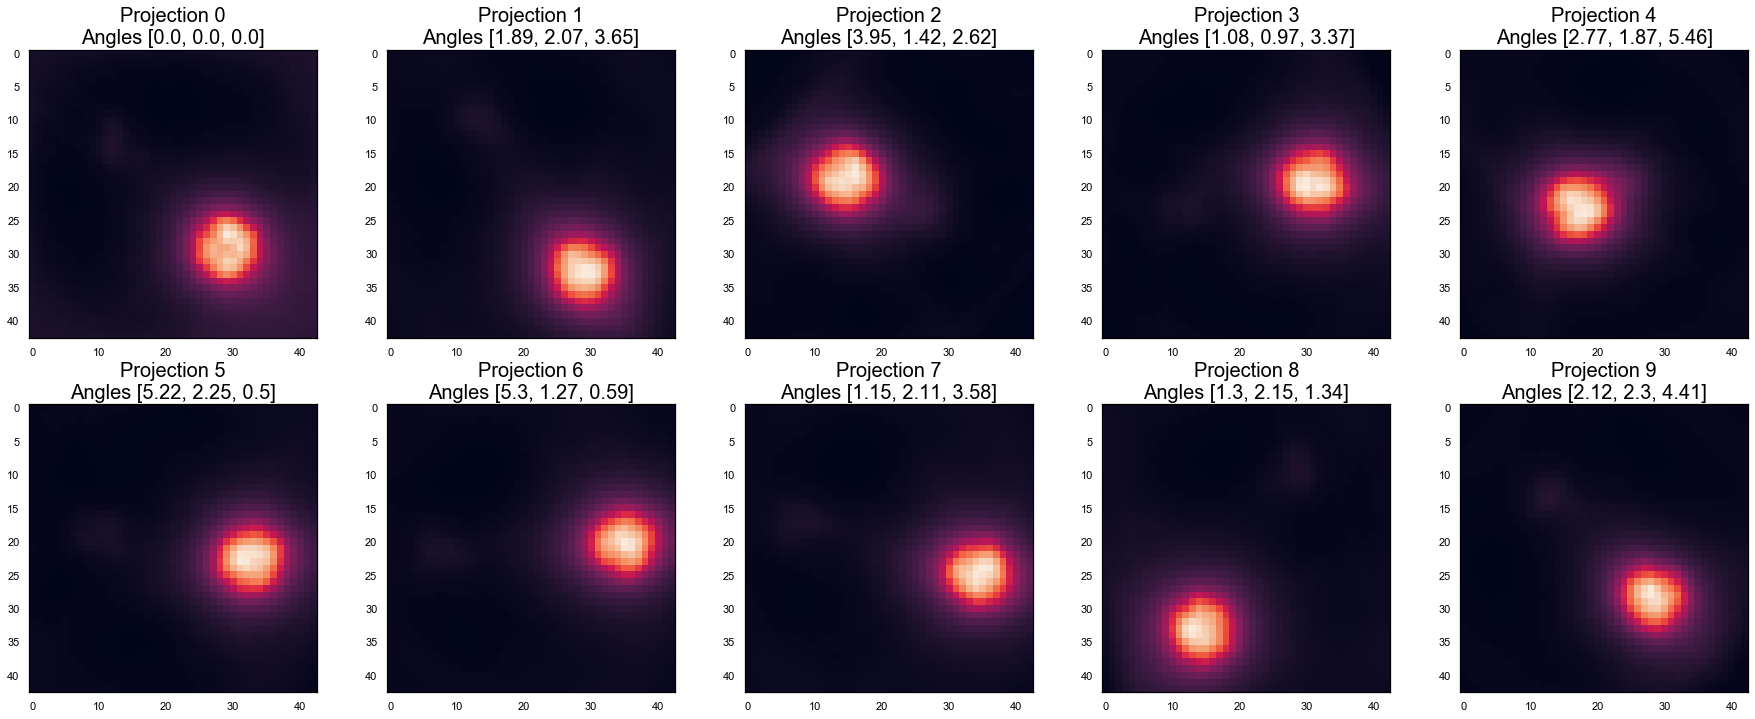

The 51-th iteration


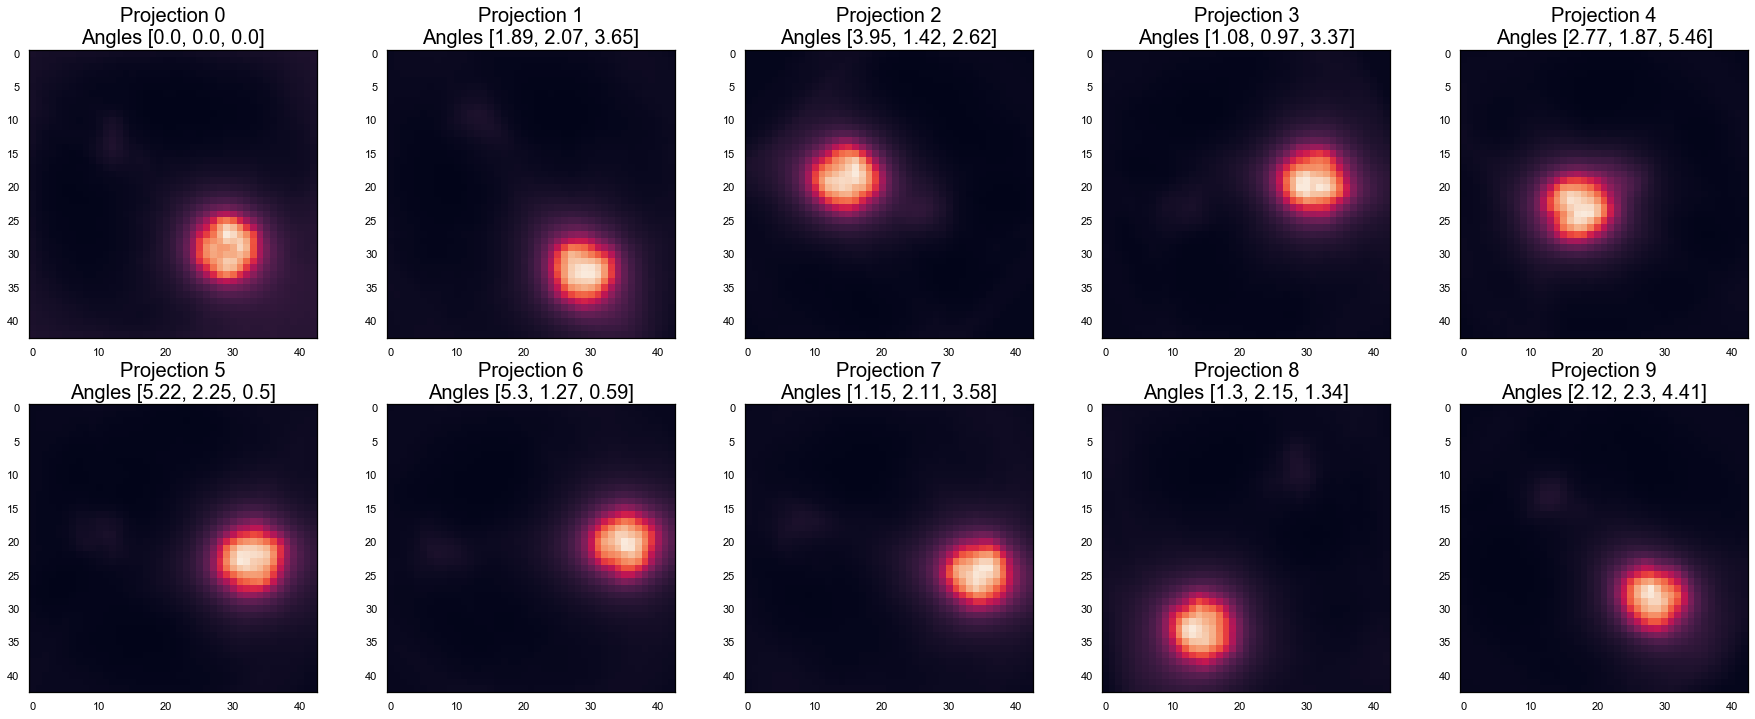

The 101-th iteration


The 151-th iteration


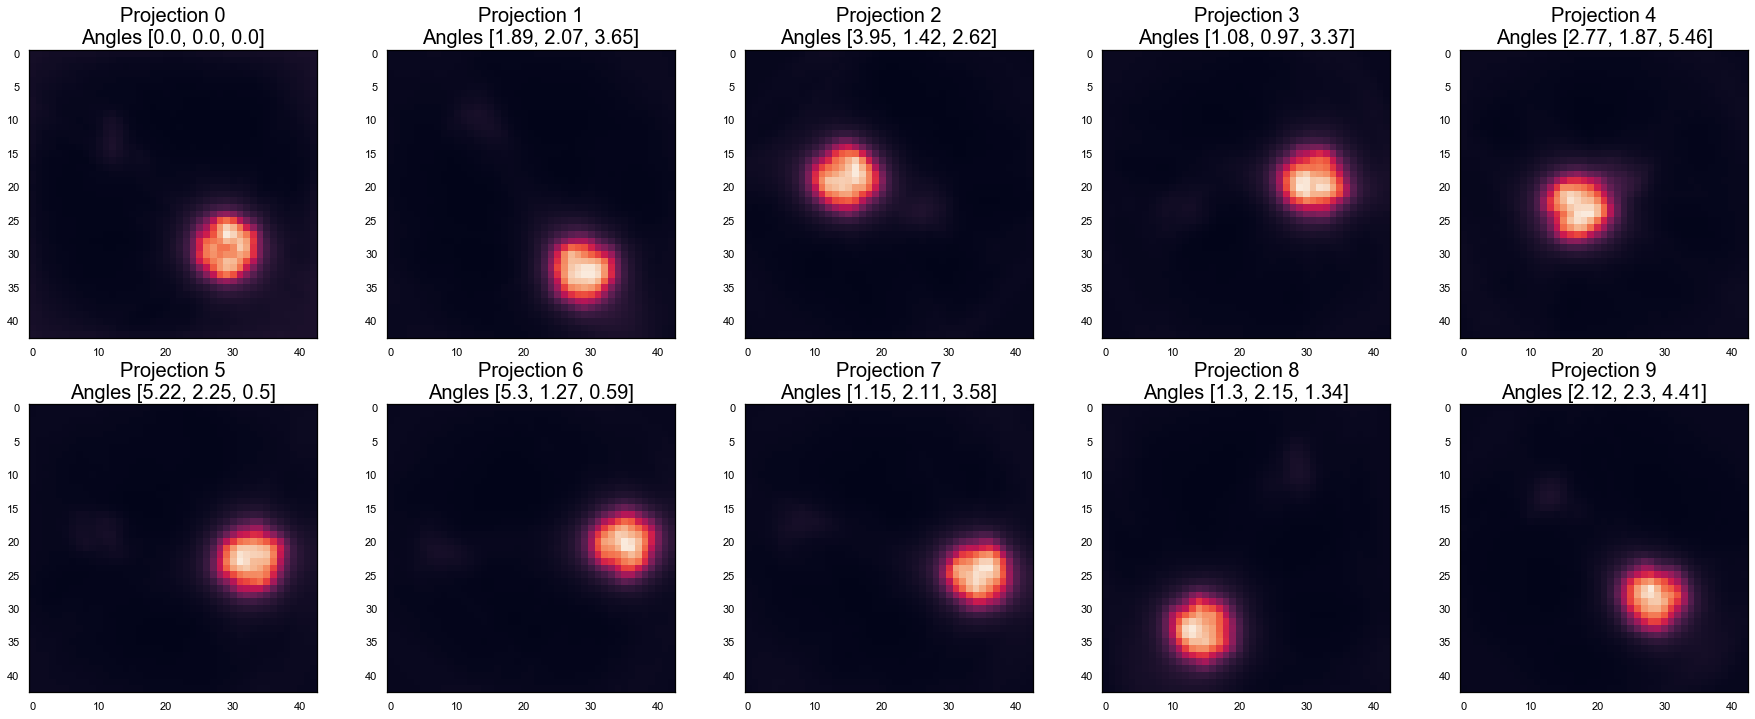

The 201-th iteration


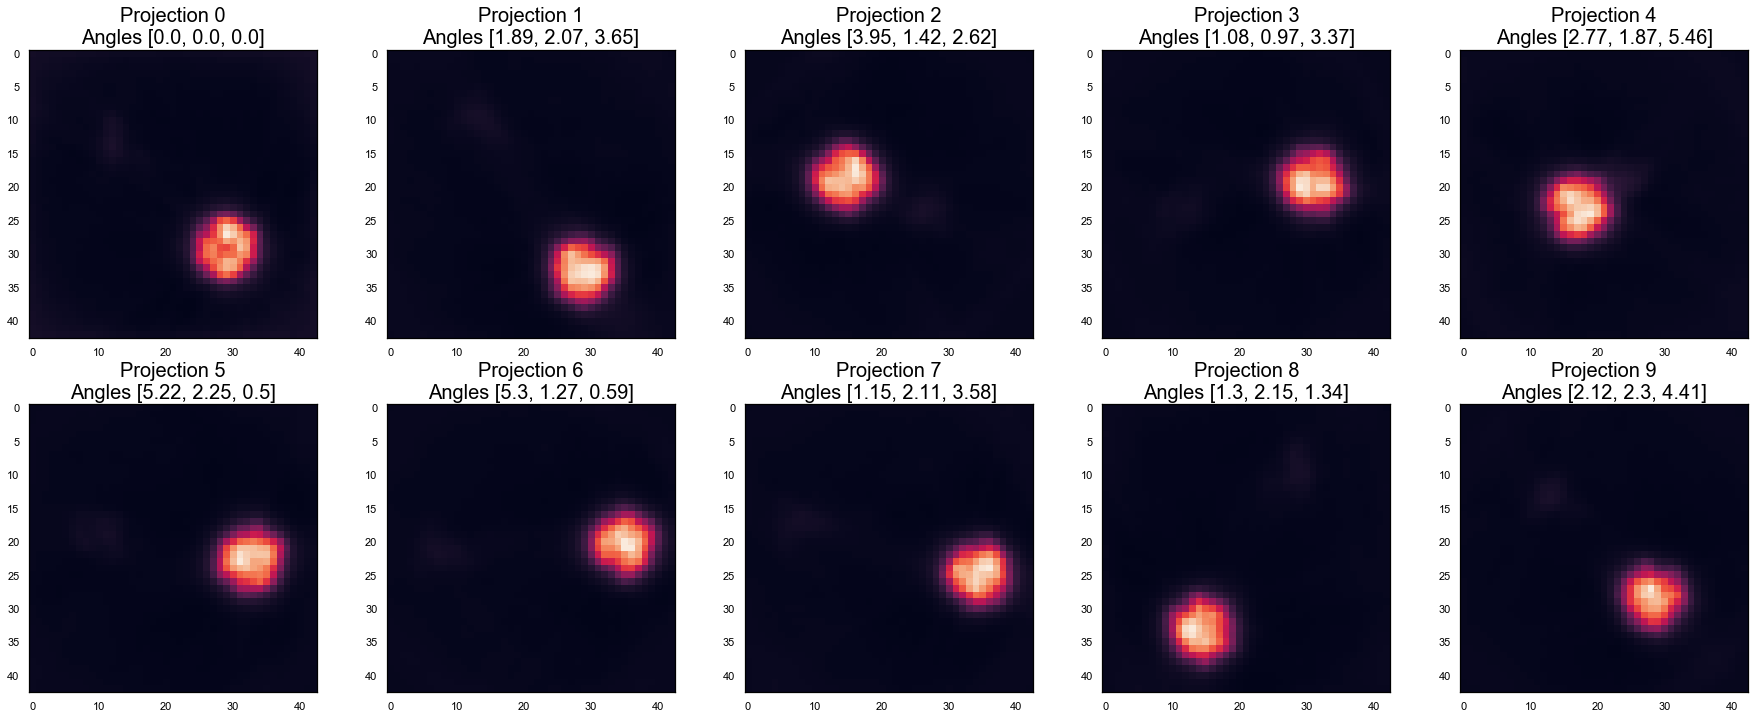

In [17]:



_, num_image , n_component = 116, 5000 , 1
angles2 = angles2[:num_image]
new_projection = new_projection[:num_image]
print('input noised image ')
plot_projections(new_projection[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

P3R = PCA_3d_Recon(ProjSize1, num_image, n_component)
P3R.Au_s(angles2)

P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)

In [18]:
#P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)


(43, 43, 43)
43
(5000, 1849, 2)
start fitting
The 0-th iteration
Q -326931734.87625116


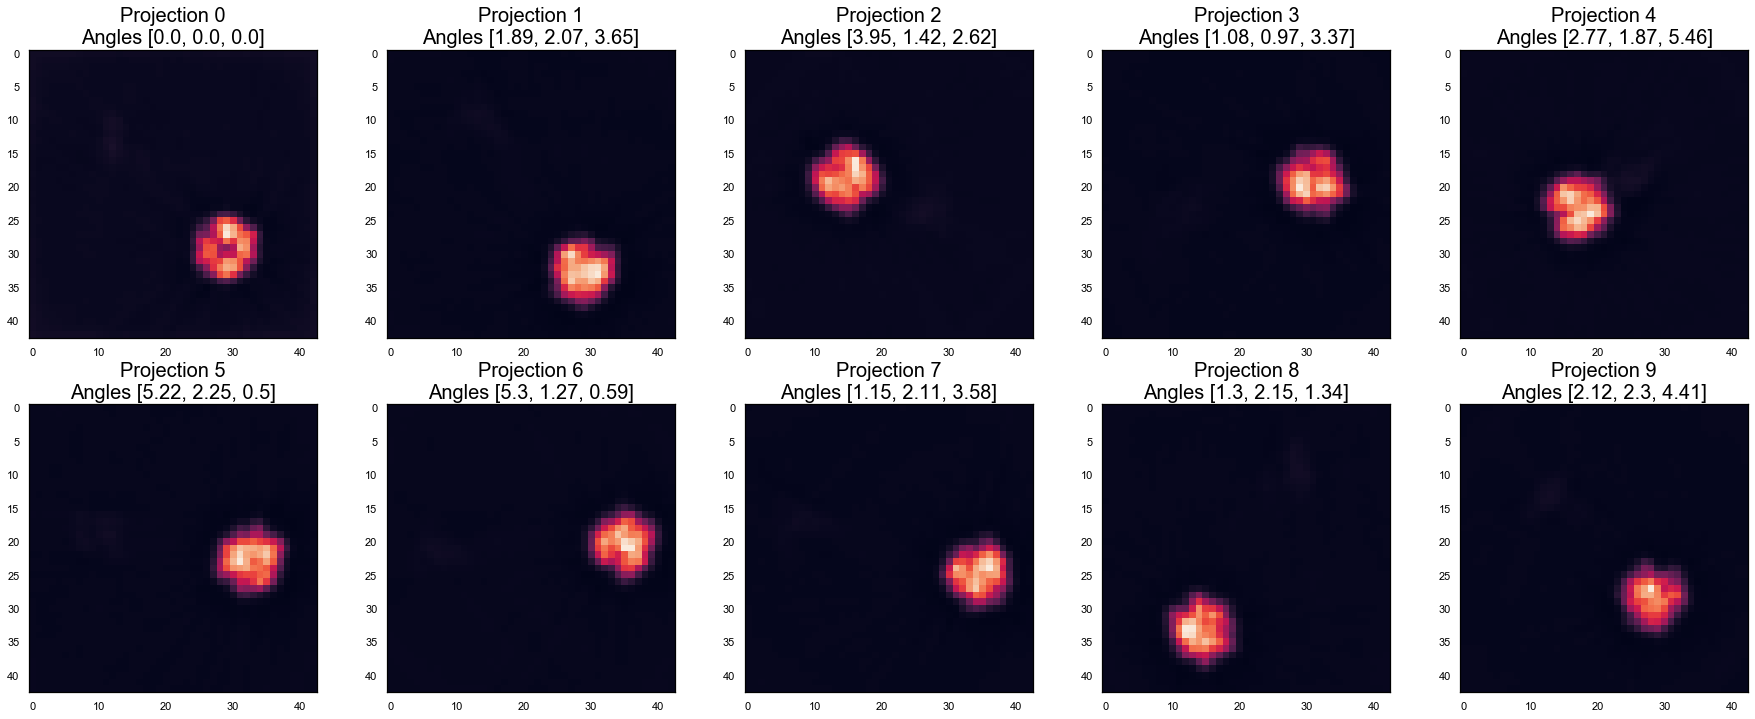

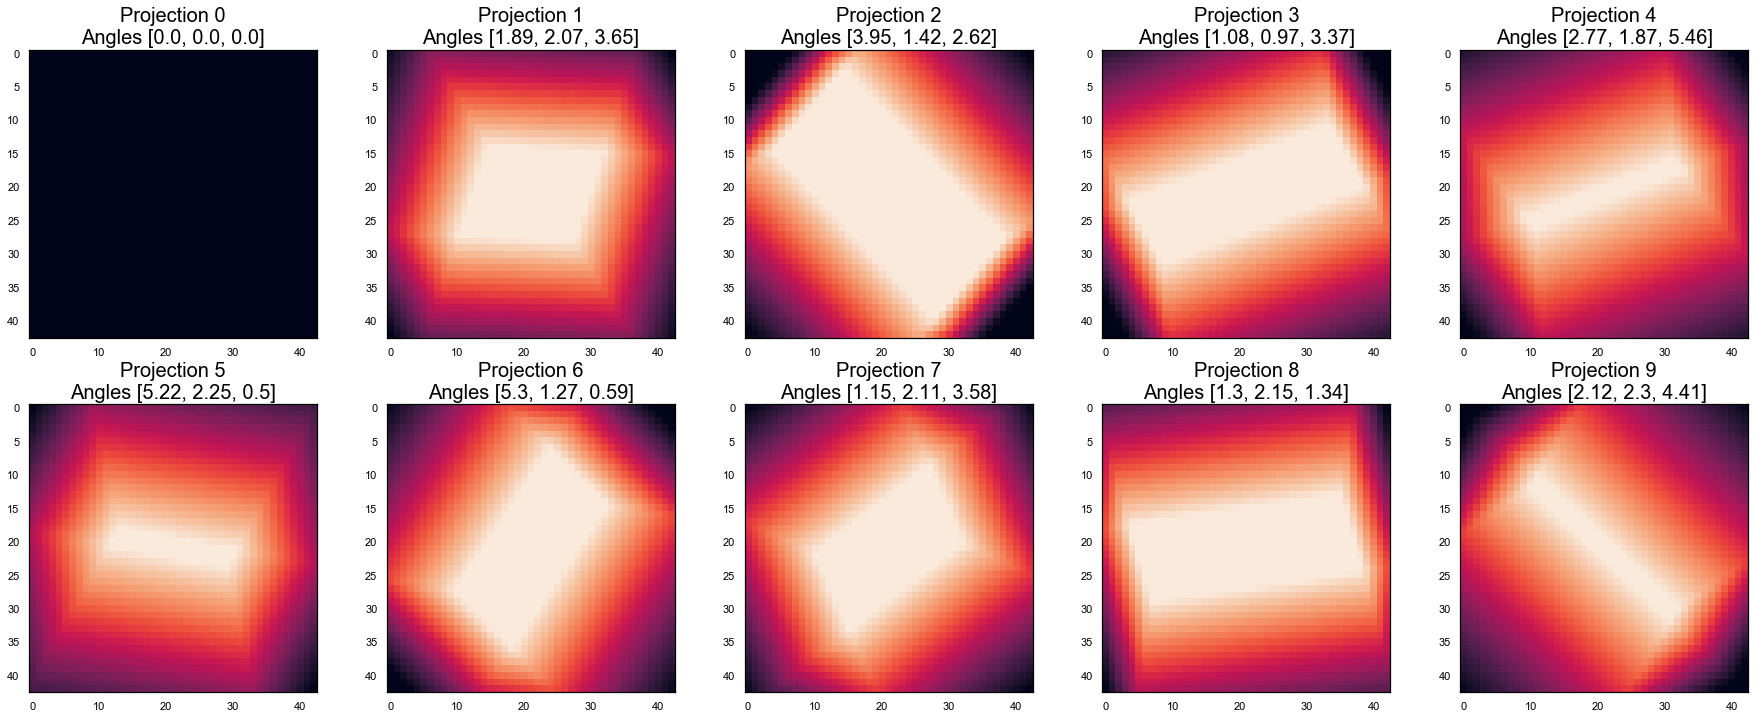

Q 6609084.132119049
delta Q 333540819.0083702
The 1-th iteration


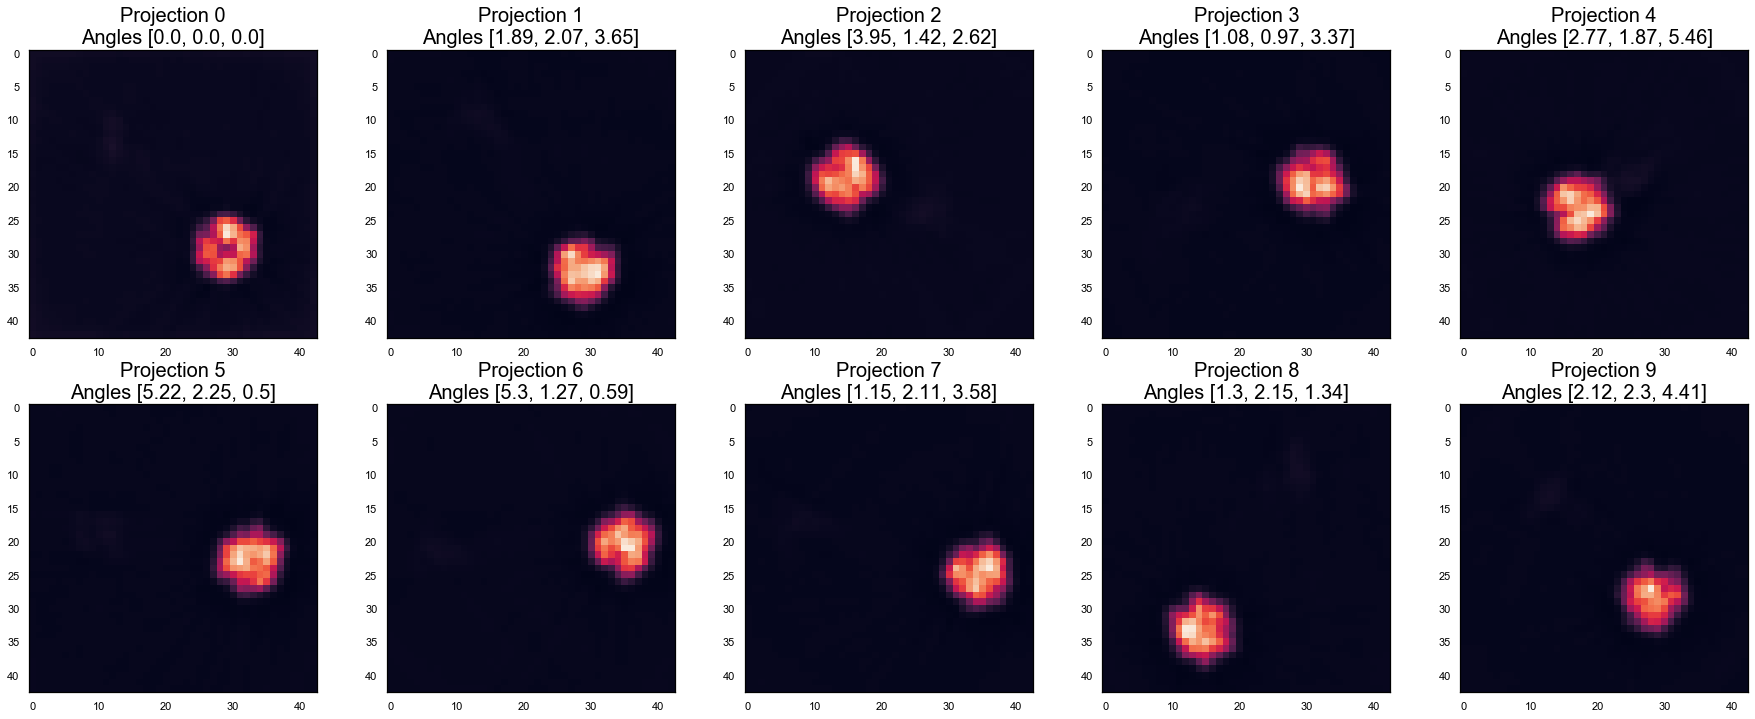

Q 6609084.132119049
delta Q 0.0
Q -1995970.876694354
delta Q -8605055.008813404
Q -2449779.2595763383
delta Q -453808.38288198435
Q -2920602.8882317897
delta Q -470823.62865545135
Q -3407671.4412297467
delta Q -487068.552997957
Q -3911084.059325398
delta Q -503412.61809565127
Q -4430970.89643245
delta Q -519886.8371070521
Q -4967512.345530738
delta Q -536541.4490982881
Q -5520941.160280361
delta Q -553428.8147496227
Q -6091546.183789815
delta Q -570605.023509454
Q -6679676.446920153
delta Q -588130.2631303379
Q -7285746.441130943
delta Q -606069.9942107899
Q -7910241.574089949
delta Q -624495.1329590064
Q -8553726.445135374
delta Q -643484.8710454246
Q -9216851.85360176
delta Q -663125.4084663857
Q -9900367.46913238
delta Q -683515.6155306213
Q -10605133.791351488
delta Q -704766.3222191073
Q -11332136.581925252
delta Q -727002.7905737646
Q -12082507.250084616
delta Q -750370.6681593638
Q -12857545.567433743
delta Q -775038.3173491266
Q -13658746.675386243
delta Q -801201.1079524998
Q 

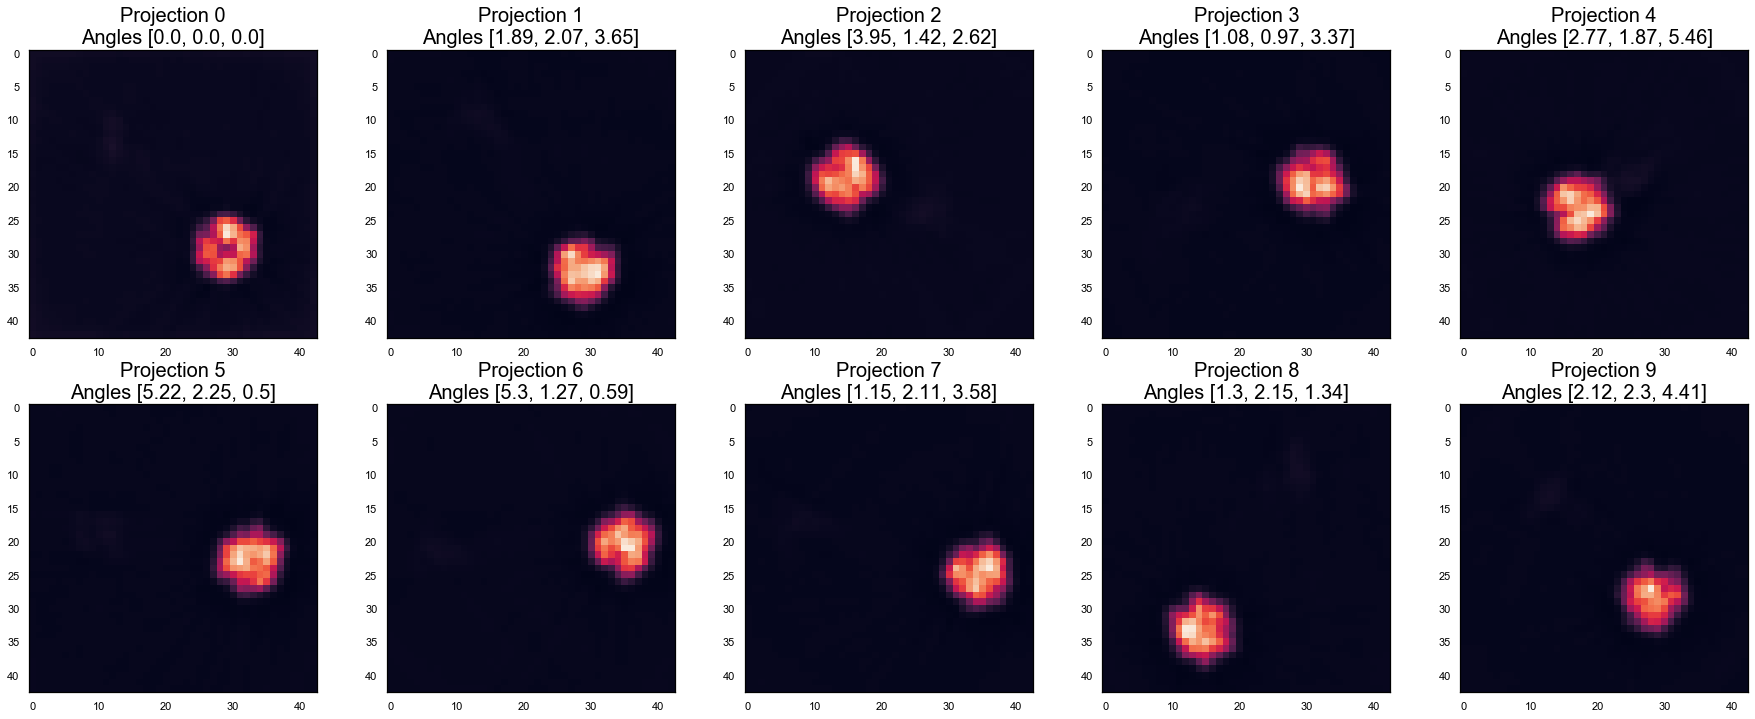

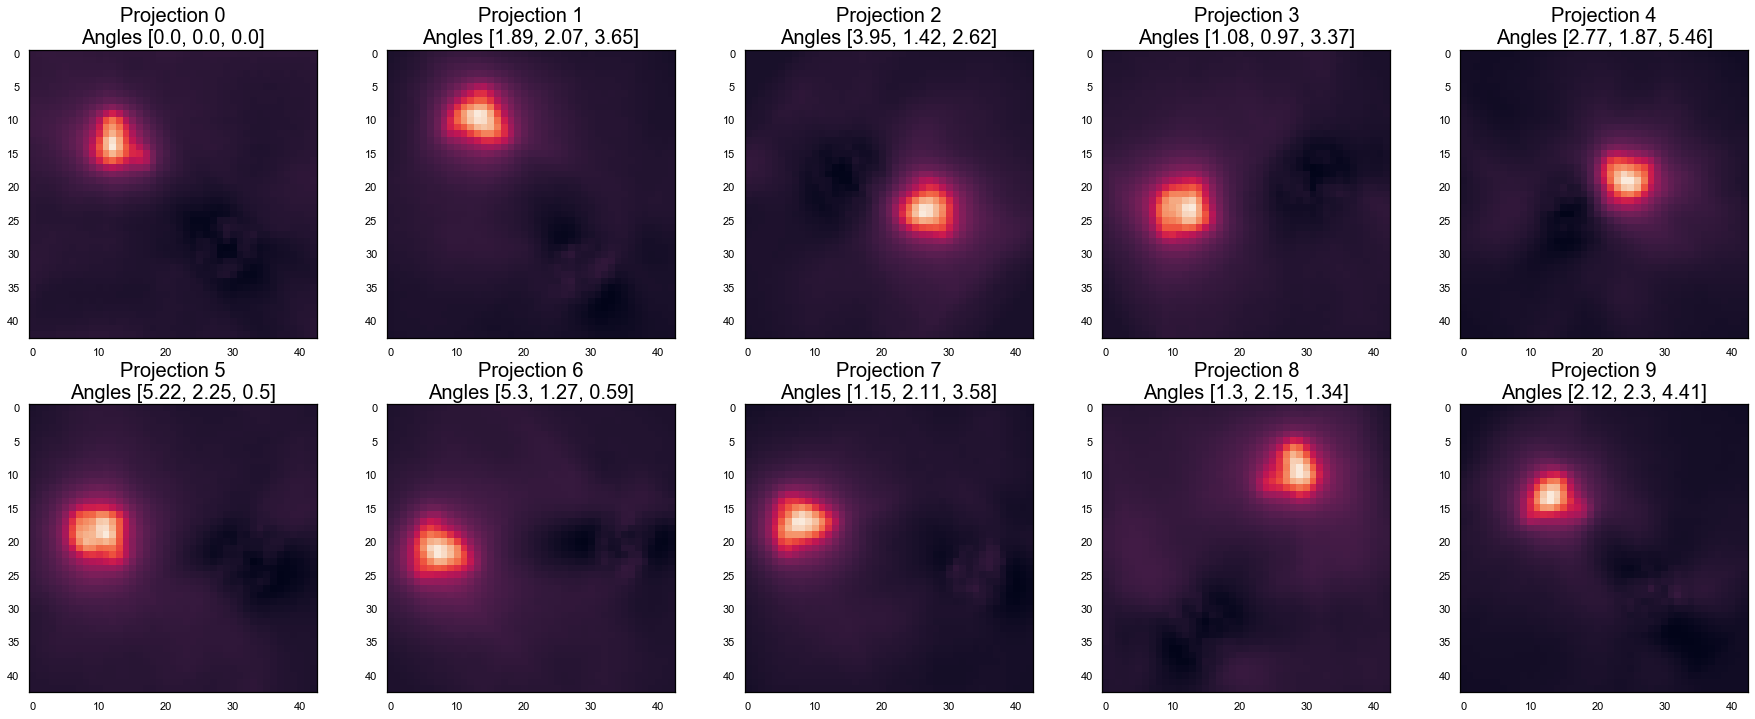

Q -82894264.07538031
delta Q 0.0
Q -84715512.22957745
delta Q -1821248.1541971415
Q -86499791.75218885
delta Q -1784279.5226113945
Q -88252482.78151803
delta Q -1752691.0293291807
Q -89978028.02568568
delta Q -1725545.2441676557
Q -91680154.15675898
delta Q -1702126.131073296
Q -93362029.02167986
delta Q -1681874.8649208844
Q -95026379.74271697
delta Q -1664350.7210371047
Q -96675574.46194215
delta Q -1649194.7192251831
Q -98311691.38280705
delta Q -1636116.920864895
Q -99936571.42621711
delta Q -1624880.0434100628
Q -101551854.84277901
delta Q -1615283.4165619016
Q -103159015.51417224
delta Q -1607160.6713932306
Q -104759388.05059043
delta Q -1600372.5364181846
Q -106354183.75691895
delta Q -1594795.7063285261
Q -107944515.26366074
delta Q -1590331.506741792
Q -109531405.92012283
delta Q -1586890.6564620882
Q -111115801.42693456
delta Q -1584395.506811723
Q -112698583.44361123
delta Q -1582782.0166766793
Q -114280573.34980911
delta Q -1581989.9061978757
Q -115862542.26107906
delta Q -

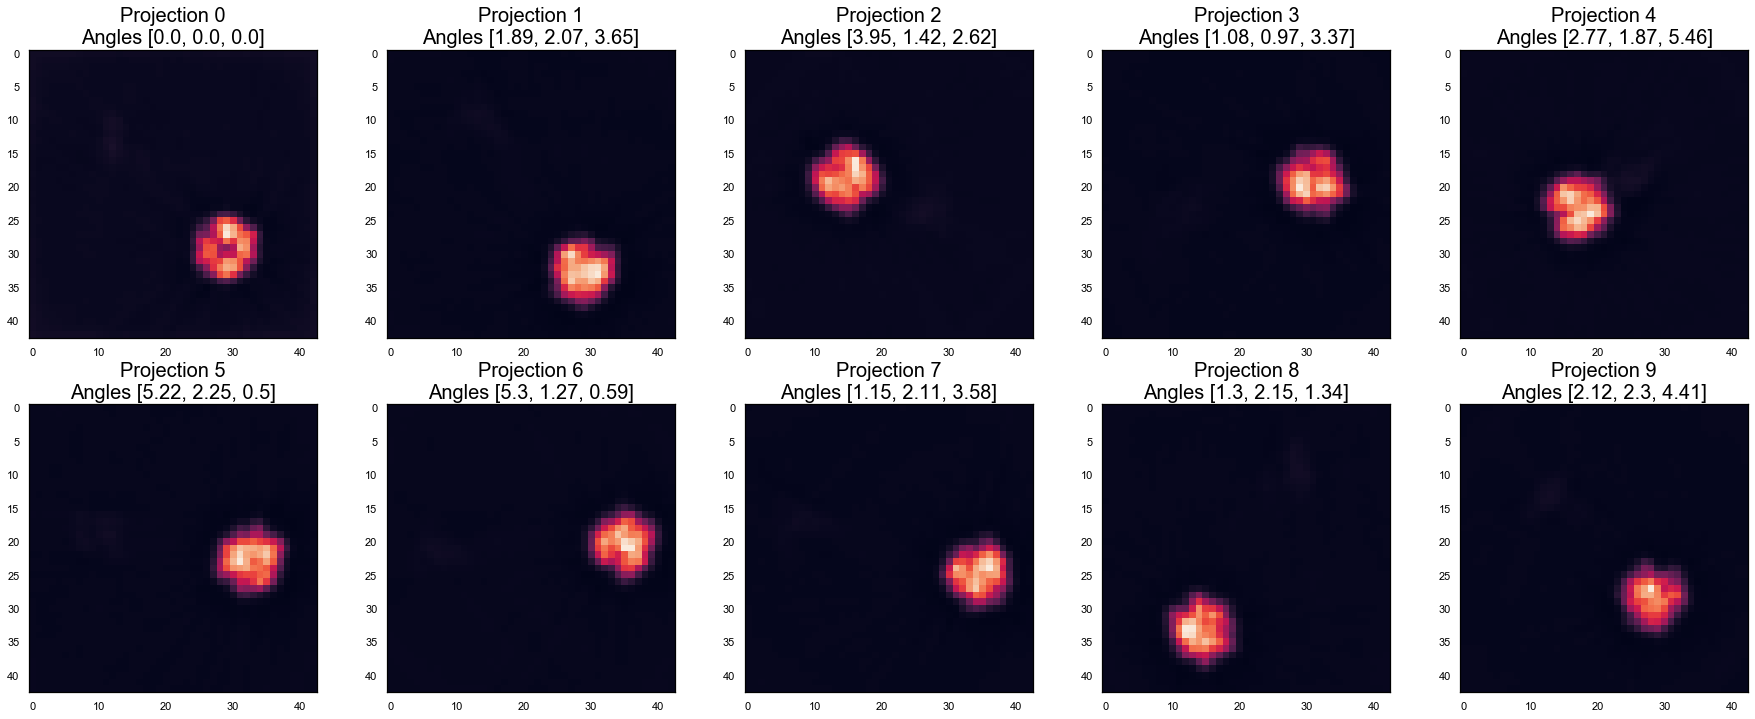

Q -166106490.73632792
delta Q 0.0
Q -167950951.7604058
delta Q -1844461.0240778923
Q -169810899.85092
delta Q -1859948.090514183
Q -171686754.6563279
delta Q -1875854.8054079115
Q -173578935.27203253
delta Q -1892180.6157046258
Q -175487860.5036958
delta Q -1908925.231663257
Q -177413951.76445144
delta Q -1926091.2607556581
Q -179357629.52372995
delta Q -1943677.759278506
Q -181319313.0574149
delta Q -1961683.5336849391
Q -183299428.6373356
delta Q -1980115.5799207091
Q -185298396.01817265
delta Q -1998967.380837053
Q -187316634.47766784
delta Q -2018238.4594951868
Q -189354568.05359885
delta Q -2037933.5759310126
Q -191412611.26072308
delta Q -2058043.2071242332
Q -193491187.82040733
delta Q -2078576.5596842468
Q -195590711.36519155
delta Q -2099523.544784218
Q -197711594.17241287
delta Q -2120882.8072213233
Q -199854247.90432456
delta Q -2142653.731911689
Q -202019075.0037919
delta Q -2164827.099467337
Q -204206481.22841525
delta Q -2187406.2246233523
Q -206416858.0354505
delta Q -22

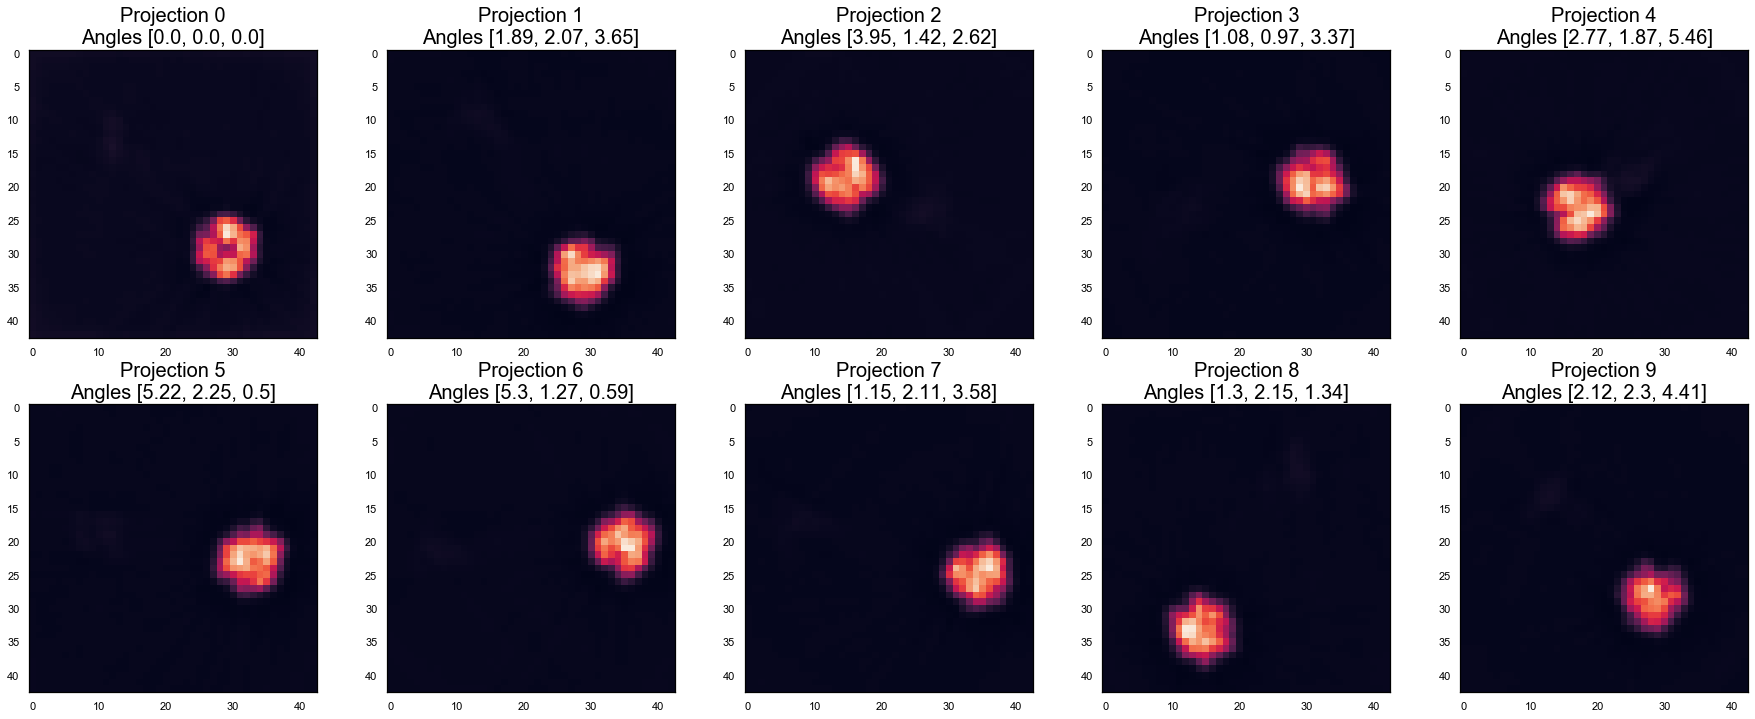

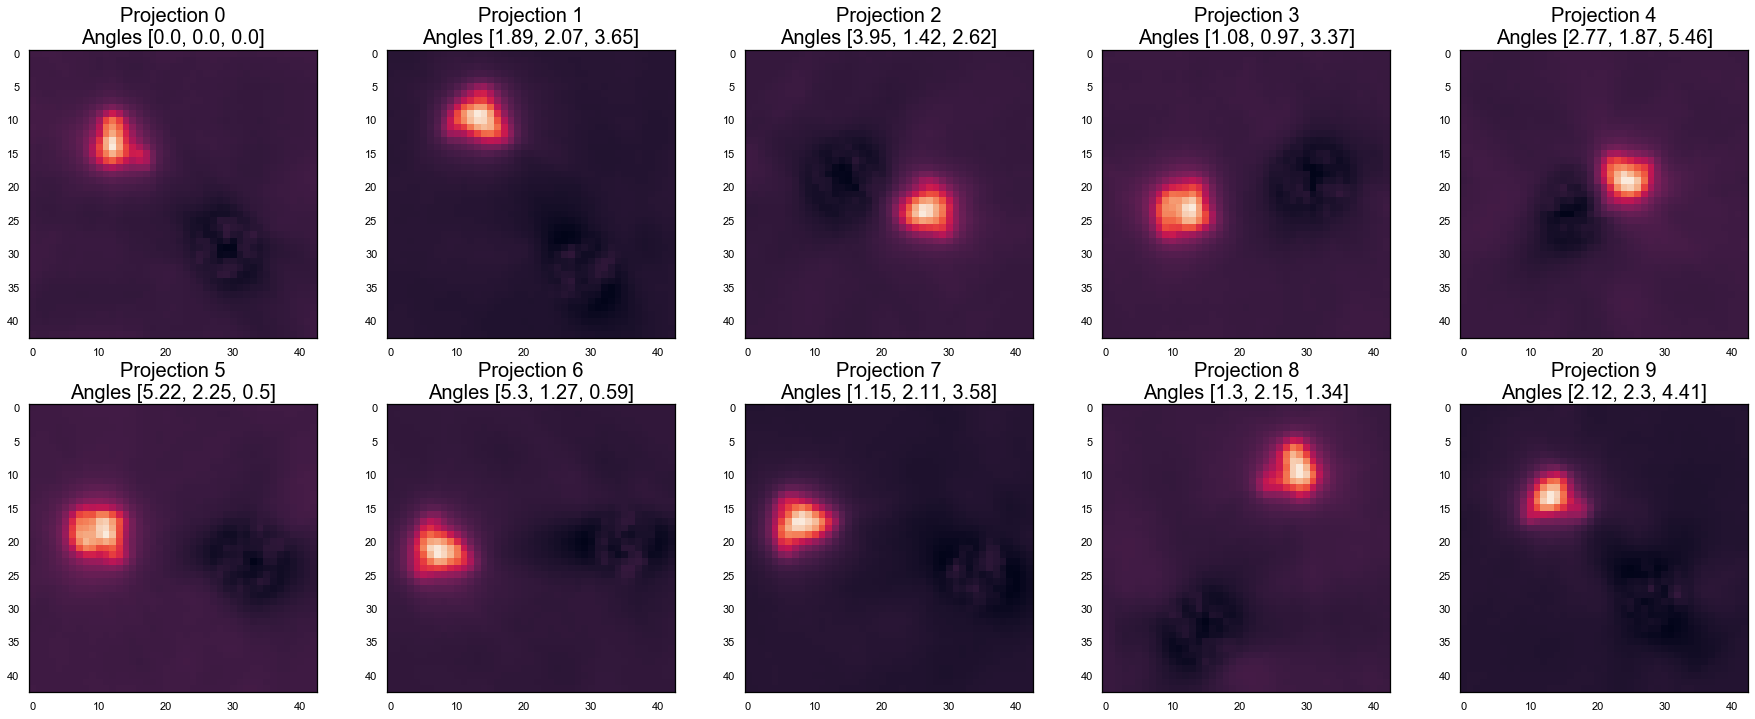

Q -284830131.1740612
delta Q 0.0
Q -287864535.9267088
delta Q -3034404.7526476383
Q -290924501.45268446
delta Q -3059965.5259756446
Q -294009570.7463025
delta Q -3085069.2936180234
Q -297119248.69491094
delta Q -3109677.948608458
Q -300253006.4134532
delta Q -3133757.718542278
Q -303410271.72303194
delta Q -3157265.3095787168
Q -306590435.95190334
delta Q -3180164.228871405
Q -309792853.0362549
delta Q -3202417.0843515396
Q -313016841.49662733
delta Q -3223988.460372448
Q -316261687.61765814
delta Q -3244846.1210308075
Q -319526641.6461741
delta Q -3264954.028515935
Q -322810921.6672924
delta Q -3284280.021118343
Q -326113721.69761103
delta Q -3302800.030318618
Q -329434202.6428207
delta Q -3320480.945209682
Q -332771496.06370825
delta Q -3337293.42088753
Q -336124719.75078535
delta Q -3353223.687077105
Q -339492959.81591046
delta Q -3368240.0651251078
Q -342875289.4277249
delta Q -3382329.6118144393
Q -346270756.51610917
delta Q -3395467.0883842707
Q -349678404.7656807
delta Q -340764

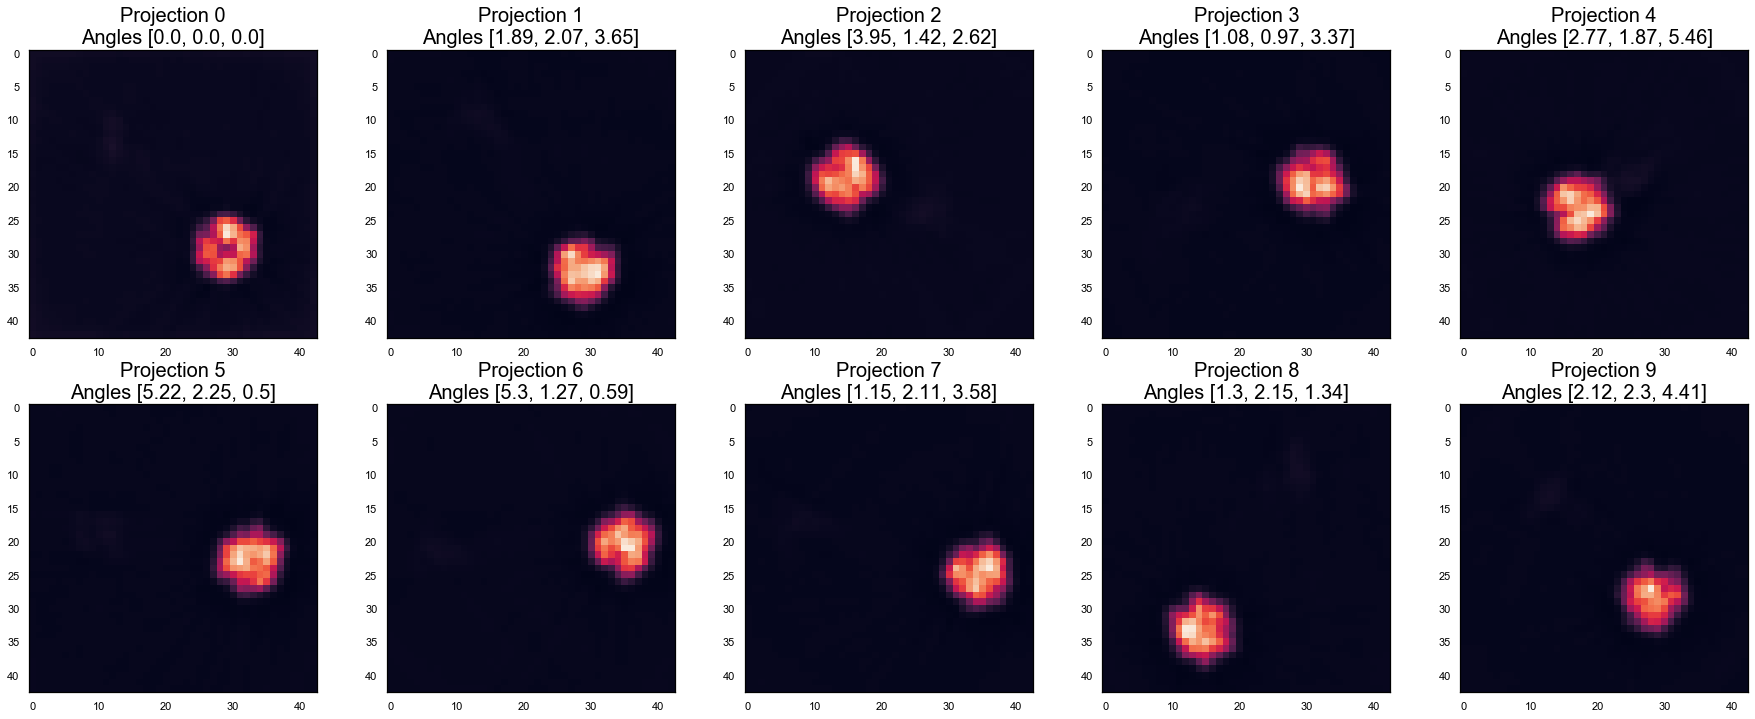

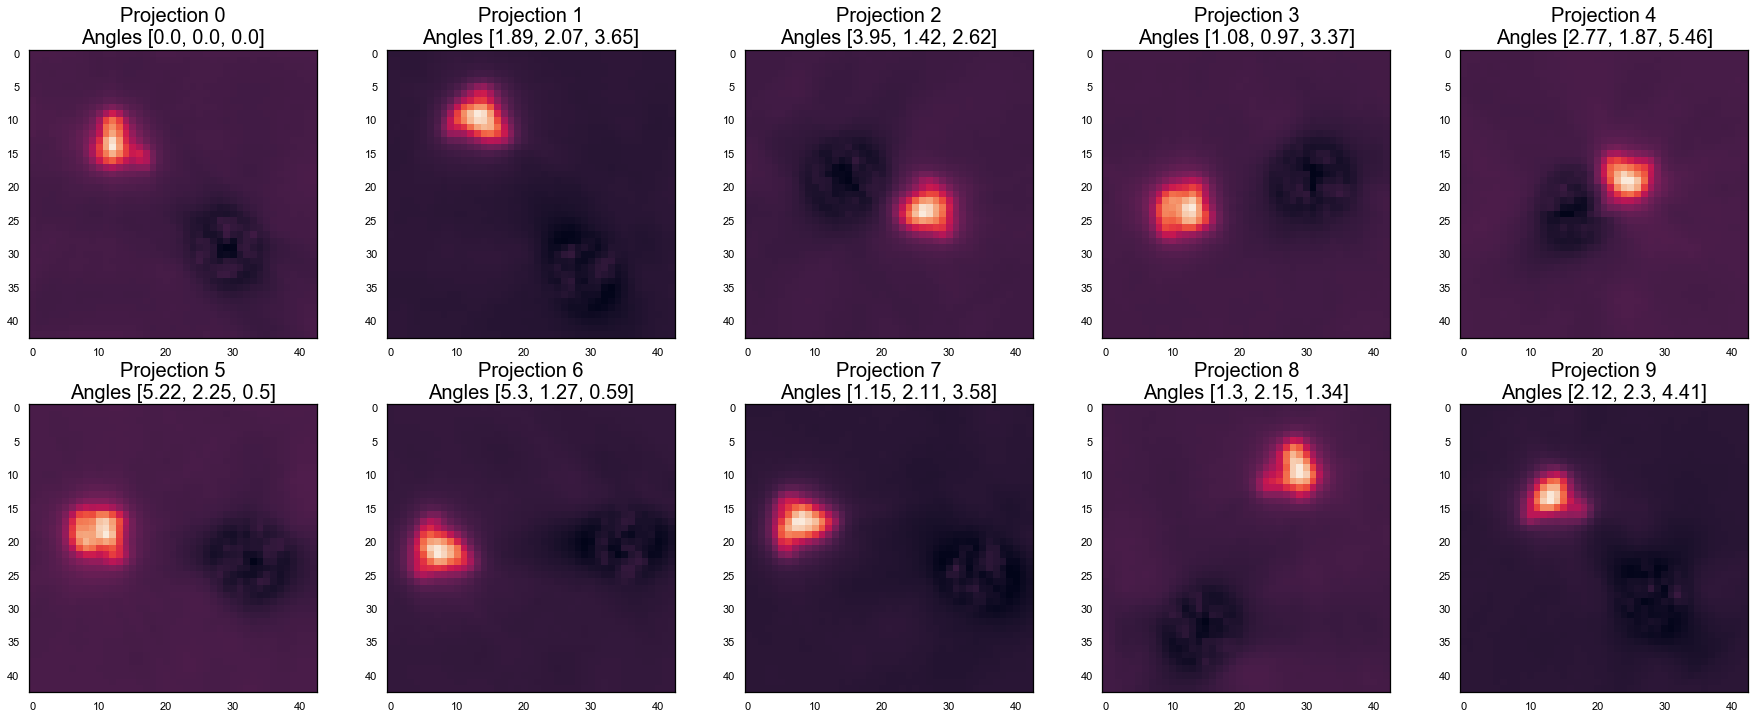

Q -452777231.4010063
delta Q 0.0
Q -456099041.1889199
delta Q -3321809.7879136205
Q -459405929.8605325
delta Q -3306888.6716126204
Q -462697388.00759184
delta Q -3291458.1470593214
Q -465972942.2189772
delta Q -3275554.2113853693
Q -469232132.139634
delta Q -3259189.9206568003
Q -472474525.0443729
delta Q -3242392.904738903
Q -475699720.04251206
delta Q -3225194.998139143
Q -478907322.2769453
delta Q -3207602.2344332337
Q -482096979.58343244
delta Q -3189657.306487143
Q -485268347.97773284
delta Q -3171368.394300401
Q -488421106.4775651
delta Q -3152758.4998322725
Q -491554958.009005
delta Q -3133851.5314399004
Q -494669623.8932043
delta Q -3114665.8841992617
Q -497764847.7084222
delta Q -3095223.815217912
Q -500840396.0175755
delta Q -3075548.3091533184
Q -503896038.0175832
delta Q -3055642.000007689
Q -506931580.76298076
delta Q -3035542.7453975677
Q -509946840.0932262
delta Q -3015259.3302454352
Q -512941643.7584041
delta Q -2994803.6651778817
Q -515915843.7997195
delta Q -2974200.0

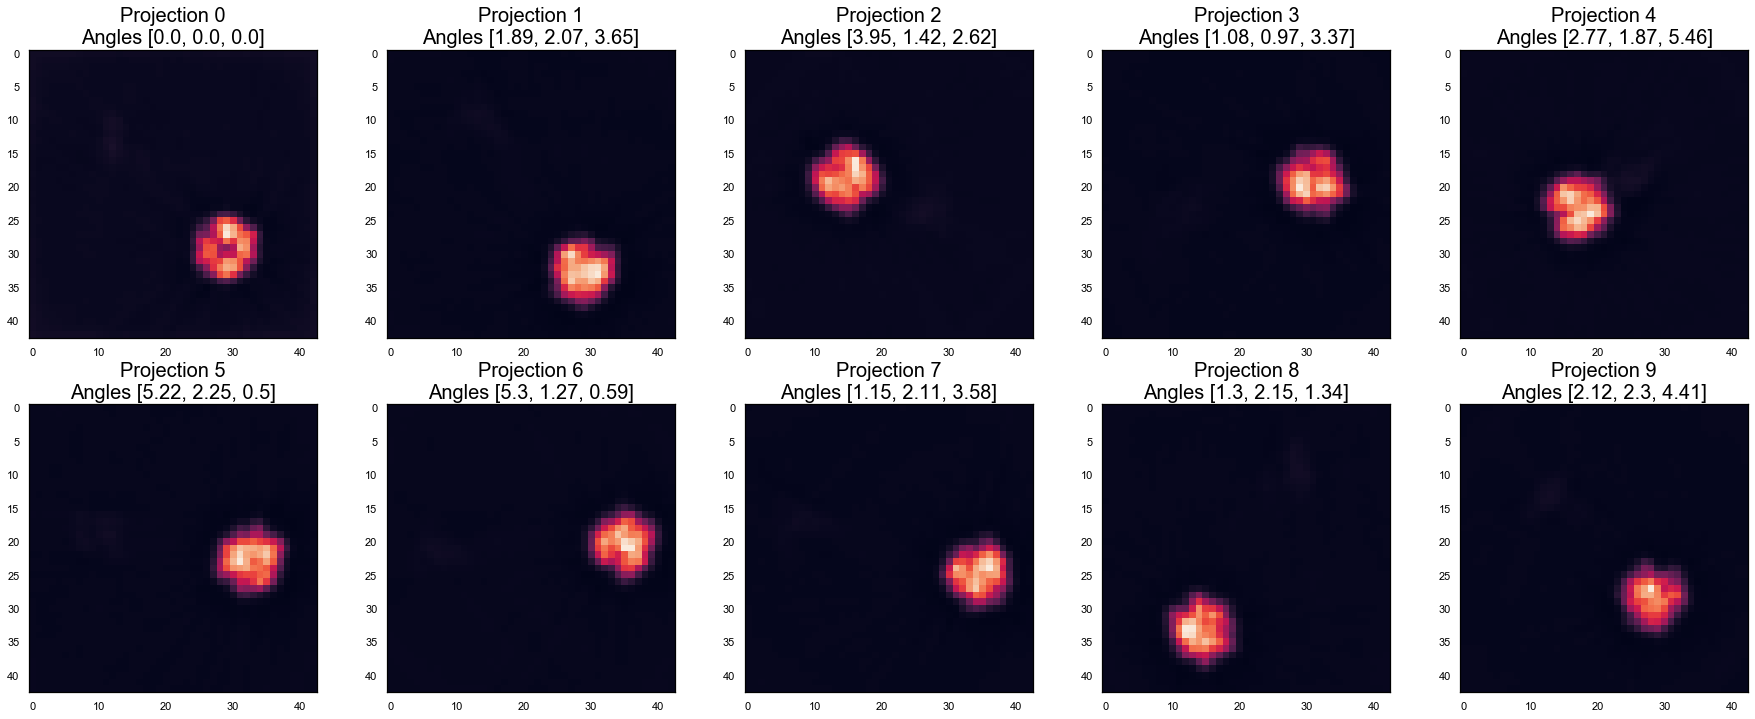

Q -595317470.1164262
delta Q 0.0
Q -597641232.7074019
delta Q -2323762.590975642
Q -599945026.4031812
delta Q -2303793.6957793236
Q -602228970.894275
delta Q -2283944.491093755
Q -604493186.333888
delta Q -2264215.439613104
Q -606737794.4294016
delta Q -2244608.095513582
Q -608962926.3729888
delta Q -2225131.943587184
Q -611168704.4398795
delta Q -2205778.0668907166
Q -613355252.125972
delta Q -2186547.686092496
Q -615522713.2542388
delta Q -2167461.1282668114
Q -617671209.949511
delta Q -2148496.6952722073
Q -619800881.3315467
delta Q -2129671.382035613
Q -621911859.4479222
delta Q -2110978.1163755655
Q -624004285.2626698
delta Q -2092425.814747572
Q -626078295.5709759
delta Q -2074010.308306098
Q -628134027.8774464
delta Q -2055732.3064705133
Q -630171621.3158832
delta Q -2037593.4384367466
Q -632191219.685639
delta Q -2019598.3697558641
Q -634192959.5515404
delta Q -2001739.865901351
Q -636176985.8513932
delta Q -1984026.299852848
Q -638143434.990634
delta Q -1966449.1392407417
Q -6

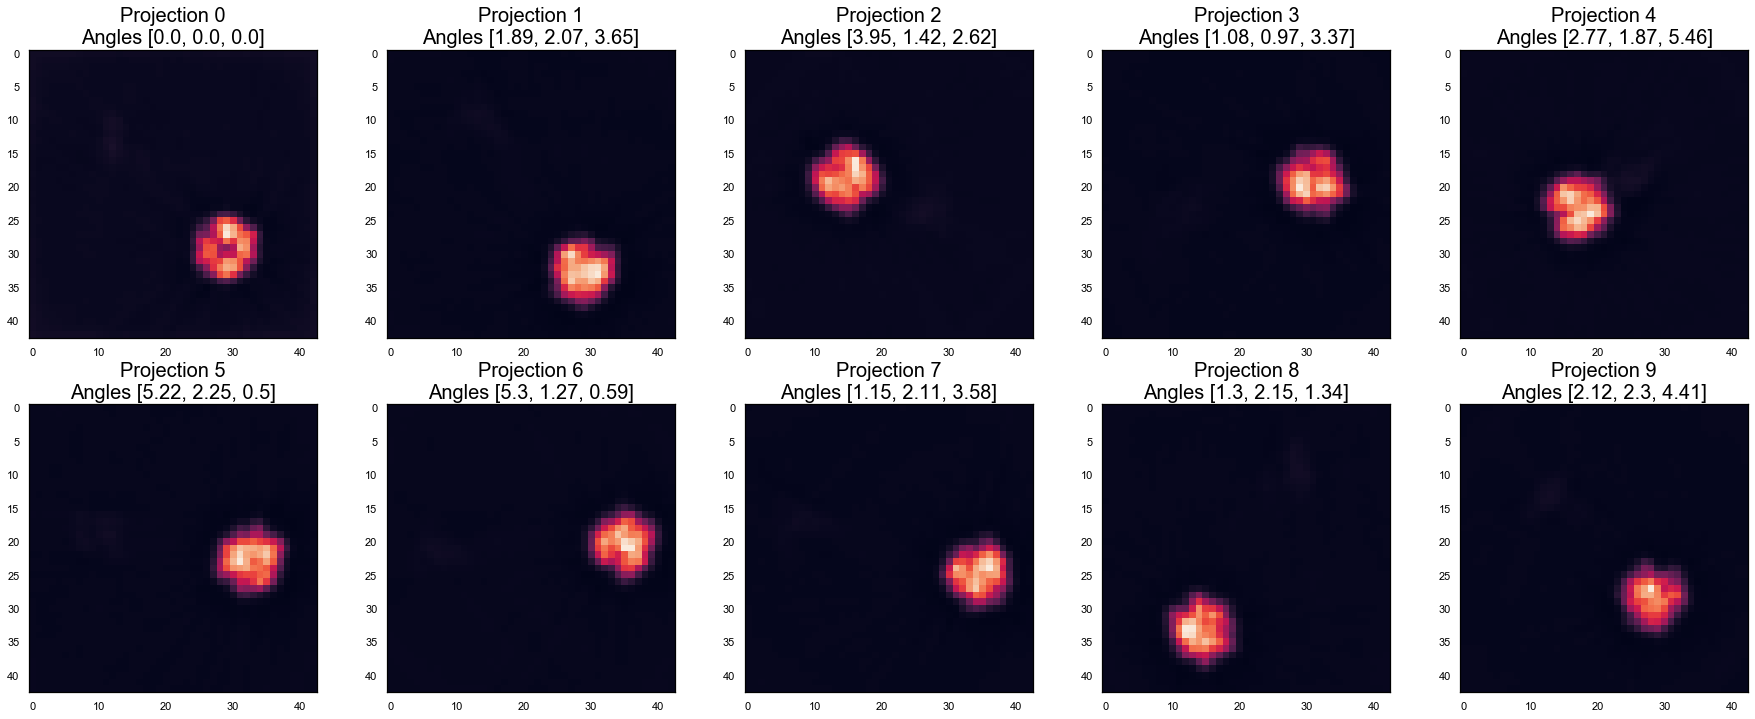

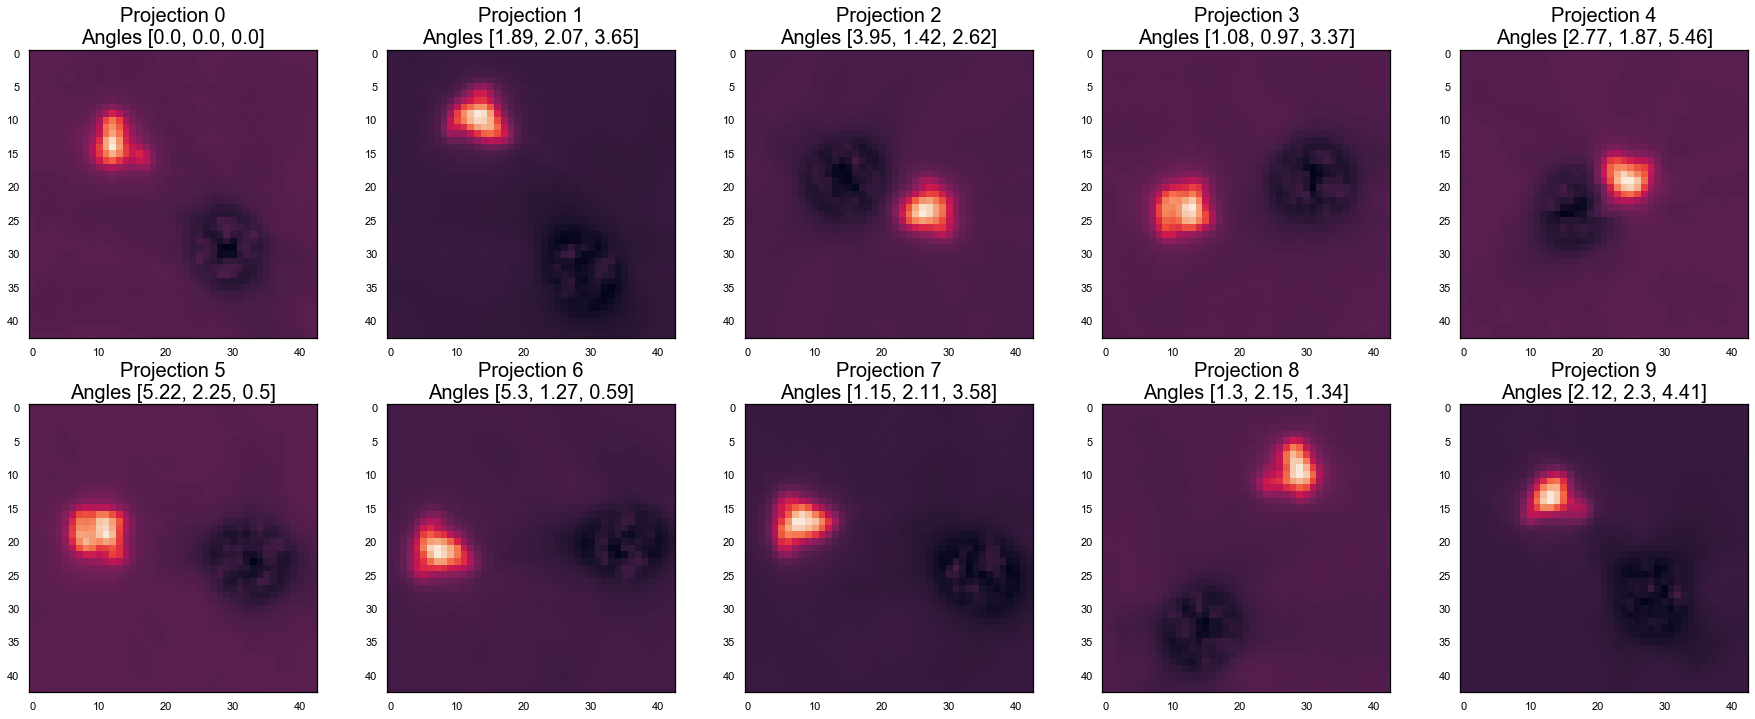

Q -689667369.7853602
delta Q 0.0
Q -691158678.3583922
delta Q -1491308.5730320215
Q -692636809.3666468
delta Q -1478131.008254528
Q -694101889.4231962
delta Q -1465080.05654943
Q -695554042.9209201
delta Q -1452153.497723937
Q -696993394.8221155
delta Q -1439351.901195407
Q -698420062.2581788
delta Q -1426667.4360632896
Q -699834174.543363
delta Q -1414112.285184145
Q -701235850.0883517
delta Q -1401675.5449887514
Q -702625203.6016394
delta Q -1389353.5132876635
Q -704002363.807217
delta Q -1377160.205577612
Q -705367439.935427
delta Q -1365076.1282099485
Q -706720549.0529978
delta Q -1353109.117570877
Q -708061817.3366822
delta Q -1341268.283684373
Q -709391344.3799349
delta Q -1329527.0432527065
Q -710709257.5474731
delta Q -1317913.167538166
Q -712015660.5245004
delta Q -1306402.977027297
Q -713310669.9847604
delta Q -1295009.4602600336
Q -714594391.0123268
delta Q -1283721.027566433
Q -715866938.9167504
delta Q -1272547.9044235945
Q -717128422.7414272
delta Q -1261483.824676752
Q -

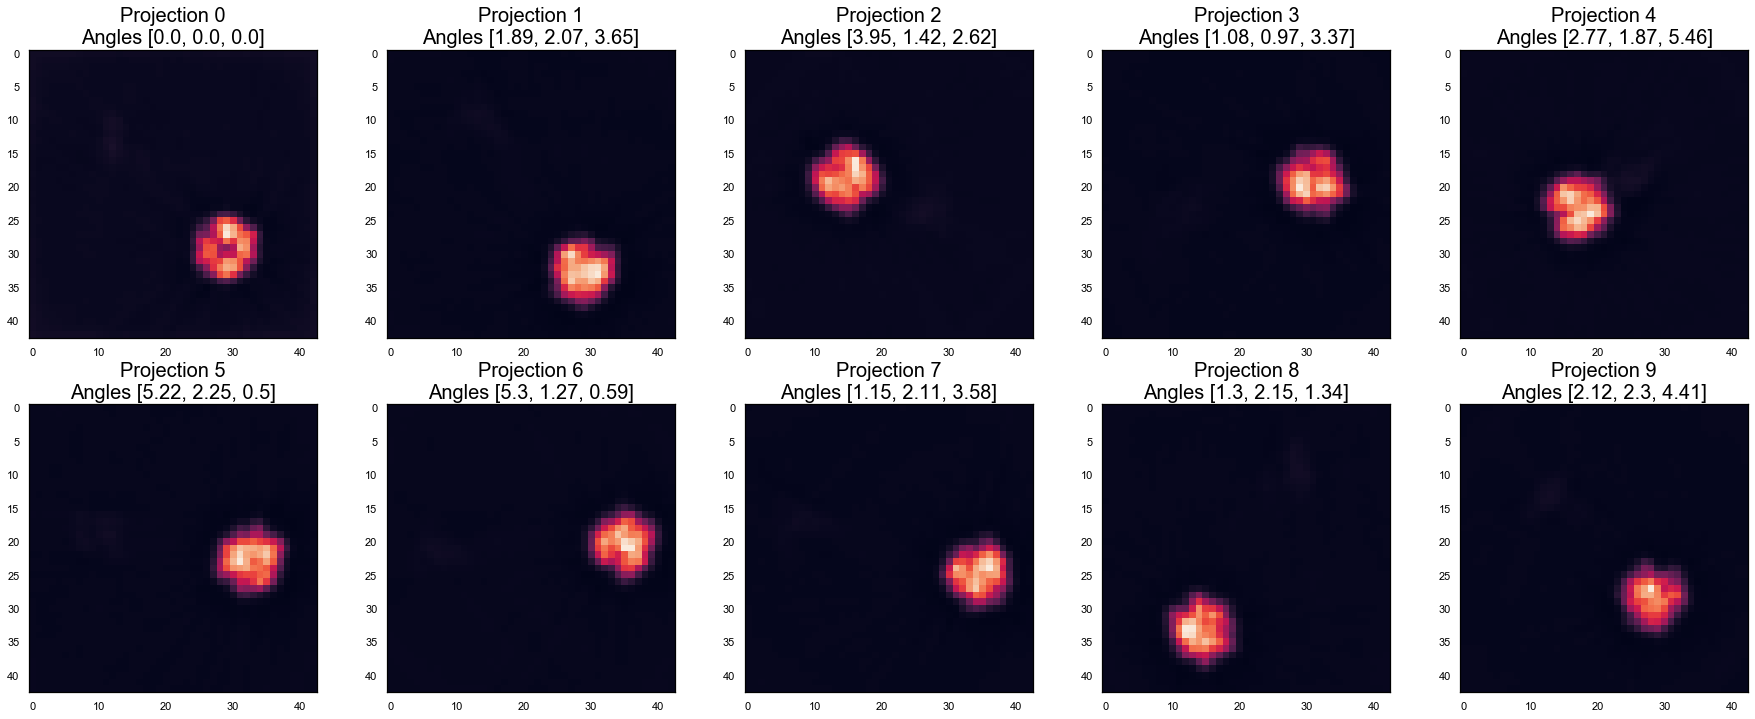

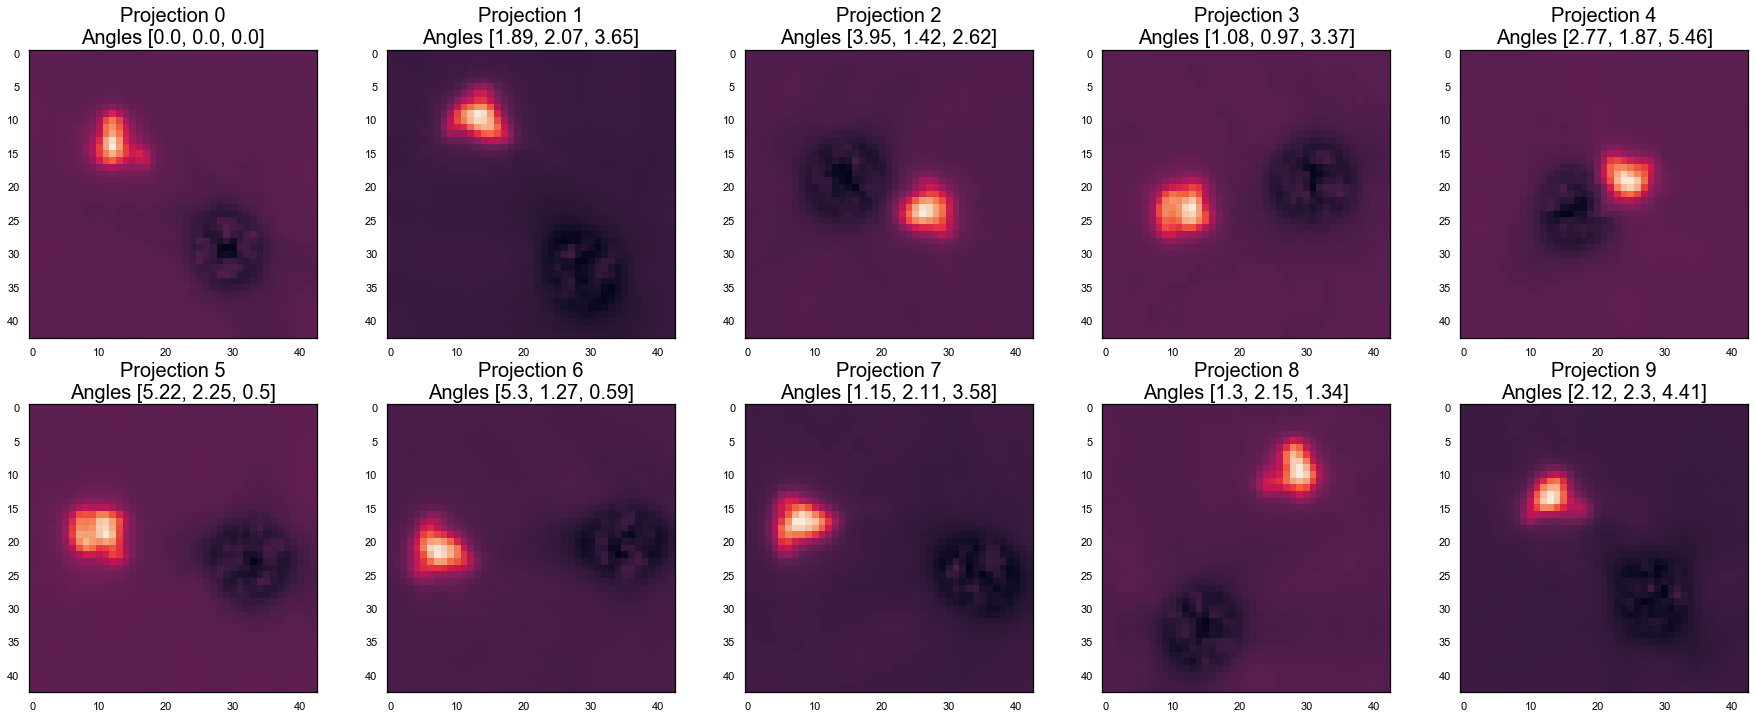

Q -750326825.4282202
delta Q 0.0
Q -751293940.558552
delta Q -967115.1303318739
Q -752252961.932265
delta Q -959021.3737130165
Q -753203967.3560604
delta Q -951005.4237953424
Q -754147045.6477077
delta Q -943078.291647315
Q -755082261.9598972
delta Q -935216.3121894598
Q -756009706.0930498
delta Q -927444.1331526041
Q -756929441.5861981
delta Q -919735.4931483269
Q -757841547.2227206
delta Q -912105.6365225315
Q -758746095.1408049
delta Q -904547.9180842638
Q -759643157.2100886
delta Q -897062.0692837238
Q -760532812.4795938
delta Q -889655.2695051432
Q -761415123.5157847
delta Q -882311.0361909866
Q -762290163.8108032
delta Q -875040.2950184345
Q -763158006.8272555
delta Q -867843.0164523125
Q -764018713.216648
delta Q -860706.3893924952
Q -764872361.1734957
delta Q -853647.9568476677
Q -765719016.0655859
delta Q -846654.8920902014
Q -766558740.4454379
delta Q -839724.3798520565
Q -767391598.7378284
delta Q -832858.2923904657
Q -768217666.1751666
delta Q -826067.437338233
Q -769037002

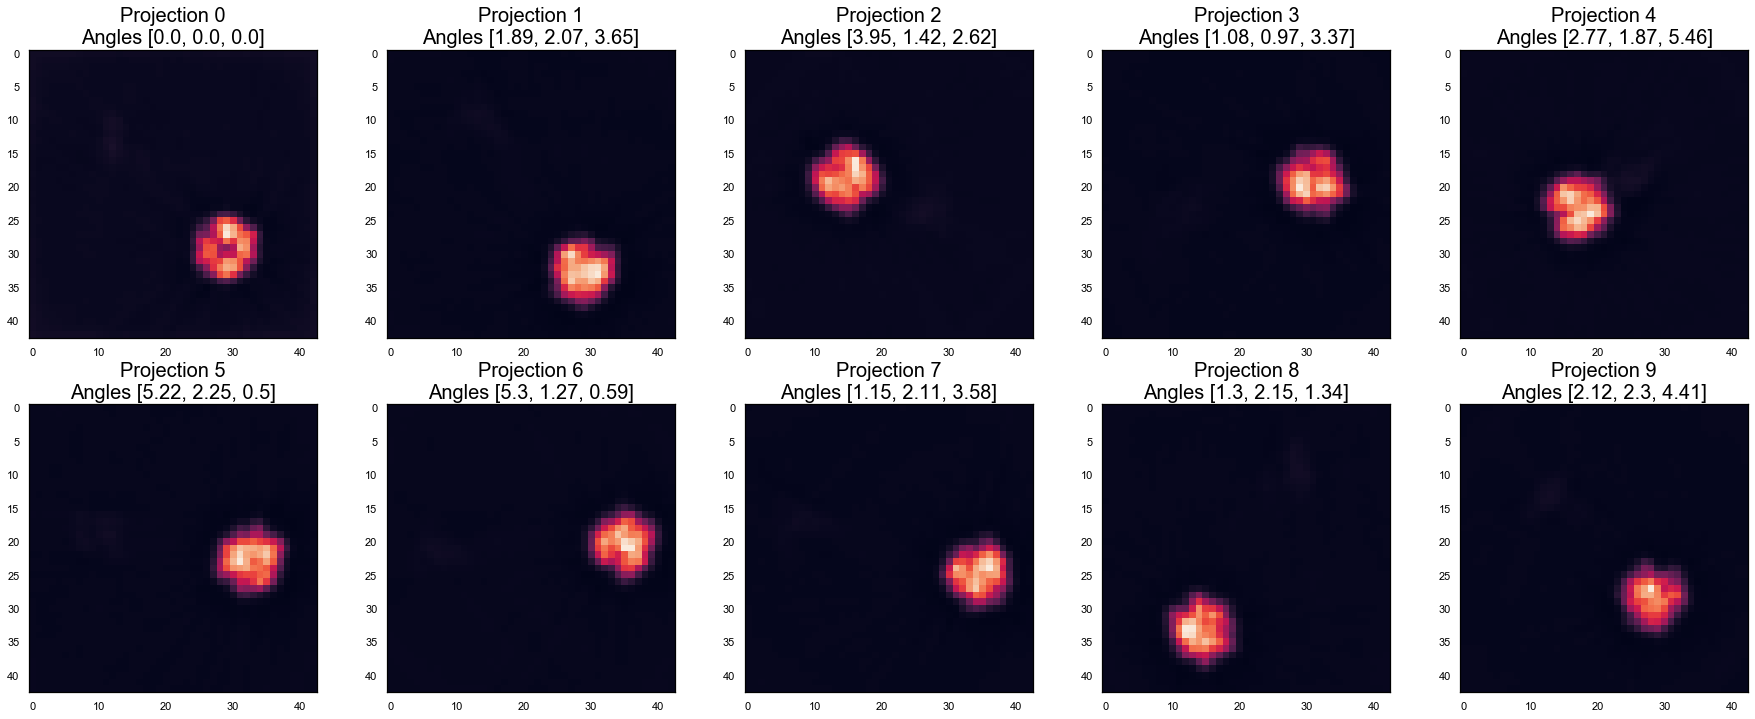

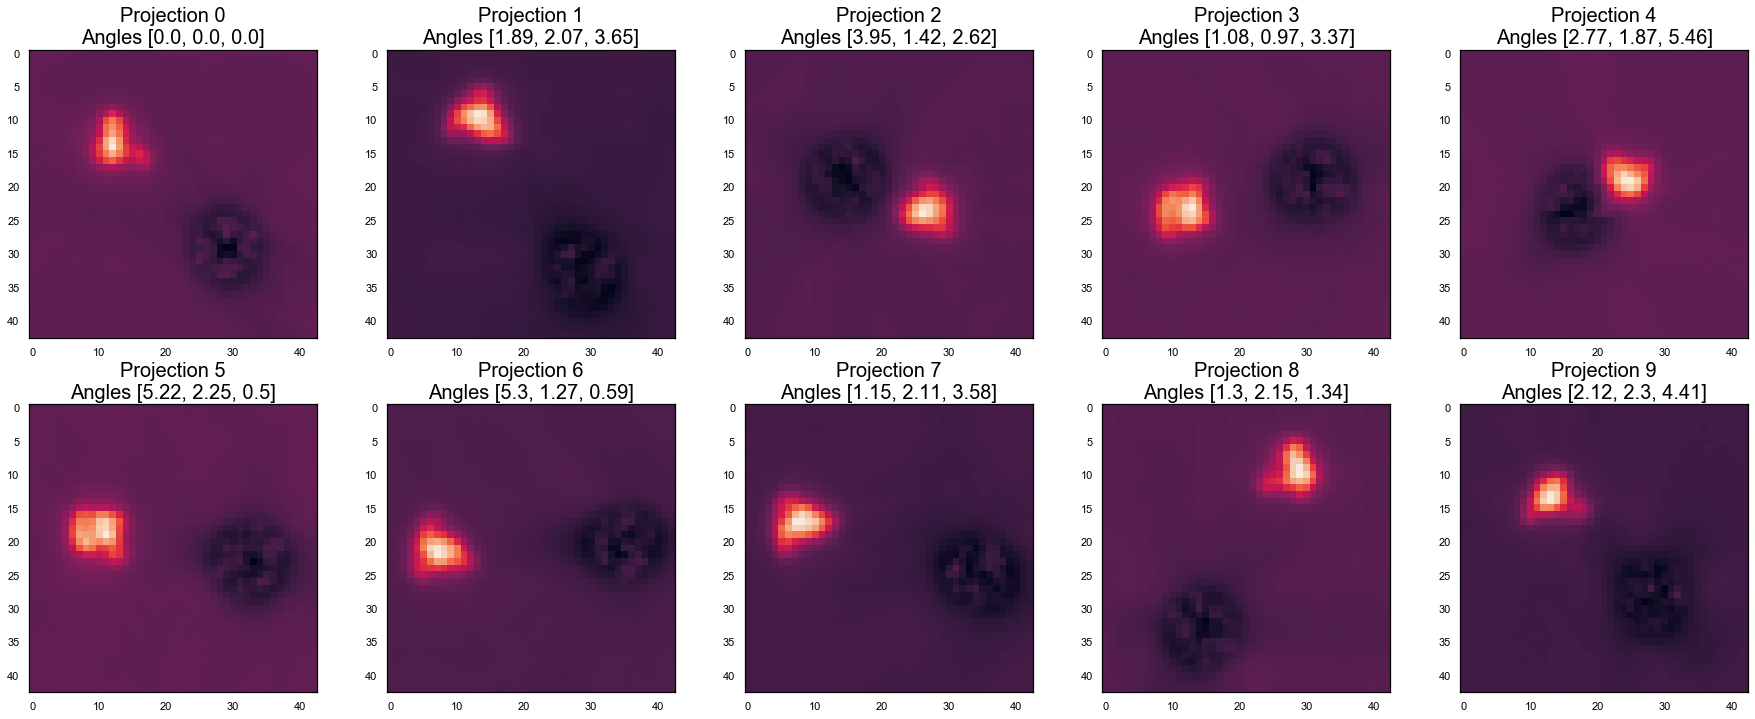

Q -790137882.275283
delta Q 0.0
Q -790782285.6960416
delta Q -644403.420758605
Q -791421666.1134108
delta Q -639380.4173692465
Q -792056067.4108117
delta Q -634401.2974008322
Q -792685532.3917329
delta Q -629464.9809212685
Q -793310112.3321251
delta Q -624579.9403921366
Q -793929844.0716618
delta Q -619731.7395367622
Q -794544776.0814695
delta Q -614932.0098077059
Q -795154948.9948833
delta Q -610172.913413763
Q -795760415.1685
delta Q -605466.1736166477
Q -796361207.353372
delta Q -600792.1848720312
Q -796957375.1904442
delta Q -596167.8370722532
Q -797548956.4483081
delta Q -591581.2578638792
Q -798135990.626994
delta Q -587034.1786859035
Q -798718531.3796115
delta Q -582540.7526174784
Q -799296604.6247723
delta Q -578073.2451608181
Q -799870258.4753423
delta Q -573653.8505699635
Q -800439528.3655478
delta Q -569269.8902055025
Q -801004459.7945486
delta Q -564931.4290008545
Q -801565085.2375509
delta Q -560625.443002224
Q -802121449.1276288
delta Q -556363.8900779486
Q -802673587.273

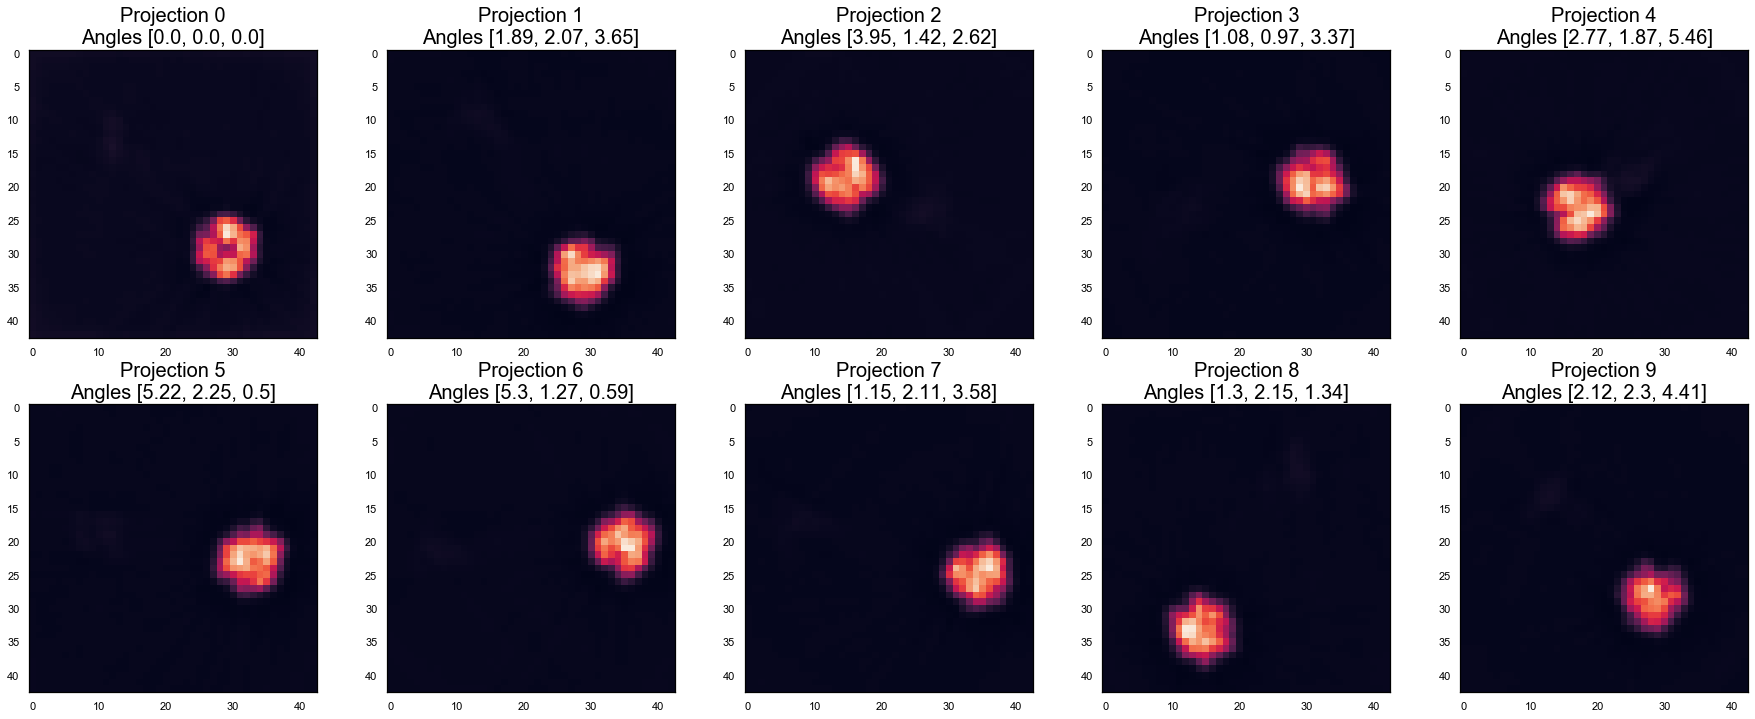

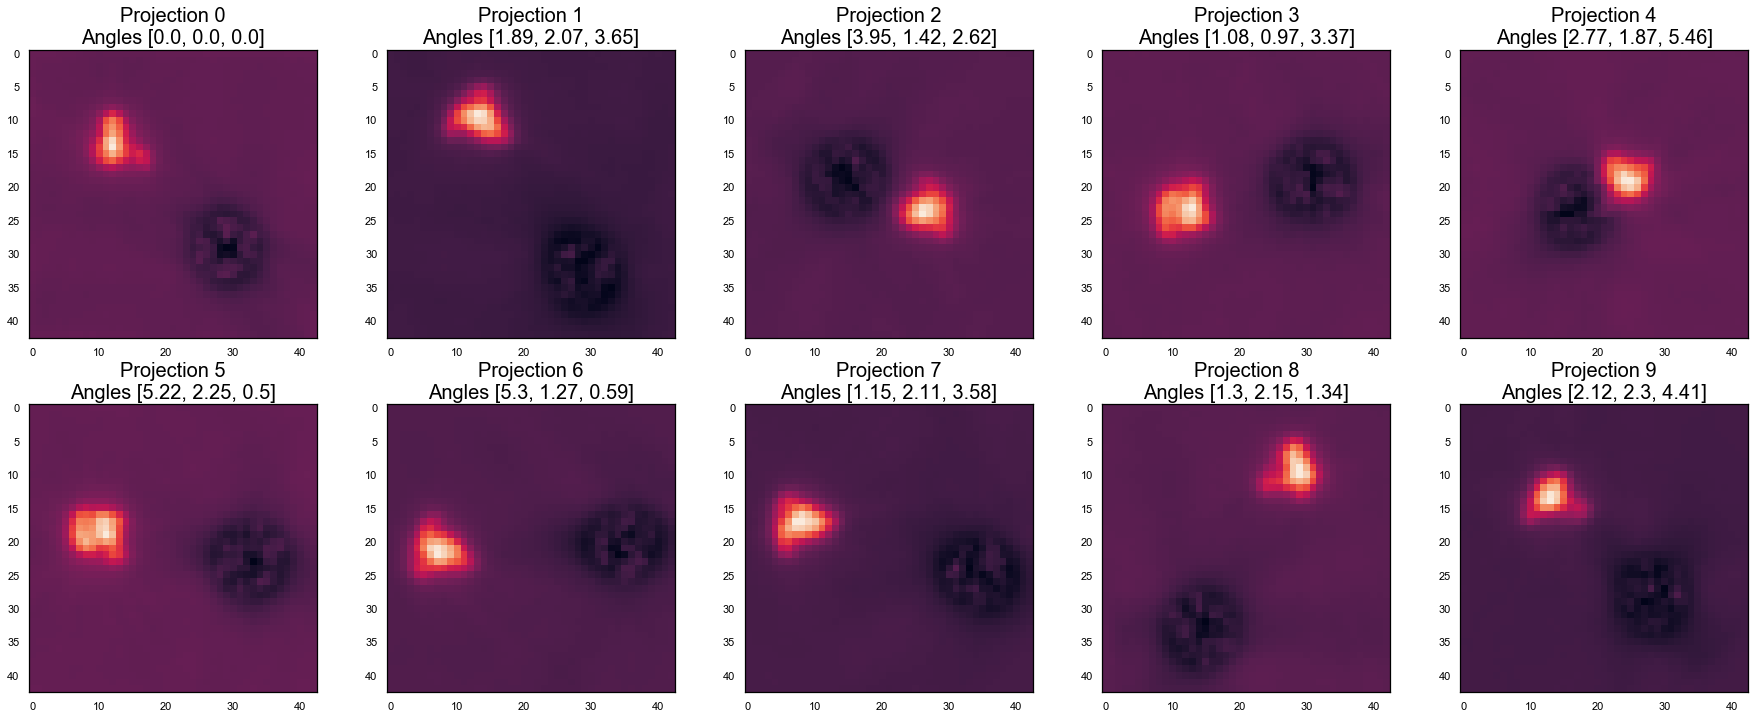

Q -817006328.4906238
delta Q 0.0
Q -817447703.5189288
delta Q -441375.0283049345
Q -817885868.4627558
delta Q -438164.94382703304
Q -818320841.1723915
delta Q -434972.70963573456
Q -818752663.1218219
delta Q -431821.9494303465
Q -819181344.1389971
delta Q -428681.0171751976
Q -819606927.3156813
delta Q -425583.17668426037
Q -820029425.8439178
delta Q -422498.52823650837
Q -820448875.3283771
delta Q -419449.48445928097
Q -820865298.7916853
delta Q -416423.46330821514
Q -821278728.9283028
delta Q -413430.1366174221
Q -821689177.338255
delta Q -410448.4099522829
Q -822096675.1964972
delta Q -407497.8582421541
Q -822501246.5696286
delta Q -404571.3731313944
Q -822902925.145181
delta Q -401678.5755523443
Q -823301723.7325407
delta Q -398798.58735978603
Q -823697673.4696337
delta Q -395949.7370929718
Q -824090797.6151459
delta Q -393124.14551222324
Q -824481116.7930756
delta Q -390319.1779296398
Q -824868658.6302902
delta Q -387541.8372145891
Q -825253441.3897934
delta Q -384782.75950324535


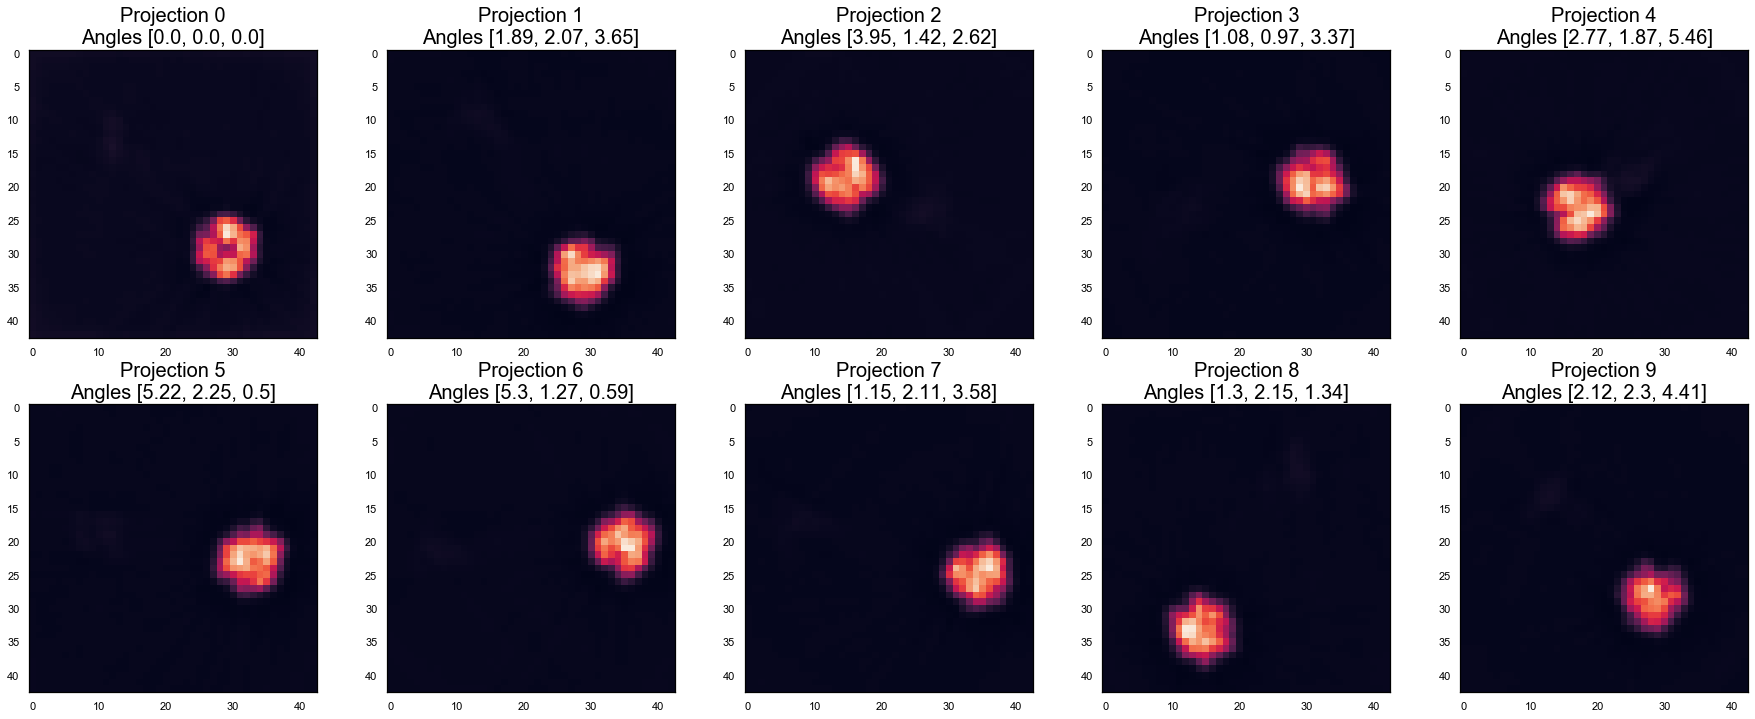

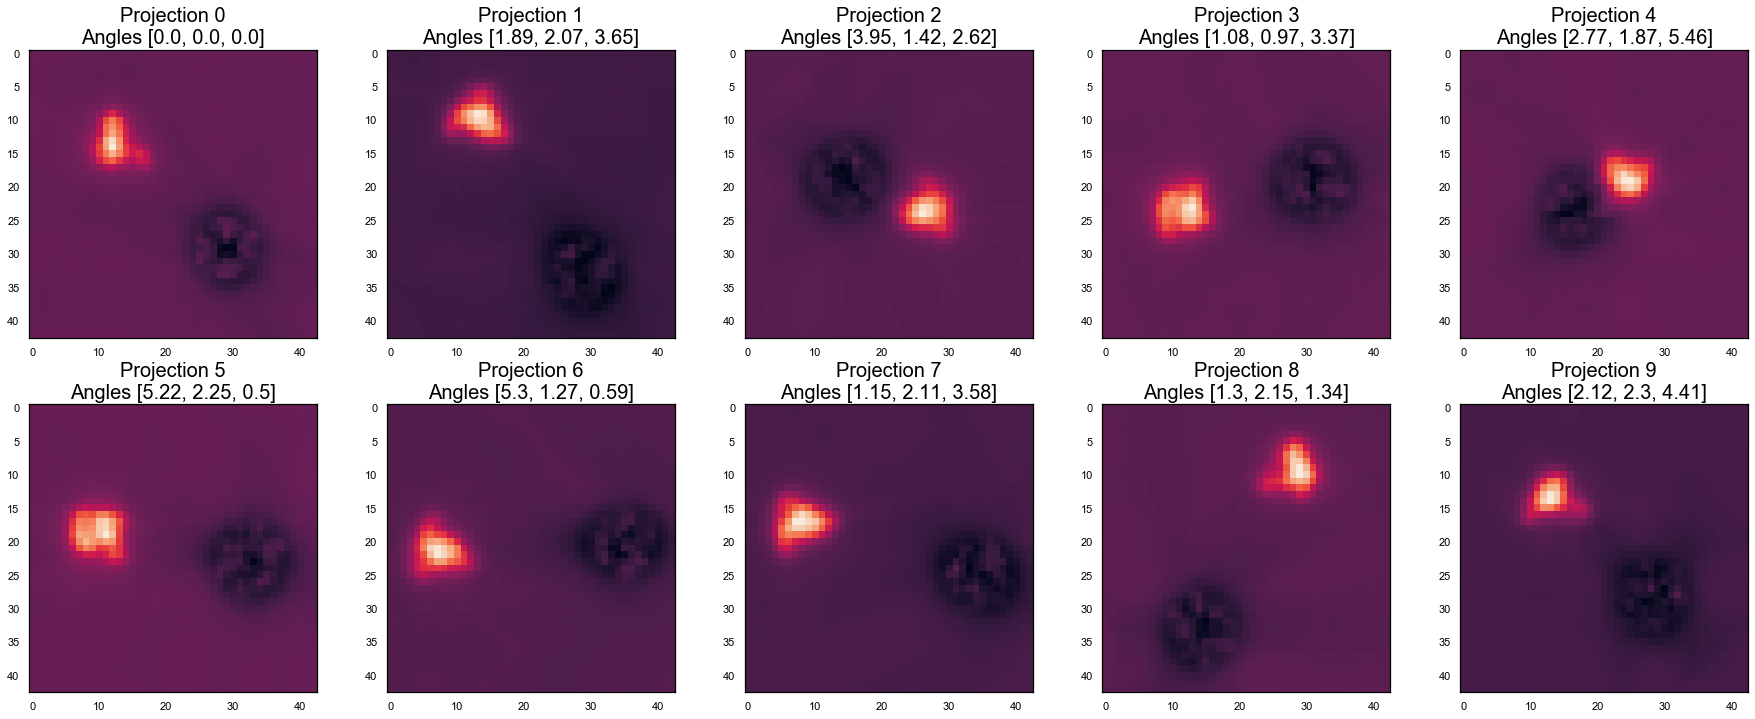

Q -835622221.7314196
delta Q 0.0
Q -835931984.4857095
delta Q -309762.7542899847
Q -836239625.2627797
delta Q -307640.7770701647
Q -836545171.1516666
delta Q -305545.88888692856
Q -836848626.6222063
delta Q -303455.47053968906
Q -837150020.867095
delta Q -301394.2448886633
Q -837449364.8888582
delta Q -299344.0217632055
Q -837746667.7628385
delta Q -297302.87398028374
Q -838041956.5064979
delta Q -295288.7436593771
Q -838335244.770178
delta Q -293288.26368010044
Q -838626541.1478829
delta Q -291296.377704978
Q -838915876.560073
delta Q -289335.4121900797
Q -839203247.4140836
delta Q -287370.85401058197
Q -839488685.7787765
delta Q -285438.3646929264
Q -839772195.3375595
delta Q -283509.55878293514
Q -840053798.315775
delta Q -281602.9782155752
Q -840333504.7468265
delta Q -279706.4310514927
Q -840611333.2809389
delta Q -277828.53411233425
Q -840887299.833624
delta Q -275966.55268514156
Q -841161413.9622068
delta Q -274114.1285828352
Q -841433694.579701
delta Q -272280.6174941063
Q -841

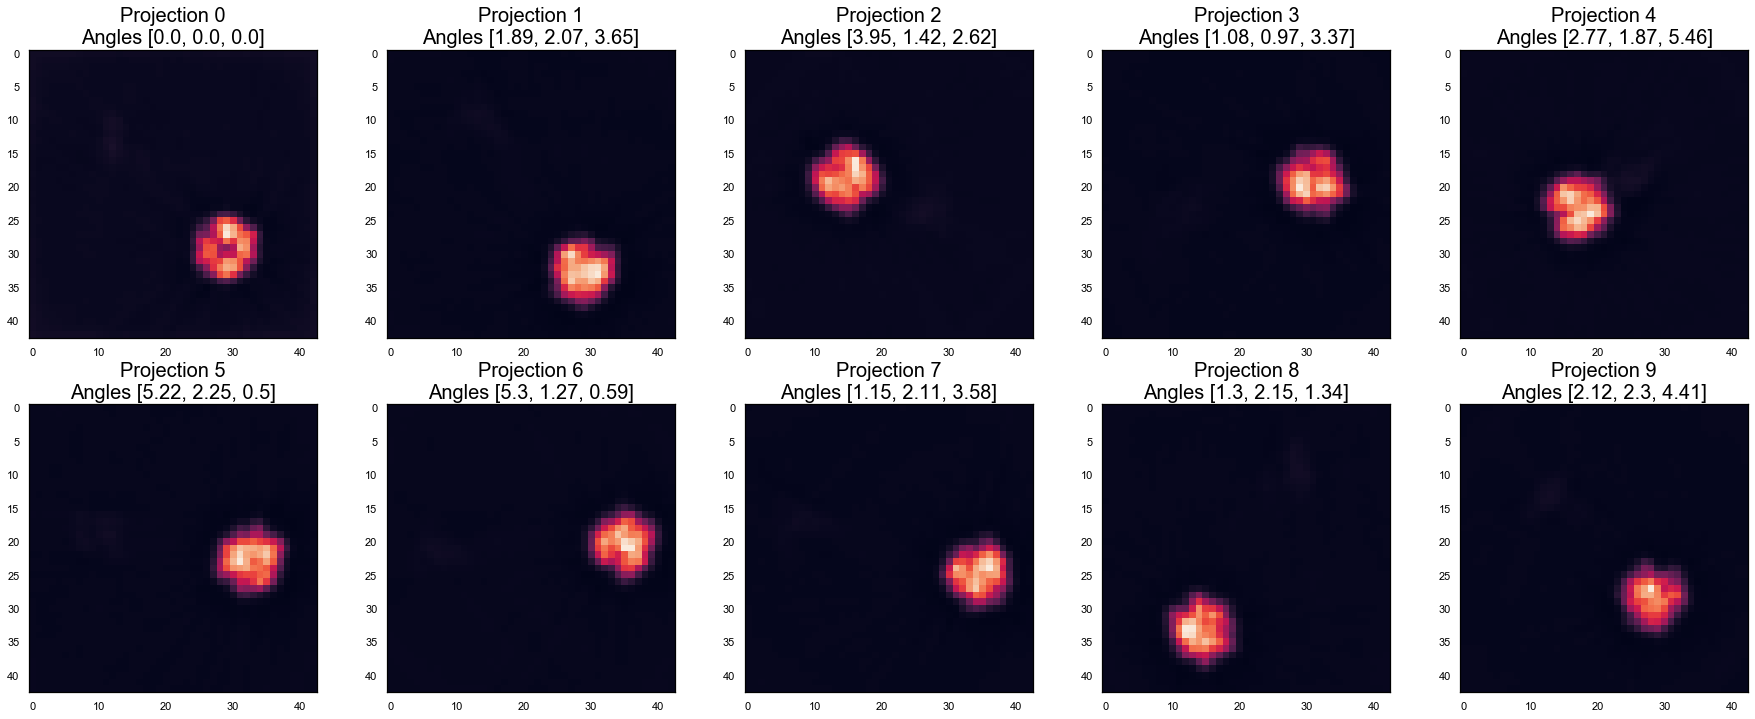

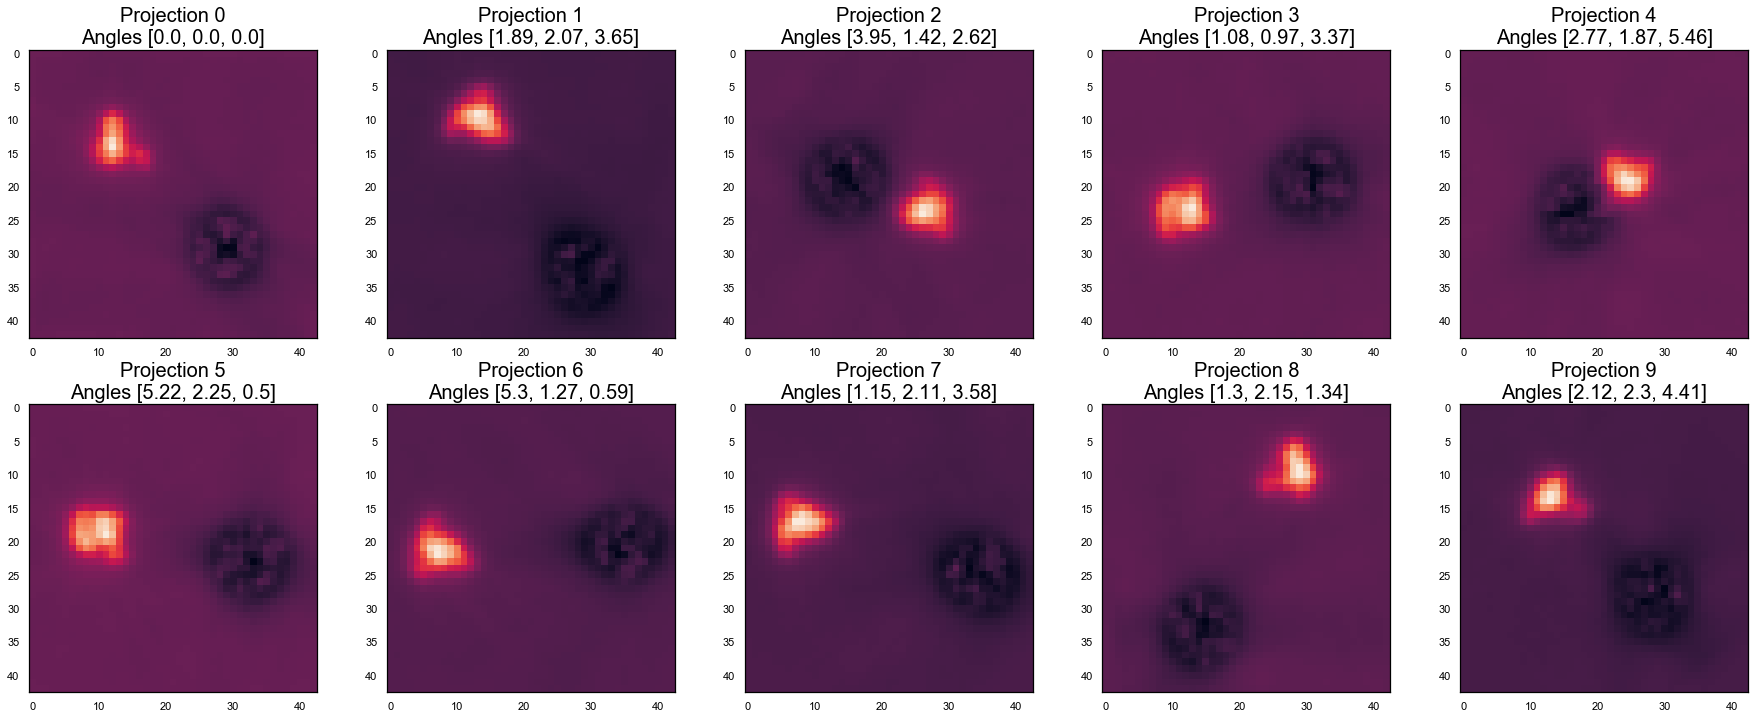

Q -848815401.5770816
delta Q 0.0
Q -849037303.7762918
delta Q -221902.19921028614
Q -849257762.4754329
delta Q -220458.69914102554
Q -849476804.4236311
delta Q -219041.94819819927
Q -849694430.0385909
delta Q -217625.614959836
Q -849910653.2848727
delta Q -216223.24628174305
Q -850125481.5680763
delta Q -214828.28320360184
Q -850338931.3728281
delta Q -213449.80475187302
Q -850551010.3403573
delta Q -212078.96752917767
Q -850761719.7231972
delta Q -210709.38283991814
Q -850971082.4487362
delta Q -209362.72553896904
Q -851179104.7485682
delta Q -208022.29983198643
Q -851385792.3827738
delta Q -206687.63420557976
Q -851591160.4240988
delta Q -205368.04132509232
Q -851795216.8875921
delta Q -204056.46349322796
Q -851997972.2909333
delta Q -202755.40334117413
Q -852199433.6758415
delta Q -201461.3849081993
Q -852399608.8886926
delta Q -200175.21285116673
Q -852598515.1977909
delta Q -198906.3090982437
Q -852796148.657003
delta Q -197633.45921218395
Q -852992533.9732838
delta Q -196385.3162

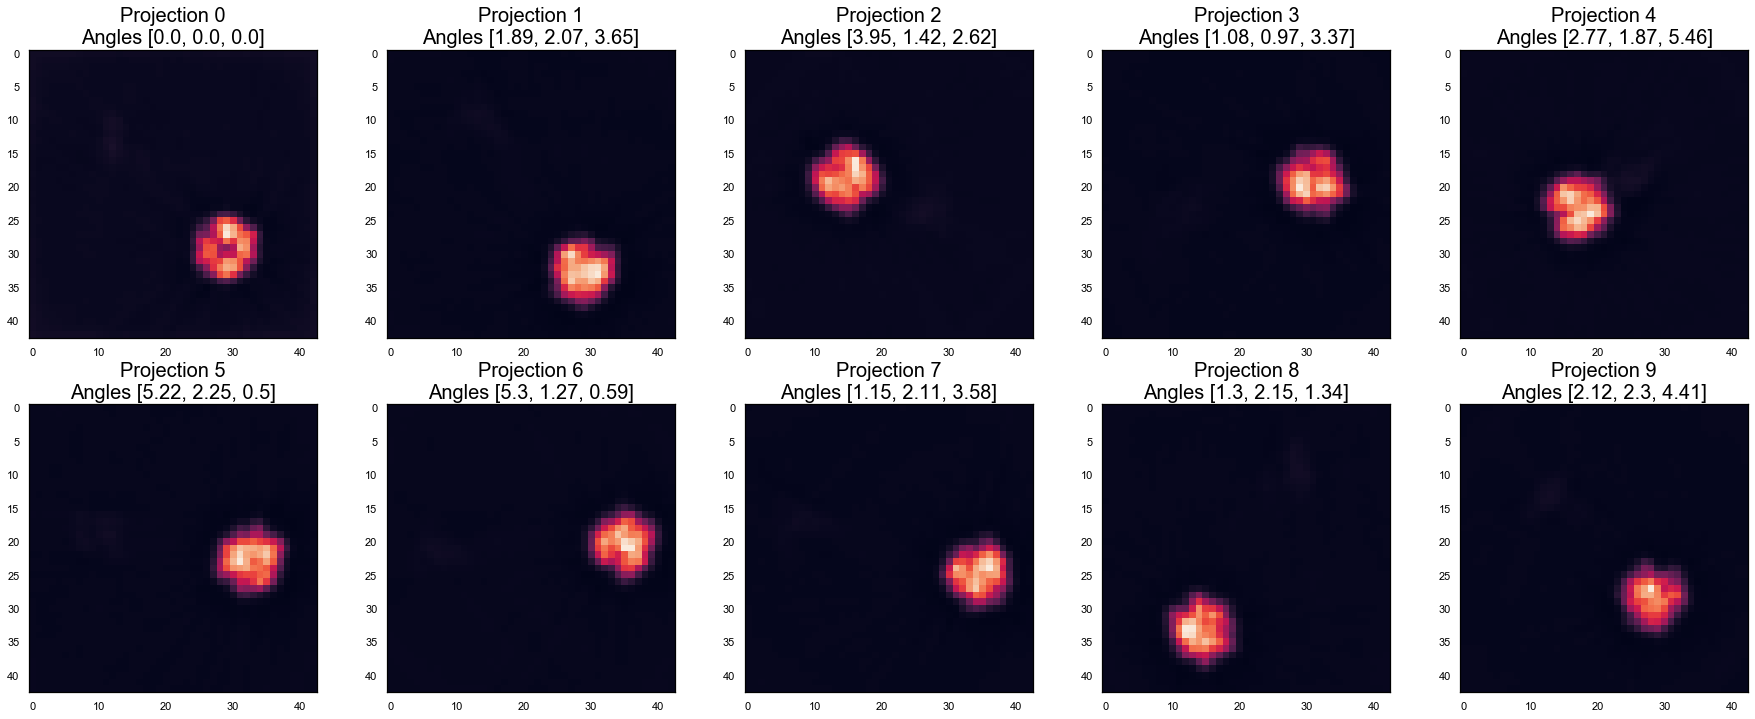

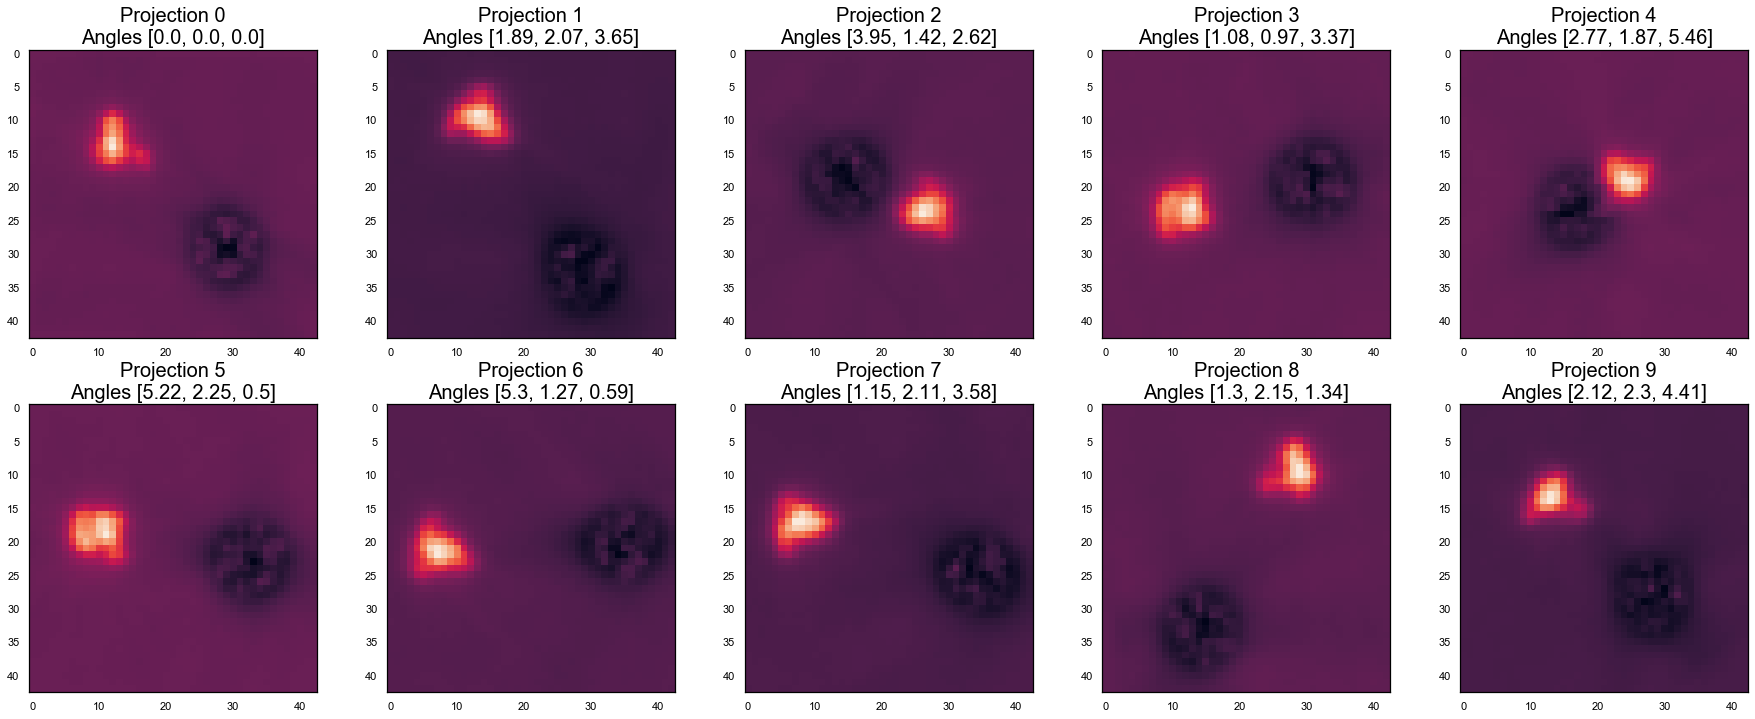

Q -858343287.0883628
delta Q 0.0
Q -858504955.3267803
delta Q -161668.23841750622
Q -858665625.9976779
delta Q -160670.67089760303
Q -858825306.9995638
delta Q -159681.00188589096
Q -858984006.33169
delta Q -158699.3321261406
Q -859141723.4984281
delta Q -157717.1667381525
Q -859298476.8061812
delta Q -156753.3077530861
Q -859454270.433662
delta Q -155793.62748086452
Q -859609105.0835255
delta Q -154834.64986348152
Q -859762991.8619571
delta Q -153886.77843153477
Q -859915938.3357359
delta Q -152946.47377884388
Q -860067945.7988017
delta Q -152007.46306574345
Q -860219026.4824182
delta Q -151080.68361651897
Q -860369185.0419005
delta Q -150158.55948233604
Q -860518426.4053823
delta Q -149241.36348176003
Q -860666754.9510405
delta Q -148328.54565823078
Q -860814184.8705342
delta Q -147429.91949367523
Q -860960715.5928807
delta Q -146530.72234654427
Q -861106359.1932771
delta Q -145643.60039639473
Q -861251111.740154
delta Q -144752.54687690735
Q -861394986.9221113
delta Q -143875.181957

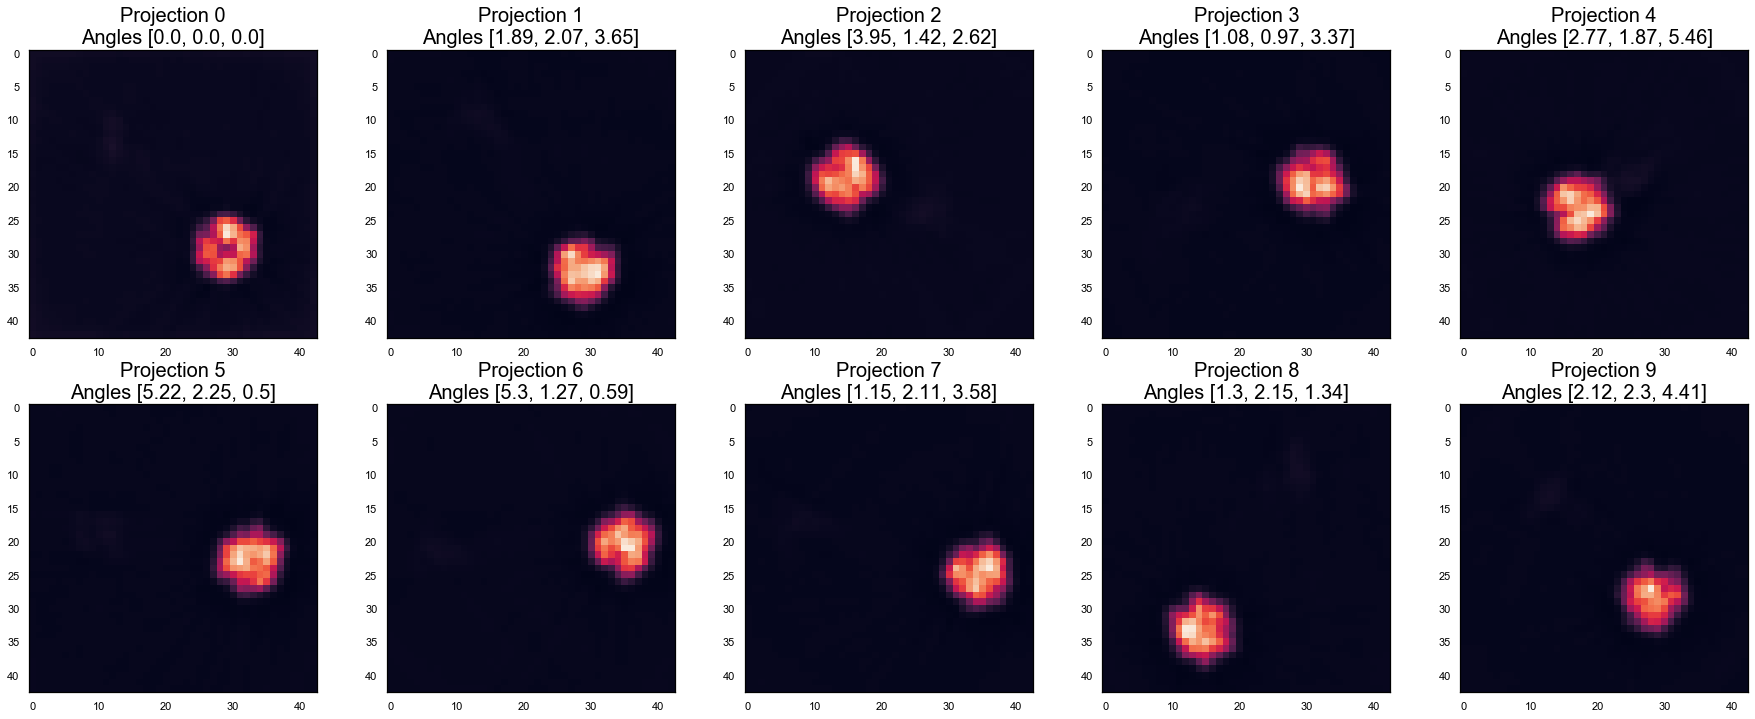

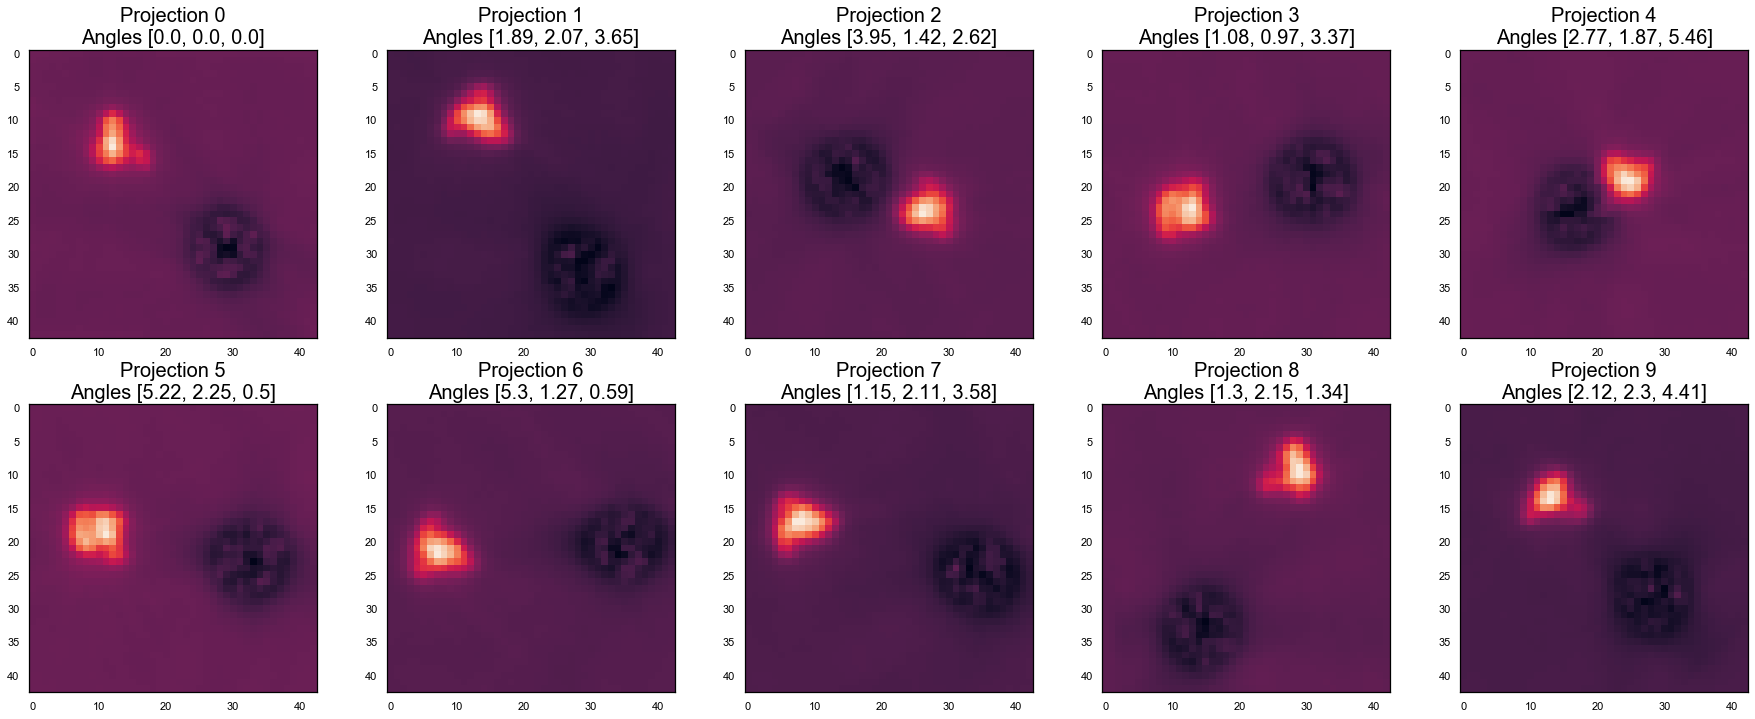

Q -865331034.5007604
delta Q 0.0
Q -865450449.1239338
delta Q -119414.62317335606
Q -865569156.549602
delta Q -118707.4256682396
Q -865687157.5097433
delta Q -118000.96014130116
Q -865804466.8226364
delta Q -117309.31289303303
Q -865921080.0450695
delta Q -116613.22243309021
Q -866037001.9990665
delta Q -115921.95399701595
Q -866152247.1953719
delta Q -115245.19630539417
Q -866266810.0075995
delta Q -114562.81222760677
Q -866380694.7876322
delta Q -113884.78003275394
Q -866493909.3548127
delta Q -113214.56718051434
Q -866606462.4007342
delta Q -112553.0459214449
Q -866718354.5128347
delta Q -111892.11210048199
Q -866829582.3121297
delta Q -111227.79929506779
Q -866940163.2506567
delta Q -110580.93852698803
Q -867050093.56339
delta Q -109930.31273329258
Q -867159380.3963258
delta Q -109286.83293581009
Q -867268021.4164315
delta Q -108641.02010571957
Q -867376036.1363744
delta Q -108014.71994280815
Q -867483415.6454412
delta Q -107379.50906682014
Q -867590164.7029243
delta Q -106749.0574

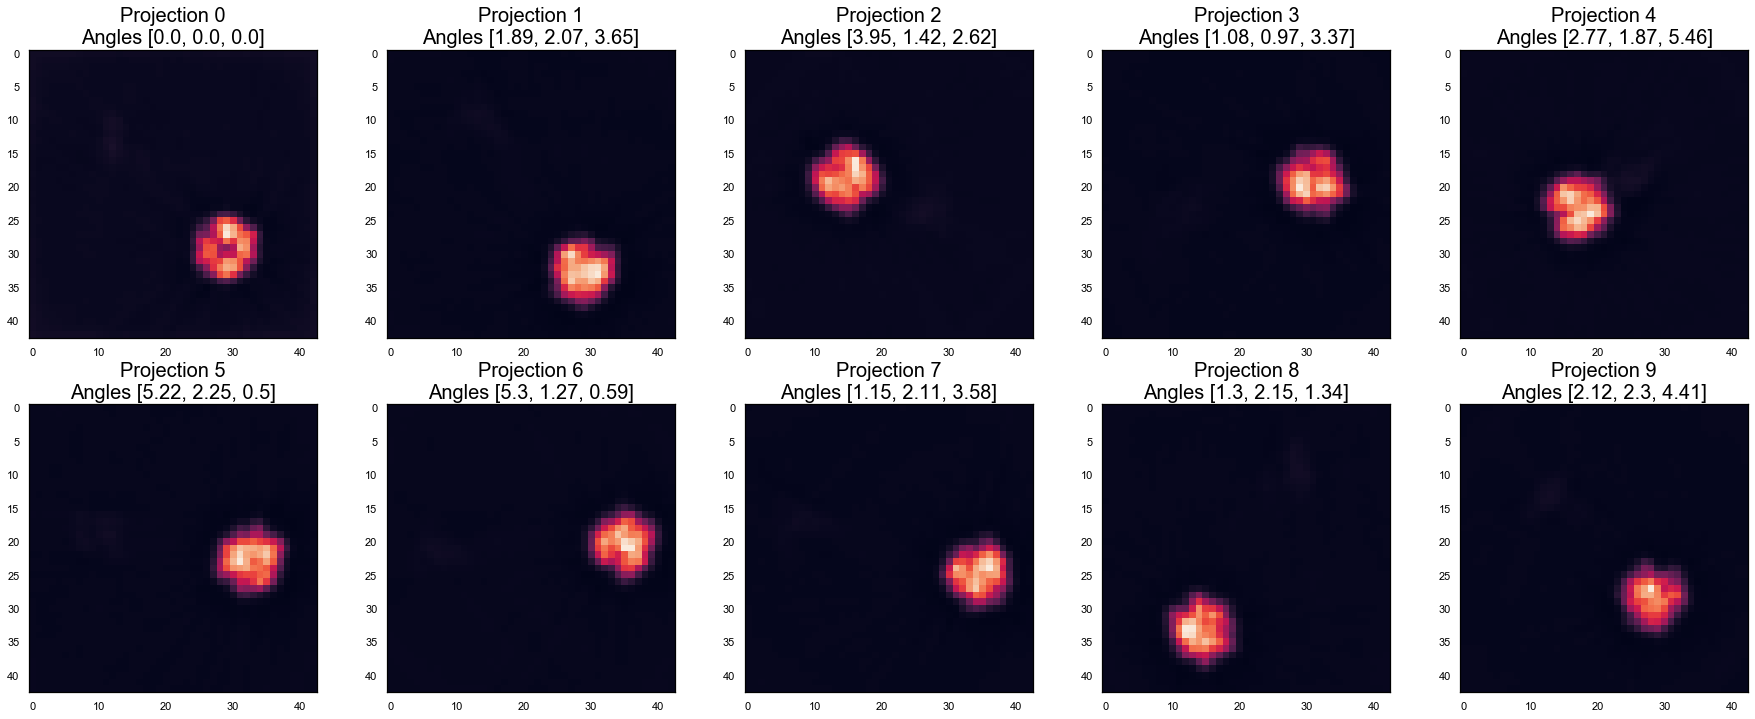

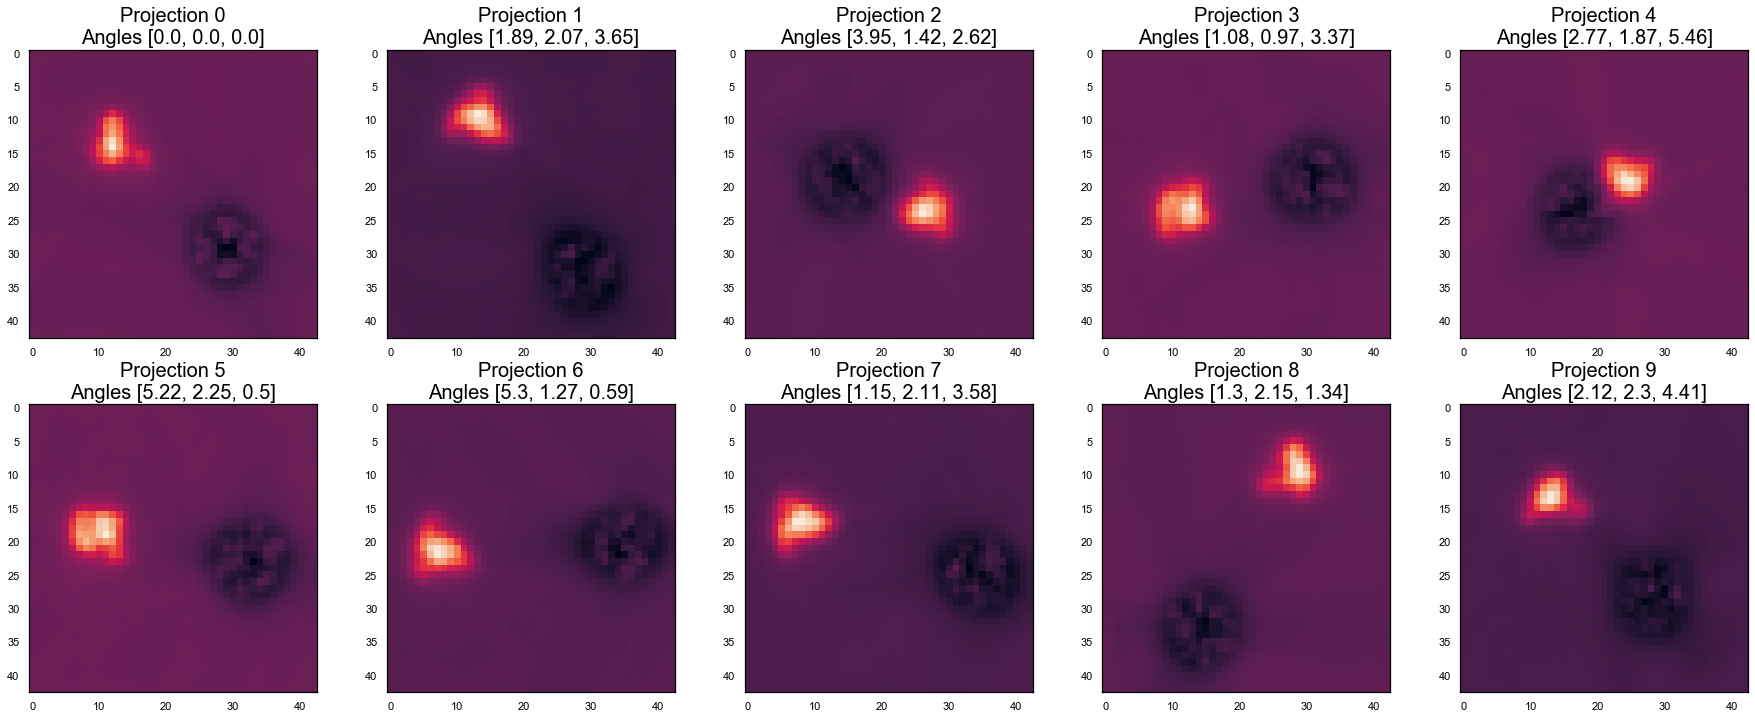

Q -870520140.4617653
delta Q 0.0
Q -870609325.5748007
delta Q -89185.11303544044
Q -870697994.4112393
delta Q -88668.83643853664
Q -870786163.8096163
delta Q -88169.39837706089
Q -870873825.5089291
delta Q -87661.69931280613
Q -870960985.0634078
delta Q -87159.55447864532
Q -871047654.2711232
delta Q -86669.20771539211
Q -871133821.6222355
delta Q -86167.35111236572
Q -871219498.3789262
delta Q -85676.75669062138
Q -871304687.0461195
delta Q -85188.66719329357
Q -871389394.1165372
delta Q -84707.0704177618
Q -871473618.1396661
delta Q -84224.02312886715
Q -871557356.9196315
delta Q -83738.7799654007
Q -871640628.5561626
delta Q -83271.63653111458
Q -871723417.1962913
delta Q -82788.64012873173
Q -871805741.9256839
delta Q -82324.72939252853
Q -871887596.125956
delta Q -81854.20027220249
Q -871968991.4240818
delta Q -81395.29812574387
Q -872049918.38472
delta Q -80926.96063816547
Q -872130389.132425
delta Q -80470.74770498276
Q -872210405.2887194
delta Q -80016.15629446507
Q -872289967.

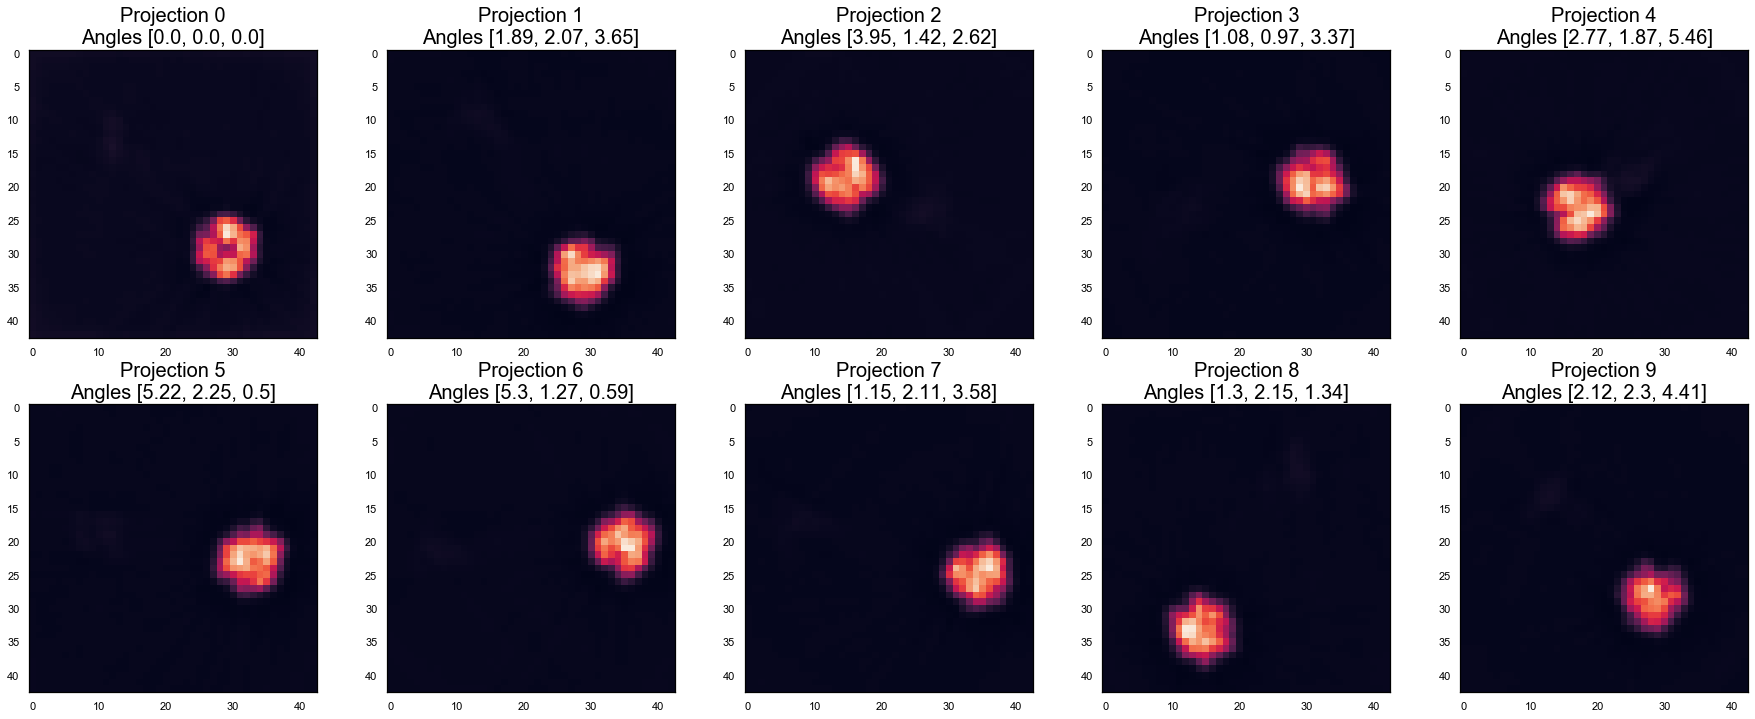

Q -874412317.6559966
delta Q 0.0
Q -874479516.726626
delta Q -67199.0706294775
Q -874546339.7998202
delta Q -66823.07319414616
Q -874612793.9926219
delta Q -66454.19280171394
Q -874678875.984872
delta Q -66081.99225008488
Q -874744600.3476447
delta Q -65724.36277270317
Q -874809944.0449613
delta Q -65343.697316646576
Q -874874937.5579005
delta Q -64993.51293921471
Q -874939566.5089794
delta Q -64628.951078891754
Q -875003832.308471
delta Q -64265.799491524696
Q -875067745.5082414
delta Q -63913.19977045059
Q -875131302.3520794
delta Q -63556.843837976456
Q -875194511.8181307
delta Q -63209.4660513401
Q -875257365.2234311
delta Q -62853.4053003788
Q -875319876.9242536
delta Q -62511.70082247257
Q -875382034.8723961
delta Q -62157.948142528534
Q -875443852.8023914
delta Q -61817.929995298386
Q -875505335.3994757
delta Q -61482.59708428383
Q -875566471.7109114
delta Q -61136.31143569946
Q -875627272.777137
delta Q -60801.066225647926
Q -875687733.9621785
delta Q -60461.18504142761
Q -8757

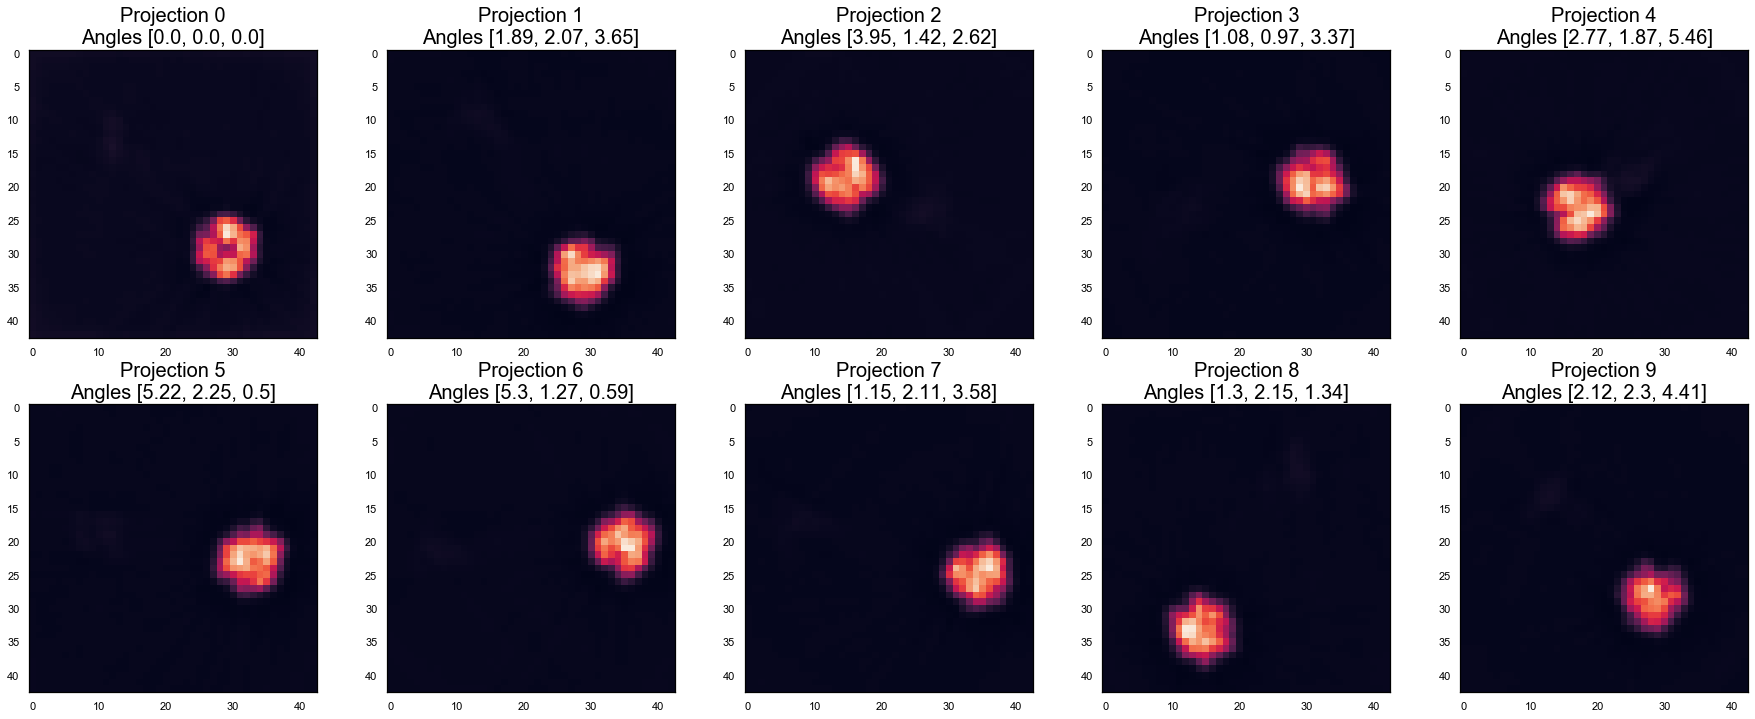

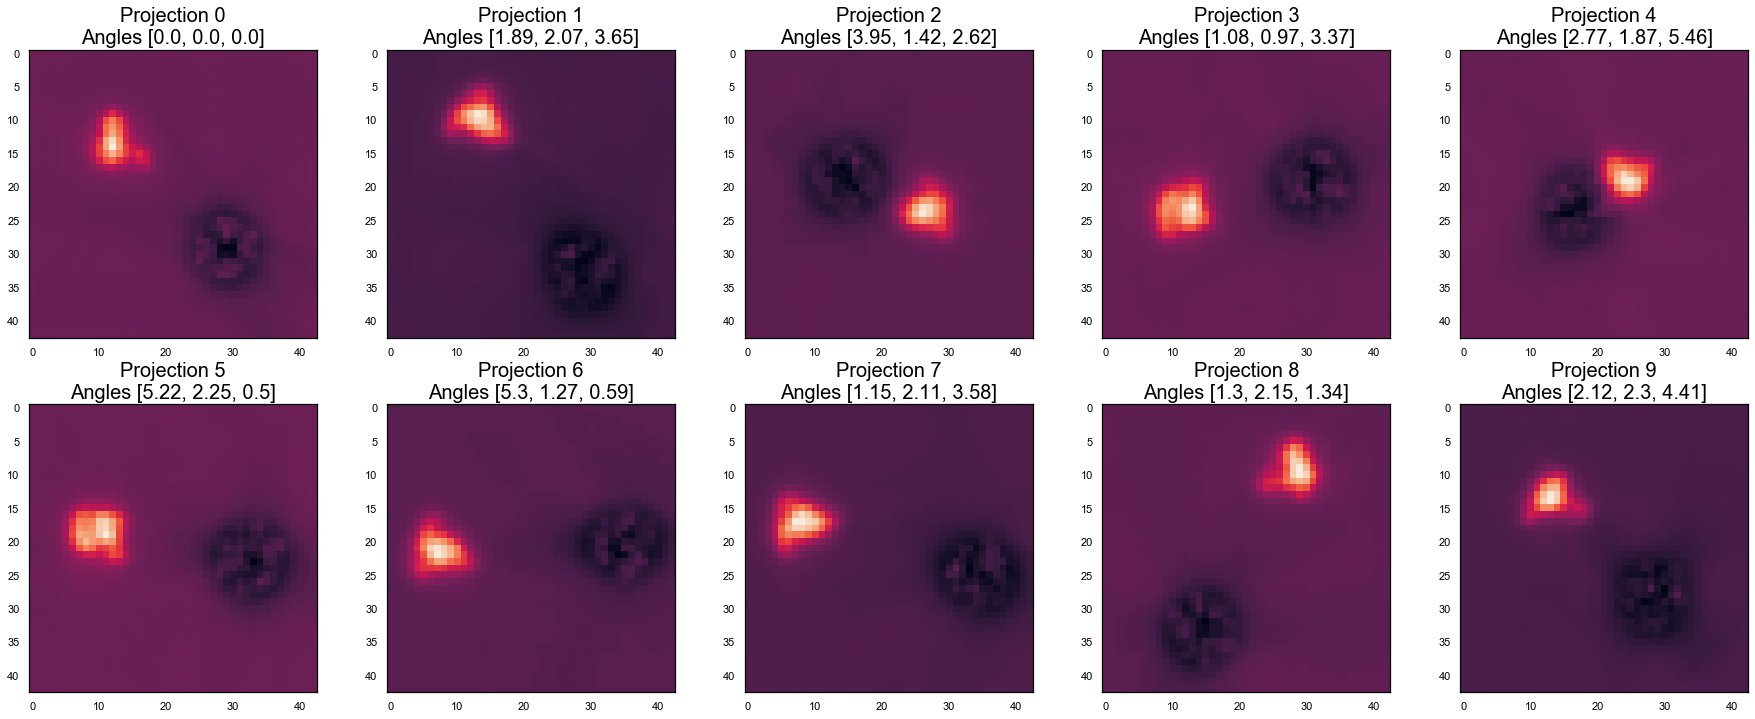

Q -877355091.1256472
delta Q 0.0
Q -877406082.89544
delta Q -50991.76979279518
Q -877456794.9398818
delta Q -50712.04444181919
Q -877507236.0766945
delta Q -50441.13681268692
Q -877557400.8024536
delta Q -50164.7257591486
Q -877607293.3420837
delta Q -49892.53963005543
Q -877656910.8172405
delta Q -49617.47515678406
Q -877706263.0902429
delta Q -49352.27300238609
Q -877755346.5744066
delta Q -49083.48416376114
Q -877804160.6929375
delta Q -48814.118530869484
Q -877852711.2848133
delta Q -48550.59187579155
Q -877901001.6926252
delta Q -48290.40781188011
Q -877949025.6678464
delta Q -48023.97522127628
Q -877996796.173629
delta Q -47770.50578260422
Q -878044302.8409346
delta Q -47506.66730558872
Q -878091550.4568709
delta Q -47247.6159362793
Q -878138544.2622284
delta Q -46993.80535745621
Q -878185288.2911685
delta Q -46744.0289400816
Q -878231774.4359097
delta Q -46486.14474129677
Q -878278009.7703295
delta Q -46235.334419727325
Q -878323994.5512326
delta Q -45984.78090310097
Q -87836973

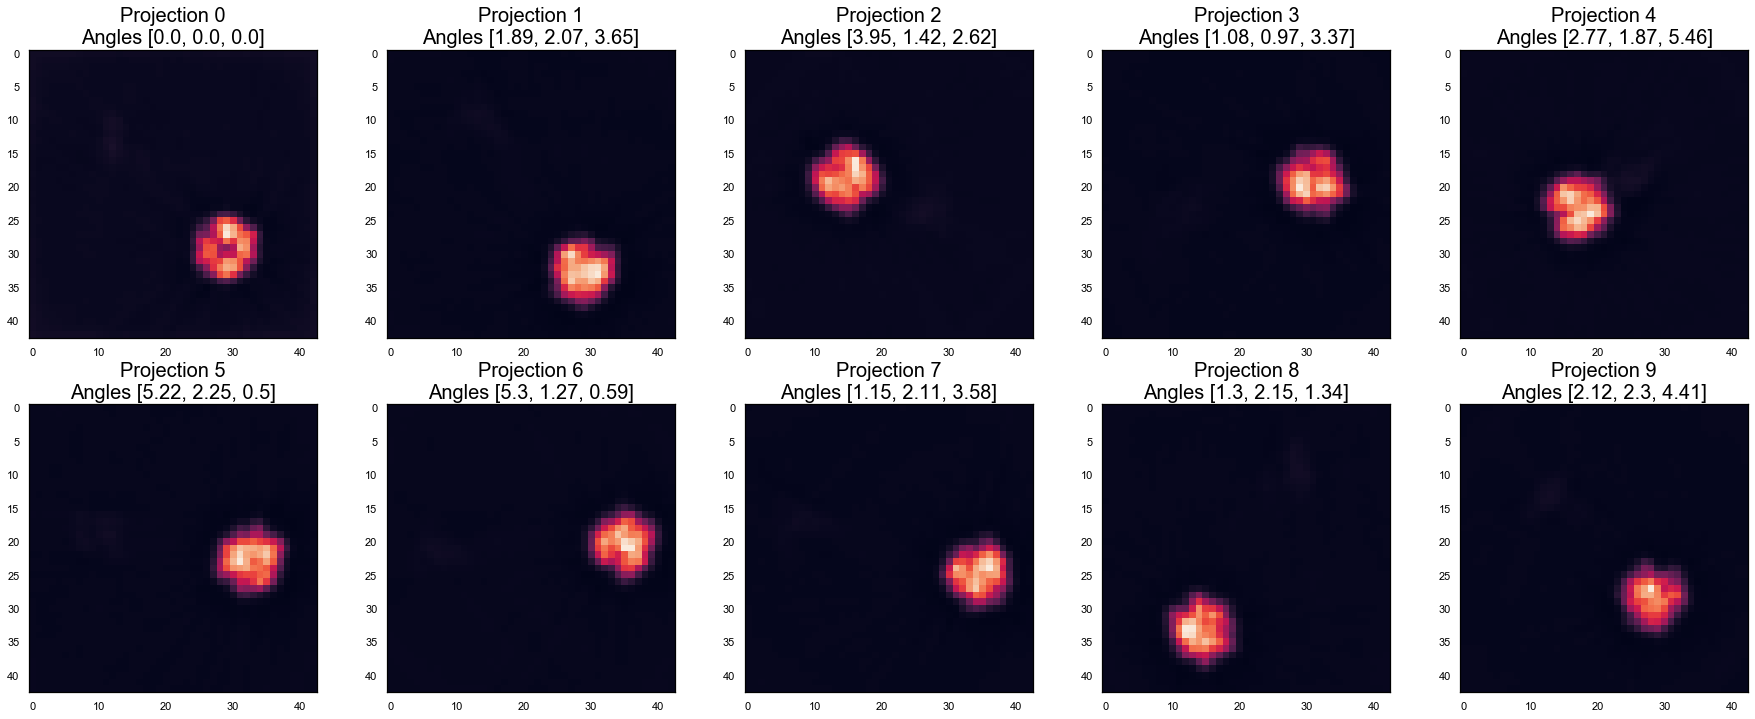

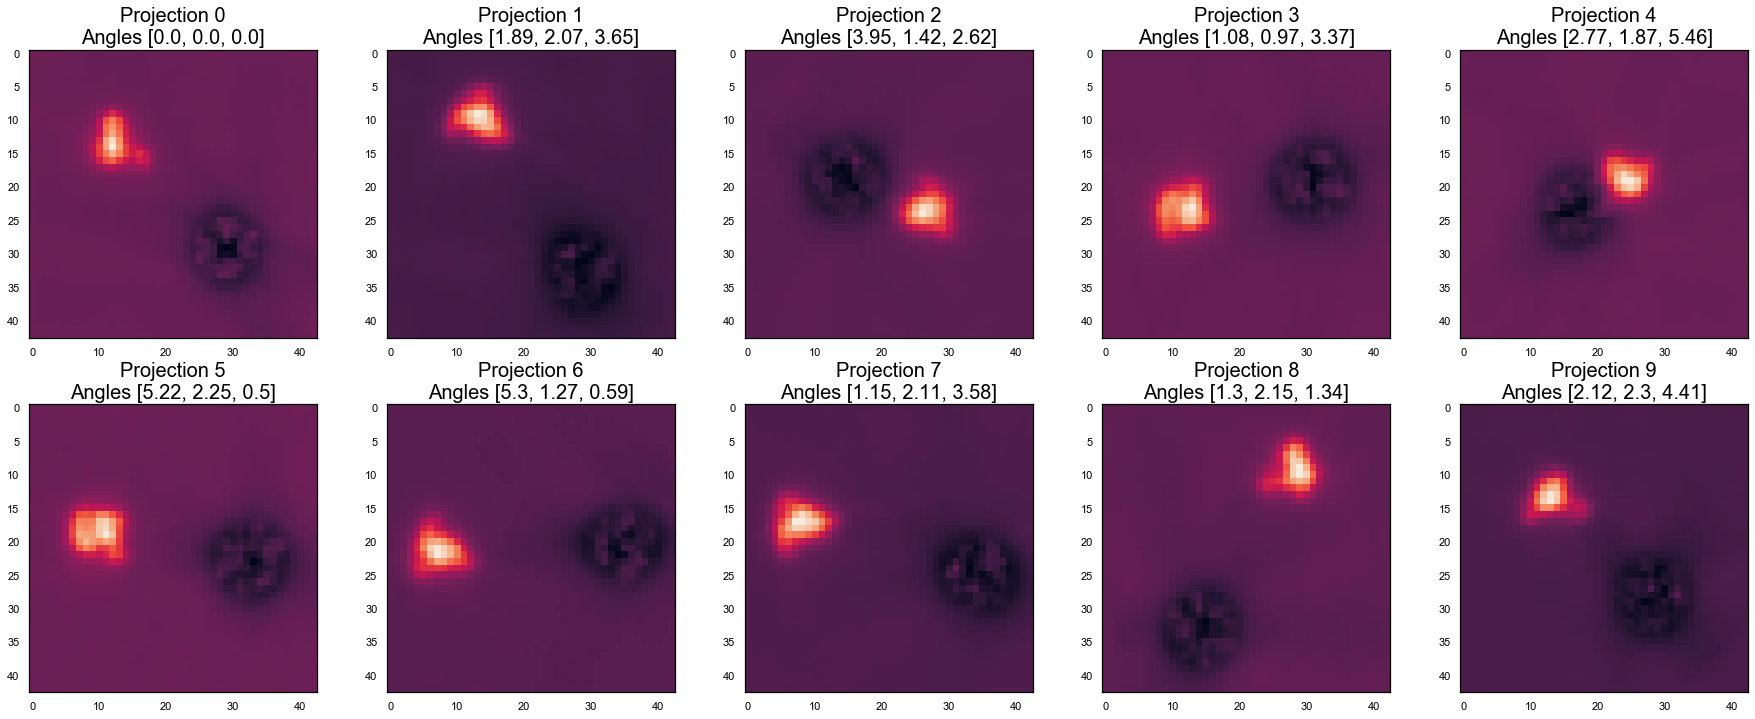

Q -879594180.6572657
delta Q 0.0
Q -879633088.7134444
delta Q -38908.056178689
Q -879671786.6150153
delta Q -38697.901570916176
Q -879710289.5199517
delta Q -38502.90493643284
Q -879748576.7174493
delta Q -38287.19749760628
Q -879786660.83519
delta Q -38084.11774075031
Q -879824544.6529291
delta Q -37883.81773900986
Q -879862220.5293941
delta Q -37675.87646508217
Q -879899702.3276187
delta Q -37481.79822456837
Q -879936978.8843626
delta Q -37276.556743860245
Q -879974058.9195802
delta Q -37080.035217642784
Q -880010942.550584
delta Q -36883.63100373745
Q -880047625.7960789
delta Q -36683.24549496174
Q -880084117.2281578
delta Q -36491.43207883835
Q -880120409.3938605
delta Q -36292.165702700615
Q -880156515.2491318
delta Q -36105.85527133942
Q -880192426.0637952
delta Q -35910.81466341019
Q -880228144.0831944
delta Q -35718.01939916611
Q -880263671.6081258
delta Q -35527.52493143082
Q -880299013.4077228
delta Q -35341.79959702492
Q -880334165.9064009
delta Q -35152.49867808819
Q -88036

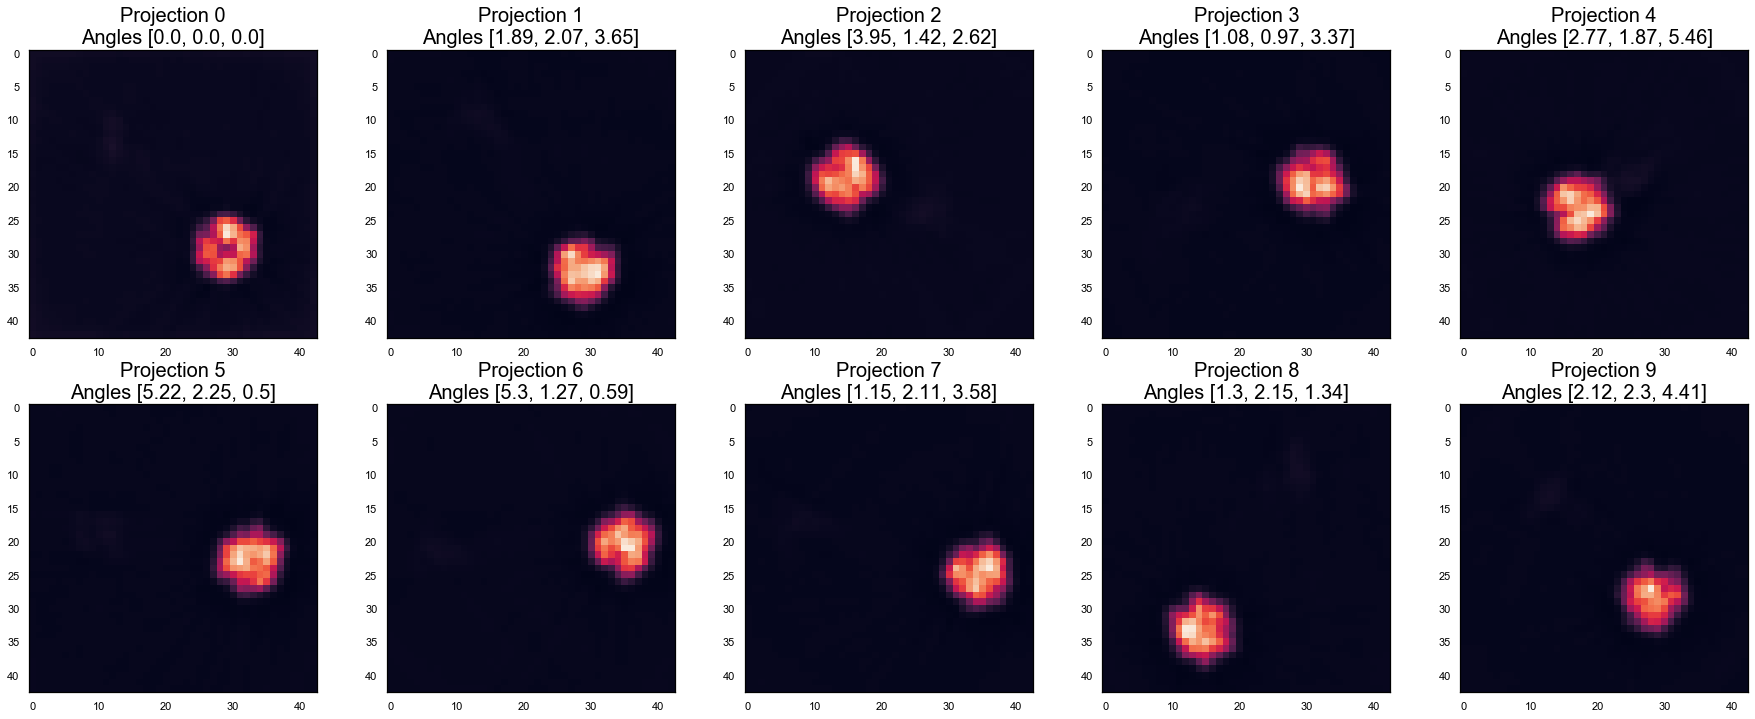

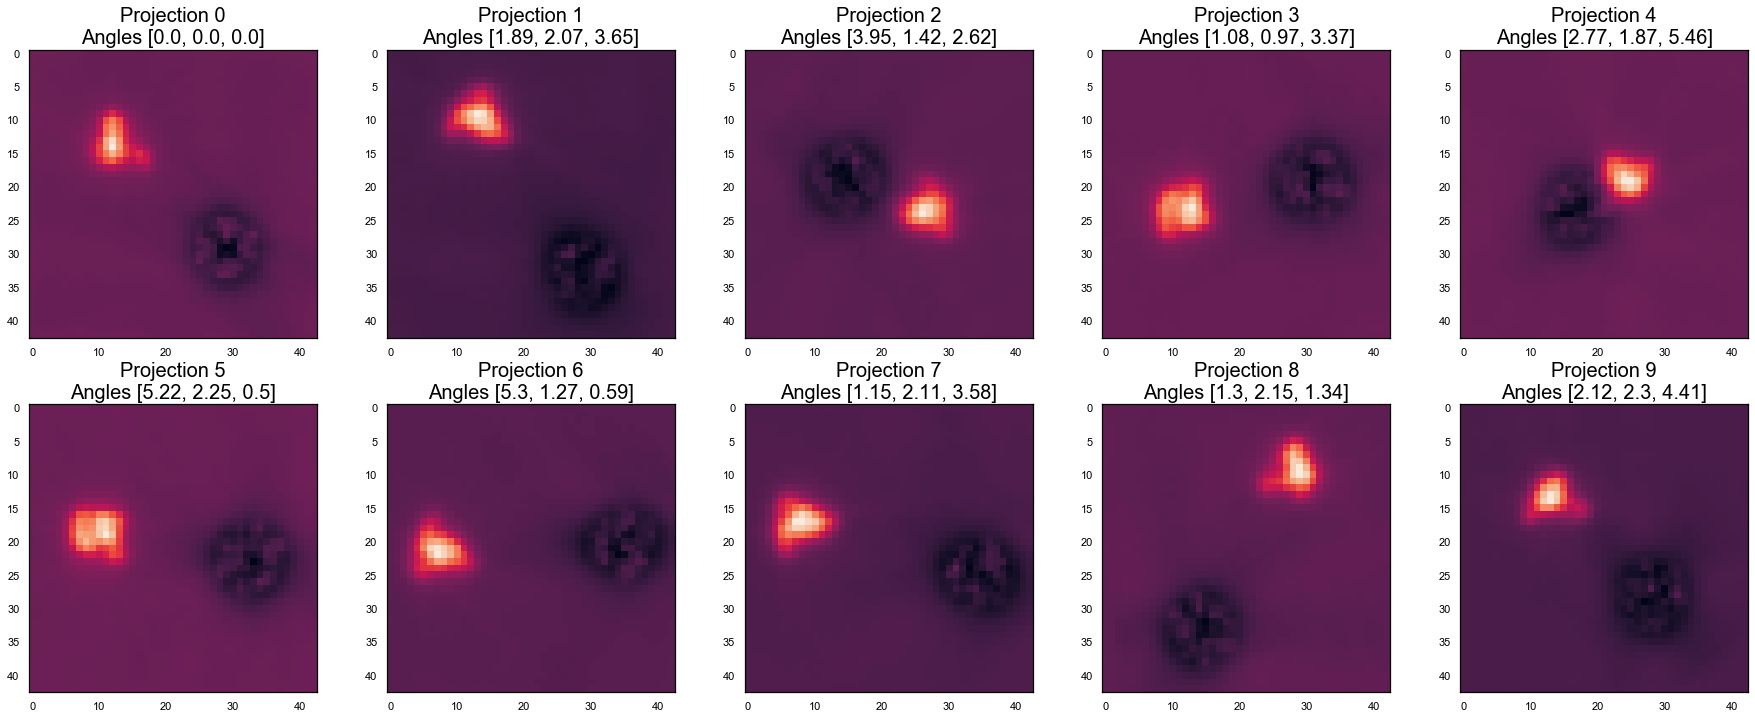

Q -881306395.5029349
delta Q 0.0
Q -881336217.6095124
delta Q -29822.106577515602
Q -881365878.329892
delta Q -29660.720379590988
Q -881395387.3380065
delta Q -29509.00811445713
Q -881424743.2784977
delta Q -29355.940491199493
Q -881453940.3858465
delta Q -29197.107348799706
Q -881482985.5071189
delta Q -29045.121272444725
Q -881511878.2445794
delta Q -28892.73746049404
Q -881540616.3444108
delta Q -28738.099831342697
Q -881569204.3427411
delta Q -28587.99833035469
Q -881597642.0186806
delta Q -28437.675939440727
Q -881625929.8759365
delta Q -28287.85725593567
Q -881654069.4169157
delta Q -28139.540979146957
Q -881682064.9386939
delta Q -27995.5217782259
Q -881709909.493993
delta Q -27844.555299162865
Q -881737609.517722
delta Q -27700.023728966713
Q -881765161.1707104
delta Q -27551.652988433838
Q -881792570.8523774
delta Q -27409.681666970253
Q -881819835.5089152
delta Q -27264.656537771225
Q -881846955.9654392
delta Q -27120.456524014473
Q -881873934.990221
delta Q -26979.0247818231

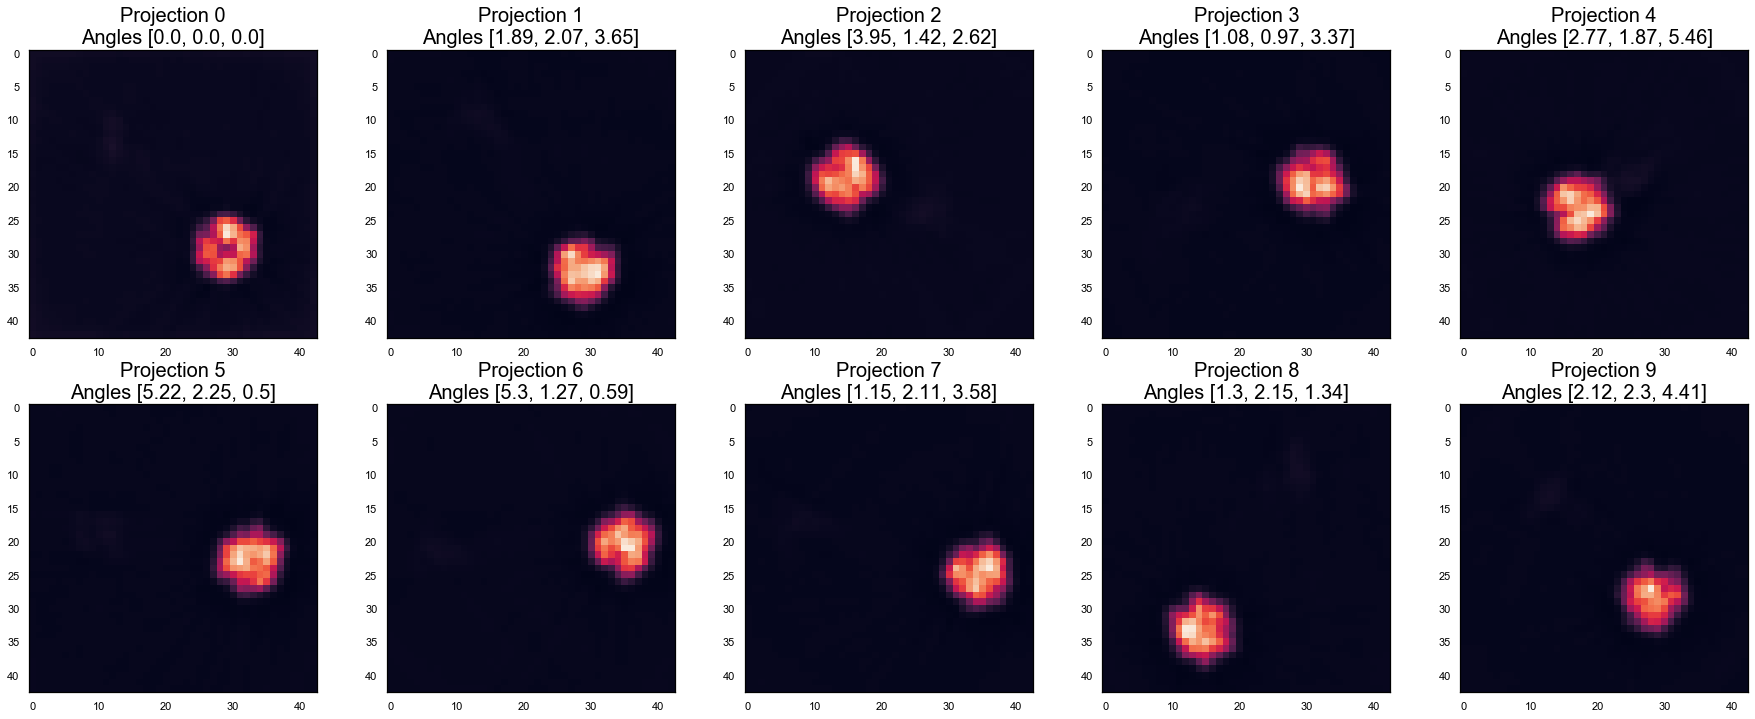

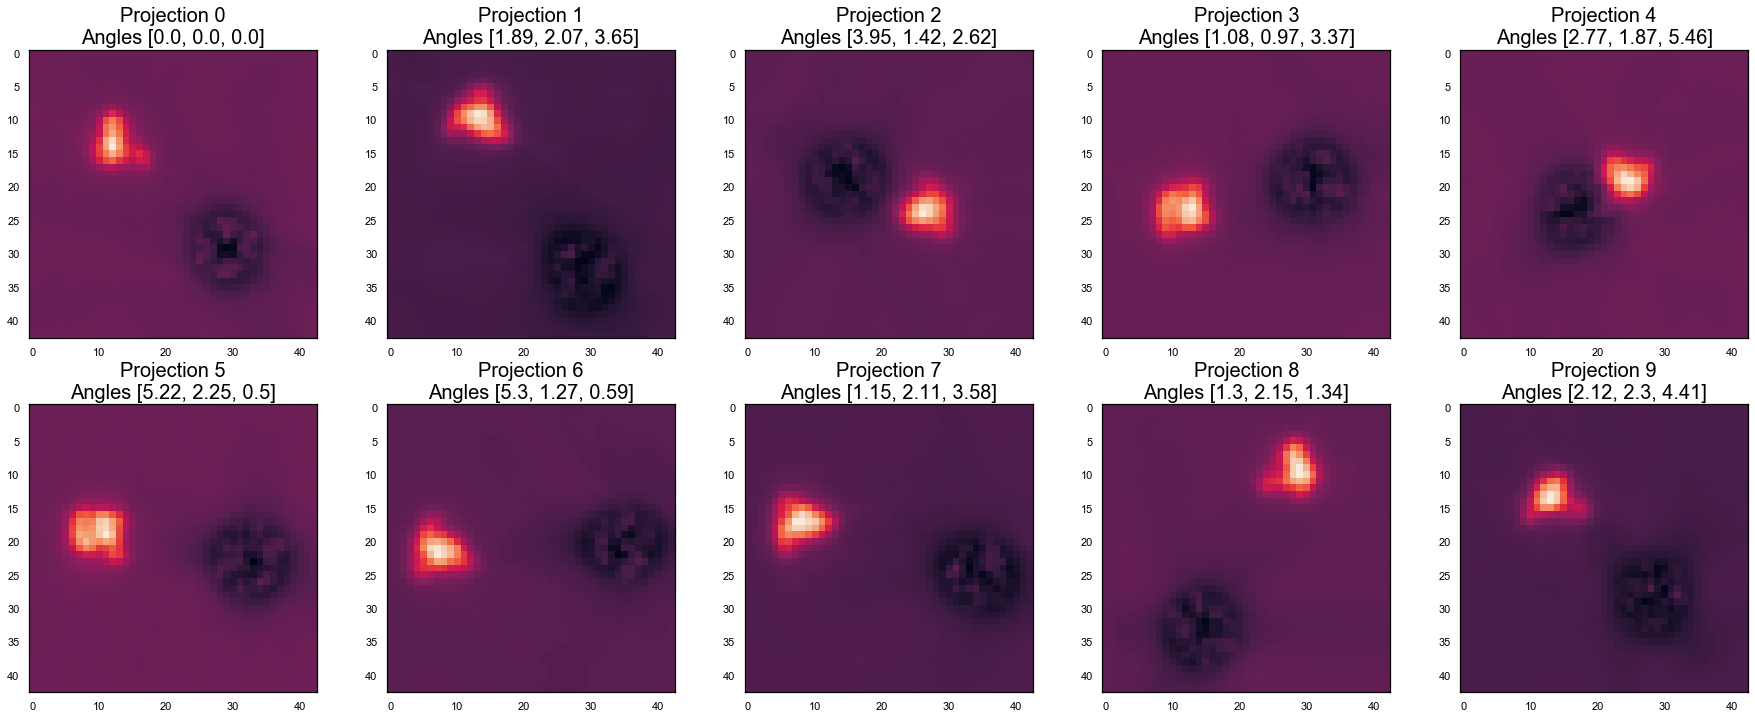

Q -882620890.3691659
delta Q 0.0
Q -882643824.7940391
delta Q -22934.42487323284
Q -882666641.7828575
delta Q -22816.98881840706
Q -882689336.2098082
delta Q -22694.42695069313
Q -882711917.7816471
delta Q -22581.571838855743
Q -882734376.0927846
delta Q -22458.31113755703
Q -882756719.608317
delta Q -22343.515532374382
Q -882778951.0747958
delta Q -22231.466478824615
Q -882801059.195109
delta Q -22108.120313167572
Q -882823057.1755856
delta Q -21997.980476617813
Q -882844939.7997192
delta Q -21882.624133586884
Q -882866709.8654045
delta Q -21770.065685272217
Q -882888365.2169896
delta Q -21655.351585149765
Q -882909910.9599742
delta Q -21545.74298453331
Q -882931336.4074714
delta Q -21425.44749724865
Q -882952659.565246
delta Q -21323.157774567604
Q -882973871.2082224
delta Q -21211.642976403236
Q -882994969.4997462
delta Q -21098.2915238142
Q -883015958.4165583
delta Q -20988.916812062263
Q -883036841.8244117
delta Q -20883.407853484154
Q -883057614.3370224
delta Q -20772.51261067390

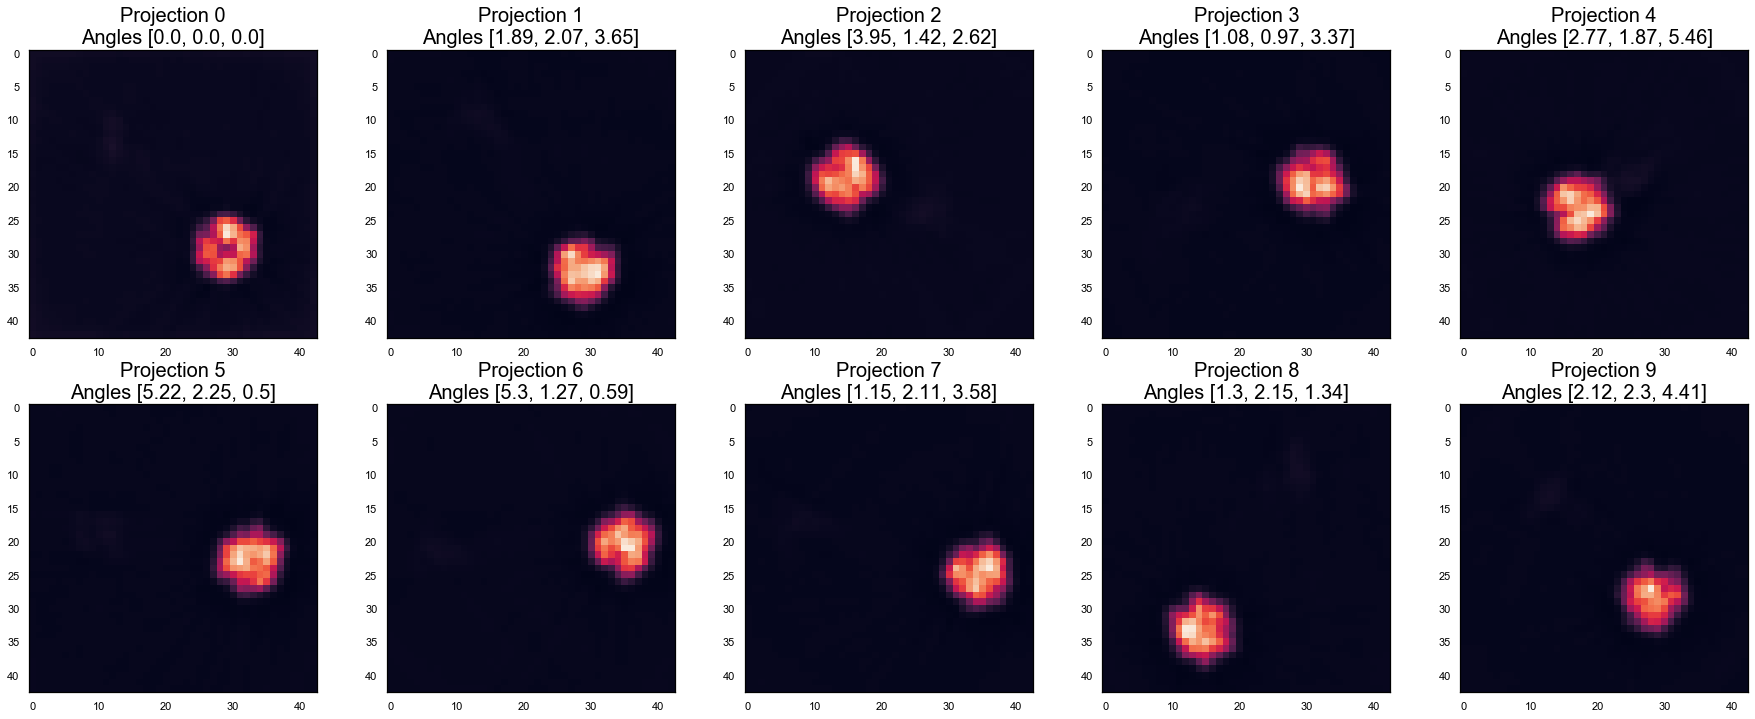

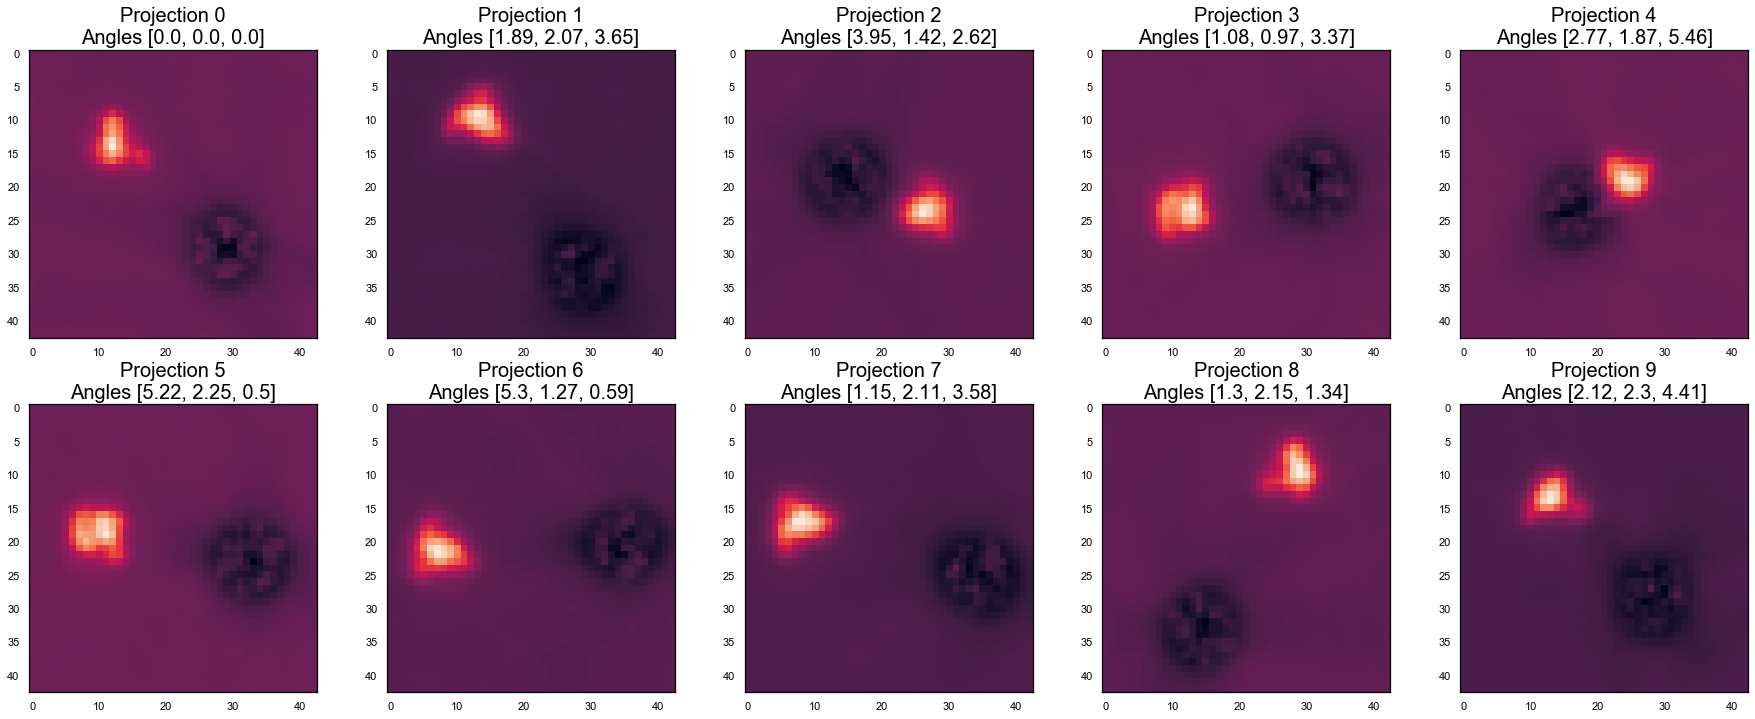

Q -883633178.4760053
delta Q 0.0
Q -883650864.8766543
delta Q -17686.40064895153
Q -883668455.322039
delta Q -17590.44538474083
Q -883685961.4060931
delta Q -17506.084054112434
Q -883703380.5083588
delta Q -17419.1022657156
Q -883720704.2202773
delta Q -17323.711918473244
Q -883737936.4745599
delta Q -17232.254282593727
Q -883755085.7200856
delta Q -17149.245525717735
Q -883772139.4939759
delta Q -17053.77389025688
Q -883789116.8702102
delta Q -16977.376234292984
Q -883805992.3282943
delta Q -16875.458084106445
Q -883822786.6744208
delta Q -16794.346126556396
Q -883839494.3304001
delta Q -16707.655979275703
Q -883856125.5555586
delta Q -16631.225158452988
Q -883872656.354058
delta Q -16530.79849946499
Q -883889110.1100725
delta Q -16453.756014466286
Q -883905480.1200855
delta Q -16370.010012984276
Q -883921762.7970233
delta Q -16282.676937818527
Q -883937965.3118421
delta Q -16202.514818787575
Q -883954078.6260395
delta Q -16113.314197421074
Q -883970116.2562045
delta Q -16037.63016498

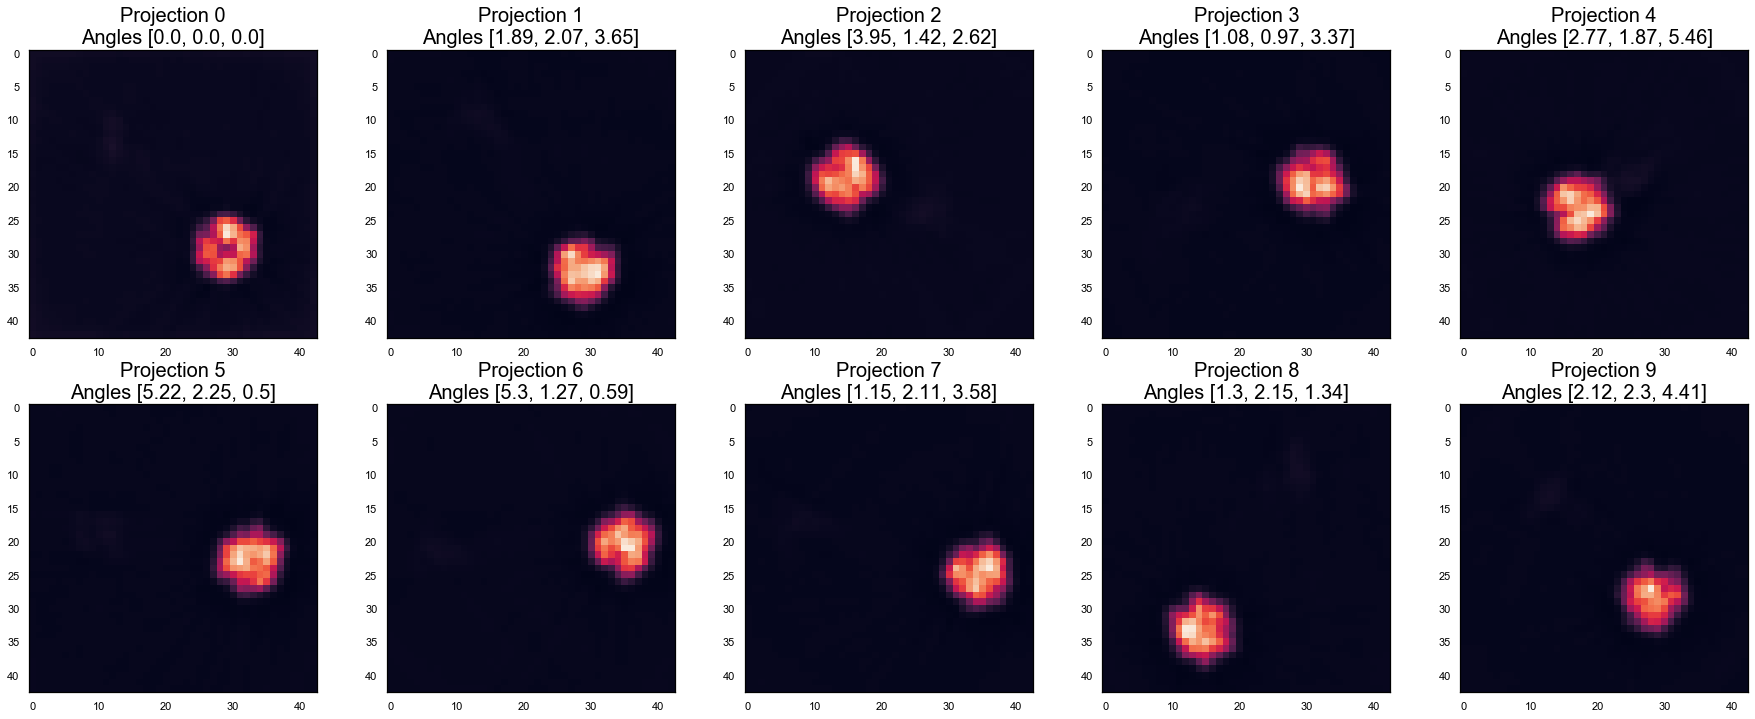

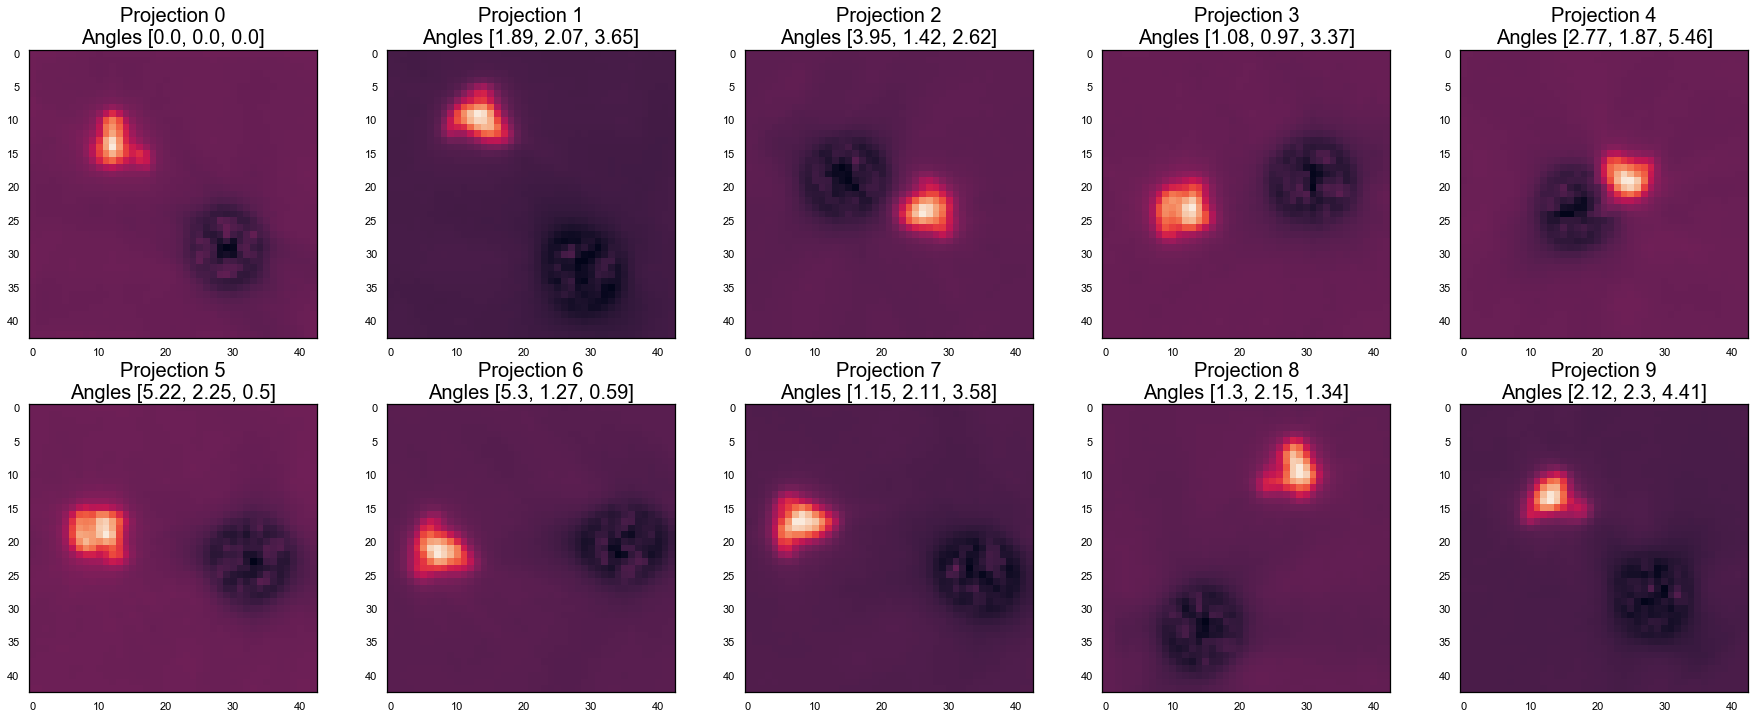

Q -884414636.1797743
delta Q 0.0
Q -884428305.1695426
delta Q -13668.989768266678
Q -884441902.6585238
delta Q -13597.488981246948
Q -884455433.732368
delta Q -13531.073844194412


In [ ]:
_, num_image , n_component = 116, 5000 , 2
print(P3R.mu.shape)
print(ProjSize1)
Mus = P3R.mu.reshape(1, ProjSize1, ProjSize1, ProjSize1)
P3RM = PCA_3d_Recon_recurssive(ProjSize1, num_image, n_component,Mus )
P3RM.Au_s(angles2)
print(P3RM.Aus.shape)
#P3RM.Plot_mu_by_projection(angles2)
#P3RM.Expectation(new_projection , angles2)
#P3RM.Maximization(new_projection , angles2)
P3RM.fit(new_projection , angles2)

In [ ]:
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)

In [ ]:
#Check ro_j whether the same

print(True_z2.reshape(-1)[:5])
print(P3RM.ro[:5,0])
print(True_z1.reshape(-1)[:5])
print(P3RM.ro[:5,1])

print(P3RM.Mus.shape)
vec1 = P3RM.Mus[0].reshape(-1)
vec2 = P3RM.Mus[1].reshape(-1)
print(np.sum(vec1*vec2))
print(np.dot(vec1 ,vec1) /np.linalg.norm(vec1) / np.linalg.norm(vec1))
print(np.sum(vec1*vec2) / np.linalg.norm(vec1) / np.linalg.norm(vec2))

In [ ]:
print(np.linalg.norm(Vol2))
print(np.linalg.norm(Vol1))
print(np.linalg.norm(P3R.mu))

In [ ]:
#print(P3R.mu)
ProjSize = ProjSize1
curremt_mu = P3R.mu.reshape(ProjSize,ProjSize,ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

In [ ]:
print('the 2th component')
curremt_mu = P3RM.Mus[-1].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)
print(curremt_mu.shape)
print('P3RM.Mus[-1]',np.mean(P3RM.Mus[-1]))
print('+P3RM.Mus[0]', np.mean(P3RM.Mus[0]))
print(np.sum(np.abs(P3RM.Mus[-1]+P3RM.Mus[0])))

In [ ]:
curremt_mu = P3RM.Mus[0].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)
curremt_mu = P3RM.Mus[-1].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(-CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)